# Shell mass estimation from FIR dust SEDs
I'm deciding on a path forward based on the referee's feedback about my current method.
The feedback centered around the method by which I derive temperature and optical depth from the 70 and 160 micron photometry.

Here, I'll summarize my previous method and then lay out the possible paths forward and how/why they differ.

My general question is: how closely should I follow the expressions the referee gave? I think a more accurate answer can be obtained if I account for the bandpass profiles (as I had previously), but this strays from the referee's expressions.

In summary, the shell mass should change by less than 10% if we adopt the referee's method, and will change by less than 5% if I handle the bandpasses correctly. I am now thinking about how to discuss potential optical depth effects the referee warned about.

## 1 Least-squares approach
The approach I used previously used software I had already prepared for fitting Herschel SPIRE and PACS photometry with temperature and optical depth and, optionally, dust opacity spectral index.
It was designed for "overdetermined" problems, with more photometry bands available than there are independent variables.

The optimization itself was done with [`scipy.optimize.minimze`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) using the [`L-BFGS-B`](https://en.wikipedia.org/wiki/Limited-memory_BFGS#L-BFGS-B) algorithm for bound constrained minimization.
`scipy.optimize.minimize` finds the optimal values of one or more dependent variables by minimizing a single-value function of those variables.
The routine itself is not aware of how many data points are involved in the single-value function execution, so it is up to me to provide functions that (should) have global minima. I used functions that returned the sum of squares, weighted by the observations' uncertainties, making this a non-linear least-squares minimization.

In theory, if the number of variables equals the number of observations, there should be a single unique solution which the optimization should find. It's not as elegant as a more direct approach, as the referee points out.

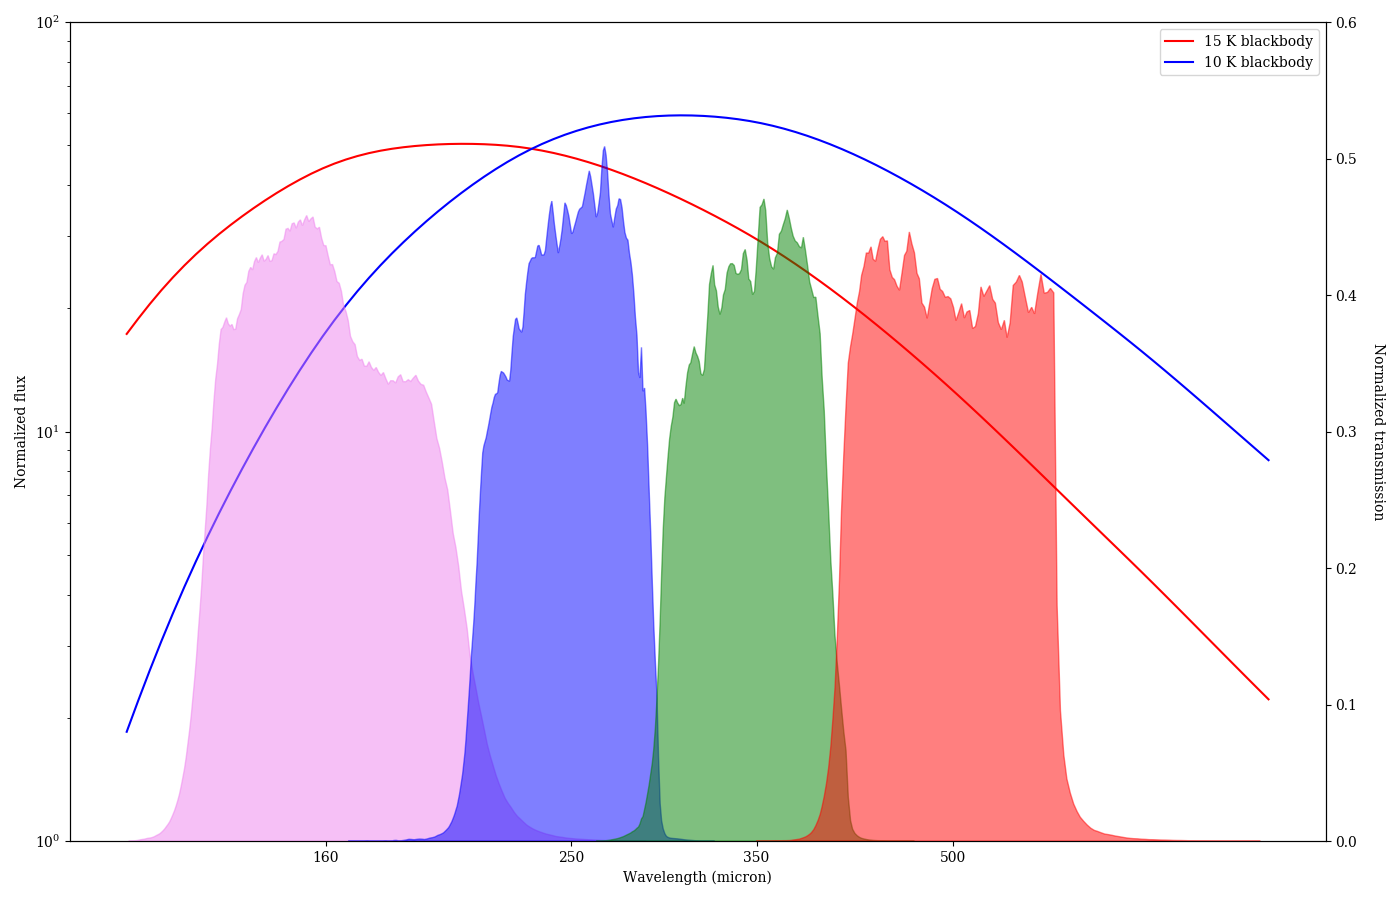

In [1]:
from IPython import display
from base64 import b64decode
base64_data="iVBORw0KGgoAAAANSUhEUgAABXgAAAOECAYAAAAbi1lvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAIABJREFUeJzs3XlclPX6//H3sAoumEtiiRvmQpo75pboMZeyY2qmZrlUVpaVaVmerLS9PB39llanjtmmaeaSmVputGmimR5Jj+aOKW4piijr/P64fgwgi2jAMPB6Ph6fxzD3fc/wGRxA3vd1Xx+H0+l0CgAAAAAAAADgcbzcPQEAAAAAAAAAwOUh4AUAAAAAAAAAD0XACwAAAAAAAAAeioAXAAAAAAAAADwUAS8AAAAAAAAAeCgCXgAAAAAAAADwUAS8AAAAAAAAAOChCHgBAAAAAAAAwEMR8AIAAAAAAACAhyLgBQAAAAAAAAAPRcALAAAAAAAAAB6KgBcAAAAAAAAAPBQBLwAAAAAAAAB4KAJeAAAAAAAAAPBQPu6eQGGIjo7Wyy+/rObNm2vXrl0KDw/XPffc4+5pAQAAAAAAAECBcjidTqe7J1HQIiMjJUkRERFKTk5WtWrVtG/fPlWoUMG9EwMAAAAAAACAAlRsWzQkJSVp/Pjx8vHx0b59+7LtX7hwoVq1aqWOHTuqU6dO+u2331z7IiIiFBER4brv5+cnb2/vIpg1AAAAAAAAAHfIKy/Myf79+zVgwAB16dJF1113nVq2bKk1a9YU0WwLTrEMePft26dOnTrp0KFDSk1NzbY/KipKQ4YM0axZs/TDDz/onnvuUffu3XXmzJlsx7777ruaMGGCypYtWxRTBwAAAAAAAFDELiUvlKTjx4+rc+fOuu+++7R69Wpt2bJF9erVu2goXBwVyxYN0dHRKlOmjA4ePKjOnTtr7969ql27tmt/v3795OPjo7lz50qS0tLSdNVVV2nChAkaNWqU67hFixYpOjpaEyZMKOqXAAAAAAAAAKCI5DcvTDdu3DgdOHBAc+bMcW07cOCA0tLSsuSQnqBYVvA2btxY9erVy3X/qlWr1Lp1a9d9Ly8vtWzZUitXrnRtmzNnjnbt2qUJEyZoy5Yt2rlzZ6HOGQAAAAAAAIB75CcvzGz+/Pnq1KlTlm01a9b0uHBXknzcPYFLdeLECcXFxSk4ODjL9uDgYG3YsEGStGbNGt1///1q3ry5lixZouPHj2vatGmqX79+js+ZmJioxMRE1/2UlBRt375dISEh8vIqlhk4AAAAAAAAUGKlpaXpwIEDCgsLk49PRoTp7+8vf3//LMfmJy/M7OzZs9qzZ4/S0tI0ePBg7du3T4GBgbr//vt12223Fc4LKkQeF/AmJCRIUrZ/SH9/f9e+zp07Ky4uLt/P+corr2jSpEkFN0kAAAAAAAAABe65557TxIkTs2zLT16Y2alTpyRJEyZM0KpVq9SiRQtFRUWpU6dOSk1N1YABAwpn8oXE4wLewMBAScpScZt+P33fpRo/frzGjBnjuh8TE6PGjRsrKipK1atXv/zJAgAAAAAAALhkhw8fVnh4uKKjoxUSEuLafmGIK116Xph+xX6vXr3UokULSVJ4eLj69OmjKVOmEPAWtsqVKysoKEixsbFZtsfGxqpu3bqX9ZwXlnYHBQVJkqpXr64aNWpc/mQBAAAAAAAAXLagoCBVqFAhz2MuNS+sWrWq/P39s+V+tWrV0qpVq/76pIuYRzaY7dKlizZu3Oi673Q6tWnTJnXt2tWNswIAAAAAAADgDpeSF/r4+Kht27Y6fPhwlu1HjhxRzZo1C32uBc0jA96nnnpKS5cu1c6dOyVJs2bNkre3t4YOHermmQEAAAAAAAAoahfLC7t06aKnn37adfyTTz6pRYsWae/evZKk/fv3a+HChXrkkUeKfvJ/UbFs0ZCUlKRu3bq5Gh4PHDhQISEhmjdvniTrifHRRx/pjjvuUEBAgLy8vPTNN9+ofPny7pw2AAAAAAAAADe4WF547ty5LD16e/TooWnTpqlfv34KDAxUSkqK3njjDd11113uegmXzeF0Op3unkRxc/DgQYWEhCgmJoYevAAAAAAAoFRIS0tTUlKSu6eBUsLX11fe3t657iefy79iWcELAAAAAACAopOUlKS9e/cqLS3N3VNBKVKxYkUFBwfL4XC4eyoejYAXAAAAAACgFHM6nTp8+LC8vb0VEhIiLy+PXLIJHsTpdCohIUFHjx6VJFWvXt3NM/JsBLwAAAAAAAClWEpKihISEnTVVVcpMDDQ3dNBKREQECBJOnr0qK688so82zUgb5ySAQAAAAAAKMVSU1MlSX5+fm6eCUqb9BMKycnJbp6JZyPgBQAAAAAAAH1QUeR4zxUMAl4AAAAAAAAA8FAEvAAAAAAAAPBISUlJGj9+vHx8fLRv375s+4cNG6brr79eERERrnH//ffn+nxRUVGKiIiQw+FQw4YN9dxzz0mSVqxYoQYNGqhSpUqKiIjI8bHDhw9XcHCwhg0bluvz9+zZUxUrVtTEiRMv4VXmbseOHa75RkZG5njM+PHjVbt27Vznfbl69epVoK8Fl49F1gAAAAAAAOBx9u3bp0GDBql+/fquPsI5mTNnjmrXrp2v5wwPD1dkZKQcDoeeeuopV1hbs2ZNlS9fXvPnz1fjxo1zfOzMmTPzDHcladmyZQUatDZo0MA139y88sor8vf3zzUAvlxLliwp8NAYl4cKXgAAAAAAAHic+Ph4ffLJJxo+fHihfp6tW7dq8ODBmj17dq7hLuBOBLwAAAAAAADwOI0bN1a9evUK9XP88ssvuvvuuzVv3jzVr18/X49JS0vTuHHjFBERodq1a2vy5Ml5Hr969Wp17txZERERatu2rYYNG6ZTp05lOSYqKkodO3ZUmzZtFB4eroEDB2r79u05Pt/o0aNVrlw5hYeHa8aMGVn2vf7667rxxhtVs2ZNjR07Vmlpaa59R44c0YABA9SsWTM1bdpUgwcP1p9//unan5KSoocffli1atVS165d9frrr2d57sGDB8vhcCgsLExz586VJI0bN05VqlRRhw4dLv6Fw2Uj4AUAAAAAAEAGp1M6e9Y9w+ks8JfzyiuvKCIiQh06dNBDDz2kI0eO5Otx69at0wMPPKBFixapTp06+f58ixYtUr9+/RQZGanly5fr2Wef1ZIlS3I9funSperTp48iIyO1du1a+fr6asyYMa79x44dU7du3TRy5EitX79ea9euVVxcnL755pscny80NFQjRoxQVFSU7rnnHtf2DRs2qE6dOlqxYoWioqI0e/Zsvf322679ffv2VVBQkDZv3qzNmzdLkgYOHOjaP3nyZC1ZskSbNm3SypUrVadOHW3YsMG1f9asWerQoYO6dOmiAQMGSJJefvllhYaG6ocffsj31w+XjoAXAAAAAAAAGRISpHLl3DMSEgr0pdSvX1833HCDVq9erdWrVysxMVHXX3+94uPjL/rYmTNn6uDBg0pMTLykz9m0aVO1adNGktSwYUP17NlTb775Zq7HjxkzRvfdd58kyeFw6LbbbtOyZctc+6dNm6YKFSpo0KBBkiQfHx89/fTTatSoUbbnev/99xUdHa0pU6Zk21epUiX1799fkhQcHKxBgwa55rVmzRqtXbtW48aNc83jiSee0IoVK1wh7ptvvqkhQ4aocuXKkqT+/furUqVKWT7H8OHDNXv2bNfX7Ouvv1aPHj3y7BGMv46AN5Pp06crLCyMBtEAAAAAAAAlwD/+8Q8NHjxYXl5e8vPz07/+9S8dOHBAn3322UUfO2nSJAUEBKhbt275rvqVpFq1amW5Hxoamms7BclaH4waNUrt2rVTRESEnnzyScXGxrr2R0dHKzQ0NEtI2qFDB3Xv3j3L83z66acaOXJkrtXGOc1r9+7dSk5OVnR0tLy9vVW3bl3X/vT2F9HR0YqLi1NsbGyW/ZItPpfZ7bffruTkZC1cuFCS9OGHH2ro0KG5vnYUDALeTB566CFt27atwFcVBAAAAAAA8BiBgVJ8vHtGYGChvrQKFSqoatWq2r1790WPrV69ulasWKH4+Hj16NFDp0+fztfncF7QZsLpdOZZwdqzZ0+dPHlSa9asUWRkpKZOnZrn8+UmPj5e77zzjiZNmqRdu3bla155fY70OWee+8UqccuVK6f+/ftr5syZOnr0qM6ePZstFEbBI+AFAAAAAABABodDKlvWPaOAL+V/9NFHs9xPTEzUiRMnFBISkq/Hh4aGavny5dq7d6969+6dr3YNBw4cyHJ/z549atiwYY7HHj9+XNu2bdOtt94qf39/SVJSUlKWY5o0aZItkN64caOWLl2aZdsDDzygESNGqH379hoxYkS20DYmJibbvEJDQ+Xr66smTZooNTVVe/bsce3//fffJdlidkFBQapevXq2eVz4WiVr07By5Uq99NJLuvPOO3N83ShYBLwAAAAAAAAokd59911t3LjRdf/FF19UUFCQqxdtfjRr1kyLFy/Wzz//rDvuuENpaWl5Hh8VFeXqW7tjxw4tW7ZMjzzySI7HVq5cWcHBwVq1apVr24IFC7IcM2rUKJ0+fVpz5syRZAHw2LFj5evrm+Nzvvfee4qKitKMGTOybD98+LDmz58vSYqNjdWcOXNc8+rcubPatWun119/XZJV9E6ePFndunVTq1atJEmPPPKIPv74Y504cUKSNH/+/CytJNJ17NhRoaGhmjlzpvr165fHVwoFhYAXAAAAAAAAHicpKUkREREaPXq0JGngwIHZgtt//vOfeuyxx9S5c2e1adNGmzZt0po1a3TllVfm+JxRUVGutZleffVVPffcc5KkG264QXPnztXixYvVokULvffee9keO3z4cC1fvlx9+/bVBx98oBtuuEHdunXTpEmT1KtXL0nWjmHz5s368MMPNWHCBDkcDs2bN09btmxR06ZN1bt3b/n5+UmSIiIidOzYMVWtWlXffvutpk+frjZt2qhTp04aNGiQbrzxRsXGxrrmO3r0aC1fvlyfffaZAgICNGbMGPXu3Vvjx4/Xhx9+qHbt2umXX35R586dFR4erkGDBunBBx90zX/BggU6deqUmjZtqmbNmkmSZs+e7dr/+OOP65ZbblHz5s3VpUsXbdy4Ue3atXO9lsyGDBmi22+/XWXLls3XvyX+Goczv408SpGDBw8qJCREMTExqlGjhrunAwAAAAAAUGjOnz+vvXv3qk6dOipTpoy7p4MS4IEHHtBdd92l9u3b53lcXu898rn8o4IXAAAAAAAAwF8SGRmpdevWKS4uTlu2bLlouIuC4+PuCQAAAAAAAADwbHFxcRo1apSqVaum1157zd3TKVUIeAEAAAAAAAD8Jb1791bv3r3dPY1SiRYNAAAAAAAAAOChCHgBAAAAAAAAwEMR8AIAAAAAAACAhyLgBQAAAAAAAAAPRcALAAAAAAAAAB6KgBcAAAAAAAAAPBQBLwAAAAAAADxSUlKSxo8fLx8fH+3bty/HY/7973+rRYsWat++vW6++Wb98ccfuT5fVFSUIiIi5HA41LBhQz333HOSpBUrVqhBgwaqVKmSIiIicnzs8OHDFRwcrGHDhuX6/D179lTFihU1ceLEfL7CvO3YscM138jIyByPGT9+vGrXrp3rvC9Xr169CvS14PIR8AIAAAAAAMDj7Nu3T506ddKhQ4eUmpqa4zELFizQc889p+XLl+unn35SmzZt1KtXL6WlpeV4fHh4uCsofeqppzRp0iRJUs2aNVW+fHl9//33uQapM2fOVI8ePfKc87Jly9SsWbP8vcB8aNCgQa7zSffKK6/kGTpfriVLlhToa8HlI+AFAAAAAACAx4mPj9cnn3yi4cOH53rMSy+9pKFDh+rKK6+UJD366KOKjo7W0qVL8/15tm7dqsGDB2v27Nlq3LjxX543UNAIeAEAAAAAAOBxGjdurHr16uW6/+TJk9q0aZNat27t2hYUFKT69etr5cqV+focv/zyi+6++27NmzdP9evXz9dj0tLSNG7cOEVERKh27dqaPHlynsevXr1anTt3VkREhNq2bathw4bp1KlTWY6JiopSx44d1aZNG4WHh2vgwIHavn17js83evRolStXTuHh4ZoxY0aWfa+//rpuvPFG1axZU2PHjs1SyXzkyBENGDBAzZo1U9OmTTV48GD9+eefrv0pKSl6+OGHVatWLXXt2lWvv/56lucePHiwHA6HwsLCNHfuXEnSuHHjVKVKFXXo0OHiXzhcNgJeAAAAAAAAuDid0tmz7hlOZ8G9jj179kiSgoODs2wPDg527cvLunXr9MADD2jRokWqU6dOvj/vokWL1K9fP0VGRmr58uV69tlntWTJklyPX7p0qfr06aPIyEitXbtWvr6+GjNmjGv/sWPH1K1bN40cOVLr16/X2rVrFRcXp2+++SbH5wsNDdWIESMUFRWle+65x7V9w4YNqlOnjlasWKGoqCjNnj1bb7/9tmt/3759FRQUpM2bN2vz5s2SpIEDB7r2T548WUuWLNGmTZu0cuVK1alTRxs2bHDtnzVrljp06KAuXbpowIABkqSXX35ZoaGh+uGHH/L99cOlI+AFAAAAAACAS0KCVK6ce0ZCQkG+Dnsyf3//LNv9/f1d+/Iyc+ZMHTx4UImJiZf0eZs2bao2bdpIkho2bKiePXvqzTffzPX4MWPG6L777pMkORwO3XbbbVq2bJlr/7Rp01ShQgUNGjRIkuTj46Onn35ajRo1yvZc77//vqKjozVlypRs+ypVqqT+/ftLspB70KBBrnmtWbNGa9eu1bhx41zzeOKJJ7RixQpXiPvmm29qyJAhqly5siSpf//+qlSpUpbPMXz4cM2ePdv1Nfv666/Vo0cPORyOi33Z8BcQ8GYyffp0hYWFFfiqggAAAAAAAChagYGBkpQtoE1MTHTty8ukSZMUEBCgbt266ciRI/n+vLVq1cpyPzQ0NNd2CpK1Phg1apTatWuniIgIPfnkk4qNjXXtj46OVmhoaJaQtEOHDurevXuW5/n00081cuTIXKuNc5rX7t27lZycrOjoaHl7e6tu3bqu/entL6KjoxUXF6fY2Ngs+yVbfC6z22+/XcnJyVq4cKEk6cMPP9TQoUNzfe0oGAS8mTz00EPatm3bRVcfBAAAAAAAKKkCA6X4ePeMfOSu+ZYeRmYOS9PvXxhU5qR69epasWKF4uPj1aNHD50+fTpfn9d5QZ8Jp9OZZwVrz549dfLkSa1Zs0aRkZGaOnVqns+Xm/j4eL3zzjuaNGmSdu3ala955fU50uecee4Xq8QtV66c+vfvr5kzZ+ro0aM6e/Zsvr7W+GsIeAEAAAAAAODicEhly7pnFOSV/FdccYWaN2+ujRs3uradPn1aO3fuVNeuXfP1HKGhoVq+fLn27t2r3r1756tdw4EDB7Lc37Nnjxo2bJjjscePH9e2bdt06623ulpJJCUlZTmmSZMm2r17d5ZtGzdu1NKlS7Nse+CBBzRixAi1b99eI0aMyBbaxsTEZJtXaGiofH191aRJE6WmpmbpTfz7779LssXsgoKCVL169WzzuPC1StamYeXKlXrppZd055135vi6UbAIeAEAAAAAAFAiTZgwQR999JGOHTsmyfrINm7cWDfddFO+n6NZs2ZavHixfv75Z91xxx1KS0vL8/ioqChX39odO3Zo2bJleuSRR3I8tnLlygoODtaqVatc2xYsWJDlmFGjRun06dOaM2eOJAuAx44dK19f3xyf87333lNUVJRmzJiRZfvhw4c1f/58SVbFPGfOHNe8OnfurHbt2un111+XZBW9kydPVrdu3dSqVStJ0iOPPKKPP/5YJ06ckCTNnz8/W3W0JHXs2FGhoaGaOXOm+vXrl8dXCgXFx90TAAAAAAAAAC5VUlKSunXrplOnTkmSBg4cqJCQEM2bN891TN++fXX06FF1795dZcqU0RVXXKGvvvpKXl451zxGRUW5Fhp79dVXtXfvXk2aNEk33HCD5s6dq379+qlFixZ68MEHXQujpRs+fLiWL1+uvn376oMPPtDYsWO1f/9+TZo0Sb169ZJk7Rg2b96sffv2KSUlRS+++KLmzZunhx9+WE2bNlXt2rVdvXIjIiI0b948Va1aVd9++63Gjh2rKVOmyMvLS0OHDtWNN96o2NhYDRw4UJI0evRovfrqq/rll18UEBCgMWPG6KuvvlJYWJg+++wztWvXTr/88oumTZum3bt3a9CgQXrwwQdd81+wYIFrHpJV7s6ePdu1//HHH9ehQ4fUvHlz1atXT23atFG7du304Ycful5LuiFDhmjfvn0qW7bs5f3j4pI4nPlt5FGKHDx4UCEhIYqJiVGNGjXcPR0AAAAAAIBCc/78ee3du1d16tRRmTJl3D0dlAAPPPCA7rrrLrVv3z7P4/J675HP5R8tGgAAAAAAAAD8JZGRkVq3bp3i4uK0ZcuWi4a7KDi0aAAAAAAAAADwl8TFxWnUqFGqVq2aXnvtNXdPp1Qh4AUAAAAAAADwl/Tu3Vu9e/d29zRKJVo0AAAAAAAAAICHIuAFAAAAAACAnE6nu6eAUob3XMEg4AUAAAAAACjFvL29JUlJSUlunglKm4SEBEmSr6+vm2fi2ejBCwAAAAAAUIr5+PgoMDBQx44dk6+vr7y8qAdE4XI6nUpISNDRo0dVsWJF10kGXB4CXgAAAAAAgFLM4XCoevXq2rt3r/bv3+/u6aAUqVixooKDg909DY9HwAsAAAAAAFDK+fn56ZprrqFNA4qMr68vlbsFhIAXAAAAAAAA8vLyUpkyZdw9DQCXiKYqAAAAAAAAAOChCHgBAAAAAAAAwEMR8AIAAAAAAACAhyLgBQAAAAAAAAAPRcALAAAAAAAAAB6KgBcAAAAAAAAAPBQBLwAAAAAAAAB4KAJeAAAAAAAAAPBQBLyZTJ8+XWFhYYqIiHD3VAAAAAAAAADgogh4M3nooYe0bds2RUZGunsqAAAAAAAAAHBRBLwAAAAAAAAA4KEIeAEAAAAAAADAQxHwAgAAAAAAAICHIuAFAAAAAAAAAA9FwAsAAAAAAAAAHoqAFwAAAAAAAAA8FAEvAAAAAAAAAHgoAl4AAAAAAAAA8FAEvAAAAAAAAADgoQh4AQAAAAAAAMBDEfACAAAAAAAAgIci4AUAAAAAAAAAD0XACwAAAAAAAAAeioAXAAAAAAAAADwUAS8AAAAAAAAAeCgCXgAAAAAAAADwUAS8AAAAAAAAAOChCHgBAAAAAAAAwEMR8AIAAAAAAACAhyLgBQAAAAAAAAAPRcALAAAAAAAAAB6KgBcAAAAAAAAAPBQBLwAAAAAAAAB4KAJeAAAAAAAAAPBQBLwAAAAAAAAA4KEIeDOZPn26wsLCFBER4e6pAAAAAAAAAMBFOZxOp9PdkyhuDh48qJCQEMXExKhGjRrung4AAECxlJYmJSRI8fEZ48yZrPfTR2KilJwspaTYbeaPL7xNTZW8vCRv74xx4f3M28qUkQIDM0ZAQNb7mUfZslLFilK5cpLD4e6vIAAAAHJDPpd/Pu6eAAAAANwvKUk6cUI6fjzrOHYs+7bjx6WTJ6WzZyVPLRXw8ZGuuCLvUamSVLWqFBxso1o1ydfX3TMHAAAAsiLgBQAAKOESE6U//pAOHrQRE5P94yNHLv/5HQ6riC1f3m5zGv7+Fo76+OR96+trlblpaVbJmz7yup+YaJXEeY1z5+z2zBmrFE5JsfD62LFLe61VqmQEvtWrZ/+4Vi0pJIQgGAAAAEWHgBcAAMDDOZ0W0P7+e9axd6+Ft0eP5u95vLykypWtarVKlbxHpUoZgW5AgOe0O3A6Leg9eTJj/Pln1vuZtx87JsXG2tc3JSWjgjk6OvfP4eUlXX21hb21a2eM9PshIRZ4AwAAAAWBgBcAAMBDHD8u7dhh4e2uXVnD3Pj4vB9bpoxUo4aNkJCcP65c2cLJkszhsD68Zcvaa86vtDRrYREbmzEOH856/48/pAMHpPPnrTI6Jkb68cec51C9uhQaKjVsKDVokHFbu7ZVMwMAAAD5xX8fAQAAipnERGn7dum//8068mqj4OVlFaL16knXXGMjNDQjwK1c2XOqbIsjLy+rbK5aVWrSJPfjnE6rmN63L/vYv99uz52TDh2y8cMPWR/v52f/dumhb3rw26CBFBRUWK8OAAAAnoyAFwAAwE2cTmuh8N//Slu3ZgS5//uf9Za9kMNhgW16gJt51KnDZf/FgcNhi7FVqya1aZN9v9NpbR/27rUq7B077N/7f/+Tdu60cP+332xcqHZtqVmzrKNmTYJ7AACA0o6AFwAAoIjExUlRUdL69dLPP9vt8eM5H3vFFdJ112Ud115rrQXguRwO6corbVwYAKemWouH9NA3c/gbG5tRCbxoUcZjKlbMCHubN7fbRo1Y5A0AAKA0IeAFAAAoBCkpthBX5jB3+/bsx3l722X4F4a5V19NZWZp4+1tldh16kg9emTdd/KktGWLtHlzxvjtN+nUKSky0kY6Pz9rI9G2bcaoXZv3EwAAQEnlcDqdTndPorg5ePCgQkJCFBMToxqXsvoGAAAotc6csX6q331nge7GjVJCQvbj6tSxys3rr7fbZs1sATTgUqX3av7116zB7+nT2Y+tVk1q1y4j8G3ZUgoIKPo5AwAA5Bf5XP5RwQsAAHAZEhKkn36S1qyRVq+2QPfCvrkVKkjh4RmBbni4XZoPFAR//4z2DOmcTuvvGxUlrVtn49dfbYG+hQttSNbCoVkzC3vbtZNuuEGqXt09rwMAAAB/DRW8OeAMAQAAuND581aZmx7orl8vJSdnPaZuXalzZ6l9ewt1GzaUvLzcM18g3blz0i+/ZAS+a9da4HuhRo3s/dulixQRIVWuXORTBQAAcCGfyz8qeAEAAHLgdEpbt0pffy2tWGHB2PnzWY8JCbEwrHNnGzVrumeuQF4CAqQOHWxI9t7ety8j8P3pJ2vtsH27jbfftn69TZva+7tLF6ljR6tIBwAAQPFDBW8OOEMAAEDplJBgFbpLlliwGxOTdX9wcNZAt25dFq5CyfDnn9Y/evVqG9u2Zd3v7S21bm3v/78Q4ZGAAAAgAElEQVT9zcJiPz/3zBUAAJQO5HP5R8CbA95AAACUHgcOWJj79dfSqlVZq3QDAizM6tnTgq0GDQh0UTrExtrJjvSWJLt3Z91frpx0443SzTfb98dVV7lnngAAoOQin8s/At4c8AYCAKDkSkuzXrpLltjYujXr/po1pV69bEREWMgLlHb791vYu2qV9O230tGjWfc3by7ddJMFvuHhVvELAADwV5DP5R8Bbw54AwEAULKkpVmv0c8/l+bNkw4fztjn5SW1a2eB7s03S9deS5UukJe0NGnTJmnpUqt837DB+vqmq1RJ6tHDvp+6d2exNgAAcHnI5/KPgDcHvIEAAPB8aWnS+vUZoe4ff2TsCwqyasNevQiggL/q6FFp+XILfL/5Rjp1KmOfl5f16+3XT+rTxxYmBAAAyA/yufwj4M0BbyAAADyT02nVhHPnWqibeZG0ChWkW2+Vbr/deoeyQBRQ8FJSrFo+vbr3whYo4eEW9vbtK9Wr5545AgAAz0A+l38EvDngDQQAgOdwOqVff5XmzLFq3f37M/aVLy/17m2hbrdukr+/++YJlEb790sLF0rz50s//ZS1lcN111nQ268frVEAAEB25HP5R8CbA95AAAAUf8eOSbNmSR98kLVKsGxZ6e9/t1C3Rw+pTBn3zRFAhthYadEiC3vXrJFSUzP21a9vYe9tt0ktWhD2AgAA8rlLQcCbA95AAAAUTykp1uvzgw+kJUuk5GTb7u9voe6AAdZbNyDAvfMEkLcTJ6SvvrKw99tvpaSkjH3160t33GHjmmvcN0cAAOBe5HP5R8CbA95AAAAUL9u3SzNnSp98YlWA6Vq1koYPlwYNkq64wn3zA3D5Tp+2nr3z51vf3nPnMva1bi0NHmwnb4KD3TdHAABQ9Mjn8o+ANwe8gQAAcL+4OFssbeZM6eefM7ZXrSrdeacFu02auG9+AAremTPWxmHWLGnlyow2Dl5e0t/+ZmFvnz62aCIAACjZyOfyj4A3B7yBAABwn82bpbfekj77LKOSz9vbWi/cfbfd+vm5d44ACt+RI7Zw4qxZ0vr1GdvLlJFuucXC3p49+XkAAEBJRT6XfwS8OeANBABA0UpOlhYskKZNk378MWN7o0YW6t55J5dnA6XZ7t3S7NkW9u7YkbG9ShX7+XD33VT0AwBQ0pDP5R8Bbw54AwEAUDSOHJHee096913p0CHb5uMj9esnjRoltW8vORzunSOA4sPplH791cLe2bOlw4cz9rVqJd1zjzRwoFSxovvmCAAACgb5XP55uXsCAACg9Fm/3qruQkKkZ5+1cLdaNft4/35pzhypQwfCXQBZORxSixbSP/8pHThgi7L16yf5+kobN0ojR0rVq9vPlzVrpLQ0d88YAACg8Pm4ewIAALhFaqp0/rz1BkhJsfspKRkj8/30j9PSbKUfh8Nu00du9/38JH//rMOr9J5bTUy0fppvvSVt2JCx/frrpYcflm67jV6aAPLPx8d6ct90k3TsmPTpp9KMGdJvv1krh1mzpDp1bEHGoUOlmjXdPWMAAIDCQYuGHFACDgDFzPnz0unTUlycjcwfX3g/Pt5W5kofCQlZ76dvS052z2vx9c0e+vr7SwEBUvnyGaNChaz3L9x3xRXWfLJyZXvOYiwuTnrnHWnqVGvJIFmQO3CgBbutWrl3fgBKDqfTKnlnzLCFGk+ftu0Oh3TjjVbh26uXhcMAAKB4I5/LPwLeHPAGAoBClJoq/fmnlVsdOyYdP573x8ePW+lnUfDxyRje3tk/djgsPUhLy3574cdpaVJSUtHMPSgoI+ytUiXrqFxZqlpVuvpqqUYN64Pg7V34c5KFuVOnSm+/nRGy1KhhAcuIETYtACgsCQm2eOMHH1i7hnQ1akj33Sfde6+1cwAAAMUT+Vz+EfBmMn36dE2fPl1JSUnavXs3byAAuFQJCdIff+Q8Dh6028OHLeS9HOXLW5iZPipUyH6/fHmrhg0IkAIDMz7Obfj6WnhbWK0TnE6rFk5MtErkxMSsI33buXPSmTPZx+nTOW87eVI6ccKe/1J4e1uikR745nQbEvKXeiXs3StNnmyhSnq+HRYmPfWUVe0W84JjACXQ7t3S++9bZe/x47bNx0fq00d68EGpUyd6fgMAUNwQ8OYfAW8OeAMBQC7On5f27ZP27LG/lvfssbF3rwW4J0/m/7kqVrQSzsyjSpXs96tUsXYE5cuX6v61OUpNlU6dsrTi+HELfNM/zrztyJFLC9e9vKRataR69bKPunWlMmVyfNjWrdJrr9kCaemfpk0bafx46ZZbSu8/3+nTVkUYESHVru3u2QClW2Ki9MUX1jbmp58ytjdqZFcXDBli5wsBAID7kc/lHwFvDngDASjV4uOl7dul33/PHuT+8cfFK0bLlrUq0LxGtWqUcbpDaqqFvenV1JkrqzPfnjuX+3M4HFbpmx74XnON1jra65XlzbVkVYDrsG7dLNilKk6KirI2FUOGSF26uHs2ANL9978W9H7yiXT2rG0LDJTuvNPC3mbN3Ds/AABKO/K5/GN5AQAorc6dsyD3t99sREfb7b59eT+ufHkpNNQqOevWtY/r1LHL+q++2toklPZEr7jy9pauuspGbpxOC4F37co+fv/dylFjYuSMidGqNV56XnfqB7WTJDmUptsqr9FTndapReeKkhpLJxpbFXYpFh1tuXn6AnMAiofrrrOA97XXLOR95x37Nfjeezbat5dGj5ZuvZVF2QAAQPHGf1UAoKRLS7NgbtOmjBA3OtoqcnOrxq1WTWrQwMLb9DA3/bZyZQLckszhkIKDbXTokHWf0ykdP66fFhzR01Or6Lv/BUuSfB3JGqqP9YTzNdU/8bu0QDbSBQdLjRvbaNZMat3a3l9FtNibO507J/36q328f7975wIgZxUqSA89ZL14f/jBgt75862Fw08/WceaRx6R7rmH9g0AAKB4okVDDigBB+DR/vjDrgnfsMFuN26U4uJyPrZyZQvdrr026yjlFZfI2aZN0oQJ0rJldt/PT7r/funJJ6WrqyZJO3bYyYOtW+02Otr6M+ekXDmpRQupVSsLfFu3thMIJezkwW+/SS+8YG2Ly5eX/vUvupMAnuDwYQt633knY1G2cuWku++2sDc01L3zAwCgNCCfyz8C3hzwBgLgMU6etCA3PczdsMH+Kr1QmTJS8+Z2PWrmIPfKK0tcoIaCt22b9OyzVtEmWeHt8OHSM89INWte5MFnztgTbN1qY9MmGwkJ2Y+94goLfDOHvh7+e3jdOumNN6yDyalT0ssvS9Wru3tWAPLr3Dlp1ixp6lQ7YSPZr82//93aN9BnHACAwkM+l3+0aAAAT3LkiBQZKa1ZY7c7dmQ/xtvbqnJbt5bCw+322mspG8Ql27NHmjjRwo20NAsx7rjDttWrl88nKV9eatPGRrrUVOv/vHFjxgmKLVvshMWKFTbS1axprSI6dJA6dpTCwiQvrwJ8lYXr7Fn7upUta8X1x44R8AKeJCBAuvdea8+wcqU0ZYpdxfDllzaaNZMee0waMEDy93f3bAEAQGlFBW8OOEMAoNg4cSIj0F2zxiohLxQamhHkhodbpW5gYJFPFSXHwYPSiy9KM2ZIKSm2rU8f6fnn7dxBoUhKsgrf9NB340Zr8ZCamvW4ihVt5aP0wLdVq2KdqixeLH38sX3doqOlBx6QunZ196wA/BXbt0tvvil99JFV+ErWavzRR6WRI+nTCwBAQbmcfG7hwoV66aWXFBAQIC8vL7399tu69tprczx24sSJWrRokSpWrOjaFhQUpC+//LJA5l+UqOAFgOLk1Cnp+++l1ast0P3vf7Mfc911UufONjp0sD66QAH480/ppZek6dOlxETb1r27hb2tWhXyJ/fzk1q2tHH//bYtPl5av1768Ucb69bZ98jXX9uQLNxt3dq+Fzp1stC3bNlCnmz+nT2b9X5srHvmAaDgNGpkvXlffFF6/31p2jSr0B8/XnrlFTuRM3o01foAABS1qKgoDRkyRBs3blSDBg308ccfq3v37tq+fbvKly+f42OmTp2qiIiIop1oIaCCNwdU8AIoMk6nlQJ99ZWV+v38s10Ln1lYWEag26kTC6ChwCUnW1gxcaJ1SZAsJ33pJbstNpKTrZVDeuD7ww/S0aNZj/H1ldq2tTLZv/3Nwl83tid55x0rwm/USPr9dyuwf/xxt00HQCFITpY++0x6/fWMPr1+ftLQodITT0jXXOPe+QEA4KkuNZ/r16+ffHx8NHfuXElSWlqarrrqKk2YMEGjRo3KdvzEiRMVERFRIgJez2liBwAlRXKyVeg+9pg1Mr32Wumpp6S1ay3crV/fKhjnzLFyv99+s/Kgfv0Id1GgnE4rhG3SxC4tPnnSWgksWyZ9910xC3clC2pbtbLSuC++sO+PnTulDz6wVd9q1bLvr++/t1Xh2re3Cve//136v/+z76UiPq8dF2dBj2S3p04V6acHUAR8faUhQ+yim8WL7UdPUpJV9zZoIPXvb11nAABA4Vq1apVat27tuu/l5aWWLVtq5cqVbpxV0aBFAwAUhZMnpeXL7S+/Zcss9Unn52eVhrfcIvXqJYWEuG+eKDWio6WxY6Vvv7X7VatKL7xgCwn5eMr/DhwOK4275hoLeJ1OWxlu5Upp1Sobf/5pFfJffWWPCQ6277euXa3/RCFfQx0Xl1FA7Otr99PSPGqdOAD55OVlv8pvucUuMnjtNWnJEjsf9cUX9qPnySftx4/D4e7ZAgBQspw4cUJxcXEKDg7Osj04OFgbNmzI9XEffPCBJk6cqOTkZNWrV0/PPvusQkNDC3u6Bc5T/oQDAM9z+LD0+ee2zPb332ddLKpqVenmm62y8MYbpXLl3DdPlCrHjllx63vvWdDo52fVu08/XQIWBnI4bNHB0FCrgk9LkzZvtqB35Upr6RAbK82aZUOSWrSw78Wbb7Z2DgWYvKamSmfOZAS8fn5W1ZeQwLc8UNJ16GAjOtpaN8yenXHeqUULu3CnXz9O9gAAkB9nzpzR6dOnXff9/f3lf8FCywkJCa59mfn7+7v2XahmzZoKCgrSBx98IC8vLz3//PNq2bKlfvvtN1199dUF/CoKF/+lAICCFBcnzZxpoW2NGnYp+Zo1lvSEhdlfdD/9ZOHvzJlSnz4kPSgSiYnSP/9pXUHefdeyz379pG3bLHzw+HA3J15elqQ88YT0zTdWSb9mjaXZ6ZdubdpkpcvXX2/VvUOGSHPnFkgvhXPnrGPEhQHvhQuvASi5GjeWPv5Y2r1beuQRKTDQfuzcfru1x/nss6znfwEAQHZhYWEKCgpyjVdeeSXbMYGBgZKkxPTVov+/xMRE174L3X333Xrsscfk4+MjLy8vPfPMMypTpozefvvtgn8RhYwKXgD4qxITre3CrFl2GXjmXyht29pfcbfcYlWFQBFzOqVFiyzj3L3btjVvLk2ZYmv2lSr+/lJEhI0XX5SOHLHWKV9/bQHwsWPSJ5/Y8Pa2Rpo33yzddJP1yr7Ea6oTEizQTf//pK8vAS9QWtWqZa3An3lGeust+3jbNumOO2yBywkTpEGDPKhFDgAARWjbtm1ZKmovrNKVpMqVKysoKEixsbFZtsfGxqpu3br5+jze3t6qXbu2dqf/4eRBqOAFgMuRliZFRkojRljVX58+1mAvMVFq1MjCo927beG00aMJd+EWO3ZYMXnfvvZ2DA629cg2bCiF4W5OqlWzZe4//1w6ftyqex9/3L6HU1OttcqTT1qZXd260pgx1lgzn+V2Z89mr+BNTpbi4wvxNQEo1qpUkSZNkvbvt4sHrrjC1oocMkRq2NB+Ricnu3uWAAAUL+XLl1eFChVcI6eAV5K6dOmijZlWNnU6ndq0aZO6du2a4/GPPvpotm2HDh1SiAeui0PACwCXYts2adw4K8Xp3Fn6z3/sUu6rr7ZgaNMm6bff7BLwfJ4lBArauXNWJXbdddbv0d/f3pK//25rkXl7u3uGxZCvr1X2Tp5s3+d79kjTpkk9e9oXcN8+K3vu2FG66irr8bt8uZXk5iIhwYIaPz+77+1t2TAVvACCgqxqd/9+6dVXLfjdvdsWuqxf3/qkX3CFKQAAuIinnnpKS5cu1c6dOyVJs2bNkre3t4YOHSrJAuCnn37adfzixYu1ePFi1/3//Oc/Onr0qO6+++6inXgB4CIgALiYxERpwQJrXPr99xnbg4Kk226TBg+WbriB1AzFwrJl0qhRlk9Klk9Om8b5hktWp4700EM2zp6Vvv1WWrjQ2rAcPWrpy3vv2c+Bm2+2MukePaSyZV1PkZAgpaRk/dHgcBDwAshQvrxdKDBqlP03Y/JkO590//1W4fvUUxb6linj7pkCAFD8hYeH66OPPtIdd9yhgIAAeXl56ZtvvlH58uUlSefOncvSo/ell17S1KlTNWXKFCUmJsrPz08rVqxQo0aN3PUSLpvD6XQ63T2J4ubgwYMKCQlRTEyMatSo4e7pAHCXvXstwJkxw3pzSpbU3HKLXUt5001W2QcUAwcPWjeQ+fPt/tVXW4/Hvn0vuXUs8pKUZO1ZFi605saZe3yVKSN1724tW3r31ndbKuqtt2yRpXTR0dJdd0m9exf5zAF4gIQE6f33bfHLQ4dsW/XqdhXGvffy3w4AQOlCPpd/tGgAgMxSU6XFiy28DQ216yaPHbO0bOJEu5Zy4UILcPgrC8VASor0r39Z29j58+0cxJgx0vbtUr9+hLsFzs9P6tZNeucd6Y8/pJ9+ksaOtYrf8+elL7+Uhg2TqlXT2SeflyPmQLY2DqdPu2fqAIq/wEDp0UetXcP06VKNGtLhw1bhW7++nXOmRy8AALgQAS8ASPbX04svWkjTu7dd5+50WpCzcKFdL/nccxb0AsXEunVSy5aWL8bHS23bWhvoN96wy35RyLy8pHbtpH/+09KYzZulZ5+VwsKkpCQlrP+v0qKi7JrrefOk7dvl65WqkyfdPXEAxV2ZMtKDD0q7dklvv22tvw8csCresDBp1qx8r/cIAABKAQJeAKVbVJR0++1SzZq2KlVMjFS5svTEE7Yi1TffSLfeKvnQshzFx59/SvfdZ9nif/8rVapk6/39+KMtrAY3cDikpk2lSZNsocWtW3W61x3yKhsopSRL236TPp8rv4VzdfKDBXYSiTI8ABfh7y+NHGlB77/+JVWtah/feaf9vJ8/X0pLc/csAQCAuxHwAih9nE4LVzp3ltq0scq6lBSpfXvpk0+smenrr0v16rl7pkAWTqc0Z47UoIH1aJSku++WduywRXi8+K1efDRurLgufeV7S09pxH1S23ZShSD5ppzVqS375bzpJik42FZSiowkoQGQp4AA6bHHbAHNl1+WKlaUtm2ztV5btZK+/tp+RwAAgNKJPwUBlB4pKXZNY7Nm1mM3MtIqc4cNk7ZssfLHO+9kqWoUS4cOWTH5oEHS8eO2cNcPP1g/xipV3D075OTMGcnXz2HXVnfrJo0eLb9be+n8ta2UWDXESrHfe89ONtWpY6so/e9/7p42gGKsXDlp/HhbB/bZZ+3+r79KvXrZVR2rVhH0AgBQGhHwAij5zp6V3nrLKnLvvNOuaS9Xzlai2rtXmjmT69pRbDmd9hYNC7P1/3x9peefl375RerQwd2zKz3i4uyy6EsJTs6etUXvXBwO+dWqrqQ2HXU2eq8lMffeKwUFWXPNl1+21fLatLHVlY4fL/DXAaBkqFjROsLs3SuNG2cVvj//LHXtKv3tb9aBCgAAlB4EvABKruPHpYkTpVq1pEcekfbvt+Z1L75oYcobb9jy1EAxtX+/1KOHtWGIi5Nat7ZF1J55RvLzc/fsSpf166U337Si2/xwOqWEhOztu319paQk6ex5b6lLF+u1ERsrff65leB5e1syM2qUVf726SMtWCAlJhb8iwLg8apUkV57zVo3PPKI/W5Ys8bOE/XvL+3c6e4ZAgCAokDAC6DkOXDA/sqpVcvKW06ckOrWtWWo9++3y6CvuMLdswRylZZmb9fGjaVvv7WuIZMnS2vX2jYUvZgY6fBh+xGSH4mJ1hXmwoDXx8e2nz+faWOZMpbEfPWV9eKYOlVq0cIWYVu0SOrXT6peXXrwQSvR4/prABcIDpb+7/9sfdhhw2zdxy++sKs/Ro60n18AAKDkIuAFUHIcOmRVb9dcYy0ZEhIsJJk710pYRo60axiBYmzXLmvJ+tBDUny8tWHYskV6/PHsYSGKhtNpocmpU4UU8GZ25ZXSo49aD46tW+3a66uukk6elN55R2rb1hKbN96Qjh79S68LQMlTs6a19dmyxS4KSE2V3n3XulQ984x0+rS7ZwgAAAoDAS8Az3fsmKVfoaHWtzIpyRKyFSukjRul22+/oBEmUPykplpmd9110vffS2XL2nmK776T6td39+xKt1On7EIAHx9p+/b8Peb8+ZwDXi8vq9DONeDNrHFju/b6wAEr5b7rLikw0BZie/xx6eqrpdtuk5YvtzcQAPx/TZrYRQHffSddf72d837xRbugaepUur4AAFDSEPAC8FwnT0oTJtjq82+8YYlJ+hLSq1fbSiMOh7tnCVzUtm1S+/aW2Z07Z2/d6GgrSPfiN7XbHT4snTljLbv377ePLya3gNfhsH/TfAW86by9pRtvlD7+2Cbz739L4eH2CebPl3r2tJ+Dzz0n7dt3KS8NQAl3ww3W3mfBAqlBAztZ9dhj9vGnn9oJJwAA4Pn4sxGA5zl9WnrhBQs0XnrJlqpv2VJatkz68UdbuAjwAGlpGe1W16+XKlSQ/vMfK9asXdvds0O6w4ctS61a1Ra7O3Dg4o9Jb9GQ28UDlxTwZlahgnTfffaG2bLF+o1XqmRNgp9/3srzune3Rdso0QMgO7HUp4+dOHzvPev6sn+/XRTQooX9zgEAAJ6NgBeA50hIsJWm6taVnn3WkpYmTaSFC6UNG6QePajYhceIibGizMcesxyuZ0+r5L3nHt7Gxc0ff9itn5+FtkeOXPwxuVXwpiuQ7PW662xVpT/+kD77TPrb36xh8LffSgMGWAuHMWOkHTsK4JMB8HQ+PtKIEdZT/JVXpKAgO0/Uvbt00032OwgAAHgmAl4AxV9SkvTmmxbsjhtn1xc2aCDNmSNt3izdeiuJGDyG0ynNnm3nJlavtpaq77wjff215XEoXpxOW/iubNmMbflZ2+z8eXtsTi028t2DN7/KlJEGDpRWrpR277bWNVddZT8rp0yRGja08PeLL6Tk5AL8xAA8UWCg9NRT9uNi9GgLfpcts3NGI0eyfiMAAJ6IgBdA8eV0Wn/JsDBbVf7IEWvL8OGHdp3hgAE0KIVH+fNPy+EGD7YC9DZt7BzFAw9wjqK4io+XYmOlcuXsvr+/VV9fTHqFbk7/rl5e1lmmUNStay1s9u+XliyRbrnFPuHq1VL//lKtWnYFxMGDhTQBAJ6icmU7B/Tbb3auPDVVevddqV496dVXC/hEFAAAKFQkIwCKp6goWxnkttusxCQ42P7q2LFDGjo09+uegWLq22+tavfzz60v6/PPW8voa65x98yQl8OHLeQtX97uBwZaR4TU1Lwfl1cw4uOTv4Xa/hIfH+nmm6XFi6U9e6R//EO68kp7QS+8YEHvrbdK33zDKktAKVe/vnW7ioy0JQ3OnJHGj7fi/zlz7Hw7AAAo3gh4ARQvBw5YeWObNpZ+BQRIzzxjDePuv1/y9XX3DIFLkpAgPfyw9Tg8dMi6i6xbZ29rzlMUf4cPWzWuv7/dDwy08OPkybwfd/587lXZPj6FWMGbk1q1bEHKmBhLazp1slD3yy+td3n9+tbf/PjxIpwUgOKmUyc7v/7xx9YyaP9+adAgqW1bae1ad88OAADkhYAXQPFw+rSVi9Svbw1KHQ6r1N2500od06+PBjzIhg22Qvm0aXZ/1Chp0yapdWv3zgv5d+iQ3aaHtYGBFtpfLAtNTMy9MLbIA950fn7W2iYy0q7JfvhhqUIFu0pi3DipRg1p2DB7kwIolby8pLvusv9+vfCC9R9fv15q3166/Xa7IAAAABQ/BLwA3CslJWvDt8REKSJC2rjReu3WqOHuGQKXLCXFzku0bWtdRa66yq6Ef+stCwjhOXbtyvpv5udn6z4eO5b34xIScq/g9fZ2U8CbWViYLV556JD0/vt2JiIxUfroI7tGu0MH6yfComxAqRQYaOs1/v67dO+9FvzOm2c/Op5+2lrXAACA4oOAF4B7OJ22ZHPTprZk87FjVr375Ze2GFCLFu6eIXBZYmKkzp2l556zPq233y5t3Sp16+bumeFSJSRYv930/rtSRmh7sYD3zJncW3D4+FgLh5SUgpnnX1K2rKU3GzdKP/9sLXJ8faWffrJq3zp1pJdfvvgLBlAiVa9u54B+/VXq2tXOA738srUbmjWL/rwAABQXBLyZTJ8+XWFhYYqIiHD3VICSbedO6aabbGzbZss4v/WWFB0t/f3vuZe9AcXcl1/aOYsff7RQ8NNPreVppUrunhkux5EjVqV2YYcYX18LfvNy9mzeAW9KSjFbod7hsN7nn35qjTefe84WZfvjDyvXCwmR7r5b2rzZ3TMF4AbXXWeLhS5aJNWta8X/d95pxf6//OLu2QEAAALeTB566CFt27ZNkZGR7p4KUDKdPWtBQZMm0vLldq3z44/bNdCjRrGAGjzW+fPWzvTWW23xrdatrdpp8GDOV3iyI0ekc+dsrcfMAgNtPci8Ktfi4/MOeFNTrRKuWKpeXZo40V7kxx9by4bERGnmTKl5c+mGG6QvvigmJcgAiorDIfXubS28X37ZLgBYu9Z+5917r3T0qLtnCABA6UXAC6DwOZ3SwoXWuO3ll62BZc+e9hfC5MlSxYruniFw2f73P+n66zMWUnv8cavgDQ1177zw1x05YrcXhvSBgVJcnLVhyI3HVfDmxN/fVlvasMFSnIEDbfI//GXxCqMAACAASURBVCD1729lfP/8p30xAJQaZcrYurg7dlgVr9MpzZghXXON9K9/2X/zAABA0SLgBVC4fv/dwty+fa0arFYtu77v669tYTXAQzmdtg5gy5bSli1S1arS0qV2zsLPz92zQ0GIicn5woKyZa0/7/HjOT8uNdXCW2/vnPd7TMCbzuGwFQM/+0zat89WXqpa1b5ATzxhi2E+9pjtA1BqXH219Mkndv6nZUvp9Glp7Fhr57BsmbtnBwBA6ULAC6BwJCRYCNC4sfTNN5Z4TZhgPXd79+a6dXi0M2essHH4cHurd+liIW/Pnu6eGQpKWpq0d6+FuRcqU8bC2dwC3sREC3A9voI3J1dfLb3wgp2wmzHDrsyIj5emTrWy9QEDpKgod88SQBFq29a+7WfMsNbdO3bYMgu9elkXLgAAUPgIeAEUrPR2DI0aSS+9ZNfp9ehhC6i98IJd2wx4sF9+kVq0sNXDvb3tbf7tt9a2FCXHyZPWeSCngDf9/NSxYzk/9vz5vANeb28PDnjTlSlji65FR1upXteulop//rkt1taxo12tkZrq7pkCKAJeXvYjYedOq+L18bGLtRo3tjUbz51z9wwBACjZCHgBFJzff7eSjfR2DDVrWti7dKk1ZgM8mNMpTZlilUq7dtnb+7vvpH/8I/dL8eG5jh61wtRy5XLe73BIsbE570tMtFwzt4DX4bBRbBdZuxQOh53EW7FC2rxZGjrU+lr8+KPUp4/UsKE0fbo1JQZQ4gUFWWvu6GipWzf7Off889K110pLlrh7dgAAlFwEvAD+uqQk+99748bS8uUZ7Ri2b5duvZV2DPB4J09Kf/+7NGaMlJxsudXmzVL79u6eGQrLkSP2b51TD17JLkY4cCDnfefO5V3BK9mPRY+u4M1J06bWmHrfPluB6Yor7GzIqFF2RmTCBEvOAZR4DRrYfwm/+MLadO/d+//Yu+/wNsurDeD382rLKzuBUFYgNIyQUApllD1bRhllldIWyu7XMgu0tFDasgqllBUIlNkApVAgQCAkEGeQQBISsuPE8Yi3LMmSrPmu748TxXYsWcOyX43zu65ciWWNJ7bm/Z7nHODss+m1tK7O6NUxxhhjxYcDXsbY4CxdSvvV77mHgt7TT+d2DKyoxFsyfPABYLMBTz8NvP02ZVeseDU391TaJuJ0UlaZKKT1+eh0m23g2yi6gDdu992B+++nBPyJJ4B99wU8HupnstdewI03Atu2Gb1KxtgQEwK44AJg0ybgjjvooNfs2dS6+777ivg5kDHGGDMAB7yMsez4/VSVdcwxwPr1NFXjjTeoFyO3Y2BFQNeBmTPpLl5fTxnV0qXA9ddzUXop2LJl4GNUDgdV6nZ19f+e10t/SwO8y9L1Egg3ysvpdaKmhsr4jjiC/tNPP02vE5deSqXwjLGiVlYGPPggsGYNDSWNRKgu4OCD6W0jY4wxxgaPA17GWOY++ICaqT31FKUUv/gFtWO4+GJOvlhRCIXobn3NNdQ/8OyzgRUrgOnTjV4ZGw7d3UBrK1BRkfw8djvdNxIFvB5P6tvQdbqflQSTicr4li0DPvuMdnpoGh0UnD6devh+/jn9UBhjRWvKFGDePHro7747UFtLoxvOOw9oaDB6dYwxxlhh44CXMZa+9nYKcc8+G2hqopLGefOAf/0LGDXK6NUxlhNbttAgtZdfpgrMBx4A3n2XWzKUktZWIBBIPmANoN68sRi1Y9hVR8fA/Xfjl0902aImBHDiidSY8+uvgUsuoQfZJ59QWd+RRwLvvEMT6hhjRUkIeiu5aRNw6610/Ofddyn8vf9+el5ljDHGWOY44GWMpabrFOJOmQL85z/0bvy3vwXWrgVOPtno1TGWM//7H3D44bSNdNw4On5x550Db7Vnxaelhapz7fbk54n3501UwdvSMvBlgRINeHubPh14/XU6onLDDfQDW76cKn0PPBB4/nn6JTDGilJFBfDII9Sl5bjjqOXN739PTw2LFhm9OsYYY6zw8EdWxtjAtm4FTjkFuOoqaix52GH0Ifyhh3iIGisaigLcfjtw/vnUXvqYY4BVq6jYkJWe5mb6O1XHGV3v6bcbF4tRiwaHY+DLphvwbtgAvPhiEU+d33dfavfT0EDpzogR1LP36quB/fajIW3hsNGrLGgd3R3wRUr5aALLZwcfDCxYALz6KjB2LD3nHXccPQWk0+6GMcYYY4QDXsZYYqoK/O1vwCGHUM9Eh4NKLb78khuRsqLS2kqF6I88Ql/fcgu1A919d2PXxYyzZQsNBUrFaqV2DL15vZRHpqrgtVqp12+qbgQLFlCh68MPF3HIC1DJ/F/+AjQ2Ao8+Sg/Apibg178G9t6bfgCBgNGrLDiaruGJr57ArLWzjF4KY0kJAVx+ObVtuPpqOu3554Fvfxt47TVuz80YY4ylgwNexlh/mzcDxx5LbRgiEargXbeOmqWlaizJWAGprqbjFQsX0nbRt96ibMliMXplpU1RjPtAHwxSi4WB+u/G2e3Umrw3r5eeNtOp4JXlgQetaRptovjWtyhIbm1NvaaCV1FBR1lqa4FnnqFwt6MDuOMOYK+9gD/9qX/ZNEuqvqseDb4GNPmbjF4KYymNGgU89xy1aDjwQMDlAn76U+DUU+nAG2OMMcaS44CXMdZD04B//AOYNo2mnVdWUu/duXNpGy1jRULX6a5+8skU0B18MLBiBXDhhUavjKkqcO+9wEcfGXP7ra1UWVtRkfq8Nhtljb2HAsW/TnWQIJ2A1+Wi64uvpa0t9ZqKht0OXHcdtWt46SXggAPoh3HvvRT03nVX//Jp1s+69nXoCHbAHXYjJA9wZ2Msjxx7LLVJ+utf6alg/nzaUPbnP3NrbsYYYywZDngZY6S2FjjhBODmm6n87LTTqGr3F79I3YiSsQISiQA//znd1VWVtoUuWwZMnmz0yhhAAWtTU+a9F+vqaHvvYLW00H0kVYsFgM4TifTtpev19gxgG0g6AW88bC4vp5YODQ3p/R+KisUC/OxnwPr1wJtvAlOnUquGBx+k6t6bbqI7DOtH0zV81fIVnBYnQnII7pDb6CUxljarFfjd7+it6GmnUbD7xz9SDUJ1tdGrY4wxxvIPB7yMlTpNA55+Gjj0UNoTV1YGzJgBfPwx7QtmrIg0NdHwlldeAUwmquJ95ZX0+q2y4dHQAHR1ZV6c+fbbwMyZ1GJhMNIdsAb0BLxdXT2nudPM0NIJeFtaqNrcbKaQt6Ehdc/eomUyARddBKxeDbz/PnDEEdTs+PHHaYfJddeVaAKeXJ23Dg1dDdirai+E5TA6Q51GL4mxjE2aRG9JZ82iVt2bNlE9wpVXpv98yxhjjJUCDngZK2WNjVQWceONlIocfzywdi1w7bVctcuKzhdfAIcfDixfTn3+PvkE+M1v+K6eb2prAb+f2hNkwu2mfrVLlgzu9rduBZzO9M5rs1E7ht4VvM3N6VX/mkwU1g4U8DY0ANKOd2rl5XQ7naWe0QkBnH02ld1/+im9bsky8OyzwP77c9Dby/KW5QjKQVTaKqHrOge8rGAJAVx6KYW7115Lp734IjBlChX28xA2xhhjjANexkqTrgMvvECNR+fPp2lAjz8OfPYZsM8+Rq+OsZybOZMqftrbqY/f8uXUf5flF02jY0wOB4WZ6fZaVJSe88+bR19nIxSigDad/rtAz8GBeAWvplGf3FQD1npfNlnFcSRC7Wfjaykro/OWVB/egQhBA0AXLKApiSefzEFvL6vbVmPOljkYXzYeQgjo0OEKZXjUhLE8M3IkbTJbsqRnCNsllwDnnsudWhhjjDEOeBkrNS0twFlnAb/8JfUxPOoo2vL661/3lIoxViRiMeCGG4BrrqHs58ILqZKXZwbmJ5eLKlTHjaOw1u9P73KBAP2uJ06kvrXbt2d3+6tXU1BcXp7Z5bxe+tvvp5656QS8cckqeL/5hsLmcePoa7OZAuT29szWVhK+/31K9hMFvddeW3JBb2eoE6+teQ1RNYrx5eMBAHazHdv9WT4wGMszRx8NfP01cM891O5m9mwKfGfMoOdJxhhjrBRxmsNYKXnzTeCgg2g8vc0GPPww9d3l6VKsCHV0UIHfM89Qsd9f/gL85z+Zh3ds+Ljd1FZ11CgKeHu3PhhIIEDnHzWKAtNt2zK7XV0HFi+mjQ0mU2YBrcnU0zbB46HK23Qvr+uJA15dp6dmIeipurd4j2CWQKKg97nnSi7oXbp9KWo9tdh/1P47T3NanGgNtELTOf1ixcFmA+69F1i1CjjySHoduP564MQTafcDY4wxVmo44GWsFPj9NIX8kktoL/Hhh1Ppw+23UzrBWJH5+mu6my9aRFvc33sP+P3vud9uvvN6KZMrK8uugtdmo0rXTZvSv01dp2Nezz1HrR0mTcrsfmK3U9VwfP2RSP9QNhmTKfH/sa6OWlXstlv/2+IK3jQkC3r3268kgt6IEoEkSTBJPa/vTosTgWgA3rDXwJUxlnsHHUQtG/7xD+qfvnAhMHUq8OCD9NBnjDHGSgUHvIwVu6VLgenTgVdeoRYMf/gD7VE/8ECjV8bYkJg1CzjmGNqmv//+wJdf0kwmlv88HgpX491iMqngVRQKTEeMADZsoErgdNTVAf/9L4Wy++yT+UEAu50qjxWF1g+k3+3GYkn8f9y2jVo9VFX1Pd1mo2phHiiUpl2DXkXpCXqvv75om3YG5SCkXd7iOy1OhJUw3GF3Tm+rO9aNZj+XlTNjmUw0NHX9epodHI0Cd90FHHEEHfBljDHGSgEHvIwVK0UB7ruPPuBu2wbstRdQXU2nWSxGr46xnFNV4I47gJ/8hKoozzwT+OormrLNCoPL1TdgzSTgFYL+jBxJlbSNjeldduFCup3dd898vQAFvJEIVeK63ZmFrxZLT//e3traev4/vdlsFPymO3yO7RAPehct6gl6Z8ygoPfmm4uuLNof9cMsmfucZjVZEVWi8IQ9Ob2tRQ2L8PCSh+GLpPlgZWwI7b038PHHwEsv0WvB6tUU8t5xR/oH/RhjjLFCxQEvY8Worg44/niaPqGqwGWX0cSeY481emWMDYlgELjgAmorDQB33klDV0aMMHZdLDPNzT39a4XoqYhNpXebA5uNAtB0Bq11dNCGhvHjs2/fEQ94u7qoVUO67RkACnj9/v6hcF1d4j6+Nhu1oki3dQXbxbHHUtBbXU2hbzRK+7r33ZfK/dK9w+W57lh3v4BXCAEhBCJKJKe3tcWzBa3drajvqs/p9TKWLSGoK9nGjcBFF9Hb4IcfprYNixcbvTrGGGNs6HDAy1ix+fe/gWnTKLWorARee41O23WvL2NForkZOO446rNrtdLd/YEHuL10oVFVClztdvraZku/sNLj6WmLEG/xkM6gtY0bqep27Njs1hxfZzRKlbgtLZkNaLNY6LKxWM9p0SgFxWVlyW8rEMh+vQz0hFFdDXzyCZX3hULUsHOffWiXS4En6MFYsF/AG5fLgDeqRFHjroEv4uOAl+Wd8eNptvB779EOja1b6aF/882Jh1syxhhjhY4DXsaKhc9He9Mvv5w+nB5zDO1N+8lPjF4ZY0Pm6697euyNHQt8/jkVrLPC09VFH7rjAWkm/Wbdbgr346qqKLxV1YEvt3kzhcHp9sxNJH7ZtWspoK6sTP+yFgsNAQoGe05zuejrRAGv1ZrZ8Dk2ACGoWeeyZZQATZ1KP9h77qGg9+GH+/5iCoSu6+iW+1fwxuUy4G0ONKMr0gWHxYFNnRlMNmRsGJ1zDvXmvfJKej35xz+AQw/lal7GGGPFhwNexorB4sX0bnXWLCpbvO8+YMEC+pDKWJF67z3aZd3SQn12v/wSOPpoo1fFsuXxUI/E3gFvMJhev1m3u29rhMpKur7W1uSXiUYplM1VG4+6OqqszSTgtdsp1Hb3mnvV0UH/b6ez//njYTJX8OaQEJQArVpF5X7f/jbdee64A5g0CfjnP6kHR4GQNRmyKicNeMNy7hqRNvoaEZbD2L1id2zzbkMgyndMlp9GjABeeAH46CNg4kSu5mWMMVacOOBlrJApClUbHX880NBAfQQXLwb+8AfAnPjDXbHRIzoiX0WgtCtGL4UNE10HHn0UOO88+mB26qnUkYSPZxQ2r5daFcSD2ng7glTVqtEoDR7rHfCWl9NpA/XhbWigHG/kyMGvXZJoE4XTmVkvX7ud1t/c3HNaRwf9PVCLEa7gHQKSRA07160DXn6ZnlDa24Hf/AaYPBl48UV6zc1zESUCRVMSBrySkBCSc5dm1XnrIITACPsI+KI+NPgacnbdjA2FM8+kh/iu1byLFhm9MsYYY2zwOOBlrFC1tACnnELVuppGEyVWrQK+9z2jVzas5CYZ8jYZyvb+H7zVdhWqL8UebVZQZBm49lrgttvow9l11wEffsjD1IpBVxf9HQ9I4wPFUlWrBgIUkvZu0RCvdG1pSX652tq+FcODYbcDjY3AuHGZXU4I+tPU1HNaS8vAIbGu9/ys2BAwmYArrqD+Hc8+C+yxBx0puPJKauPw7rvp9Q0xyEABr1kyIxDLTZWtpmvY2LkRFdYKWE1WyKqMhi4OeFn+i1fzzplDD++tW6lO4qabuJqXMcZYYeOAl7FCNHcuDVKrrqZStVmzgJdeymxvcBHQYzqUbQqgA2qbCi2s0em6jlhtDOGlYcTWxlJcCysUXi9V38ycSQHYY48BTz9NfUxZ4ds1tEy332wg0LfyN85i6VsZu6v16+kymVTcJjNxIg3xqajI/LJlZZQlxjPD+vrE7Rni4r2J2RCzWIBrrgG2bKEtA6NGUWPn884DjjqK2iDloVQBb3esOye30xHsgCvoQpWdBrhaTVbuw8sKyhln9K3mffxxOobD1byMMcYKFQe8jBUSRQHuvpvelbpctK9s5Urg0kuNXpkhlGYFmk+DaZwJeliH5tKg6zrkLTJi38SAGKD5NOhy/lZbsfTU1lJ/3fnzKRB77z2qtslFOMfyg8vVt7NMuv1mE1XwAhSSbt+euNgyEKDcLhftGQAKXceMye7+WFFBnQD8fqoodrkSD1iLs1o54B1Wdjtwyy3Atm3A739Pd6wvvwROPJGOOK1aZfQK+4gokaQ9eM2SGcFYbgbHNXQ1IBALoMJKRzWq7FXY6tma0yFujA21qqq+1by1tVzNyxhjrHBxwMtYoWhpAU4+GfjrX3v2pi9bRr0BS4DapSJWF4OuUFqjKzrkWhkwA8IsAAEoLQrUFhWxDTEIq4A0SoIe1aH5NYNXzwZj8WLgyCOBTZvoA9jixcDZZxu9KpZr7e2UpfWm6+lV8Op6/561Tif1xe1OULBYV0cV4fnQ2qOigv6Pzc00bC0USl3B6/UWRDvY4lJVBfzlL5QA3XADHY34+GPgsMOAyy6jfd55IFUFb1AOQs9Bi4l1HesAACaJHngV1gp0x7rRGhhgsiFjeSpRNe+0afQ2mzHGGCsUHPAyVgg++YTeaS5cSGnAG28AzzzTPw0pUlpAQ3RFFLGvY1Bd1FNXdanQfBqkSnoaE2UCqkulyl0dkCokwAxApcuzwvTGG3Rcw+0GDj8c+Ooreiiw4qIo9Dvetc0CkLrfbLIKX6eTwtJE1a61tYCq9q/6NYLNRr2lW1poraHQwH2B48PnEgXXbBhMmAA89RQdcbrsMjrt9deBKVMo+G1rM3R5ESUCTdcgif5v8c2SGbIqQ9bkQd1GSA5hVdsqjHKM2nma0+JEWAmjJTBA42vG8ljvat6JE2mXxzHHUOF+jLt9McYYKwAc8DKWzxSF3lnGWzJMm0YtGS6+2OiVDRstoiG6MgrNo0FXdaitOwLeNhXQdlTvAhAOQdW6QQ3SyB2h74790lzBW3h0ndpeXnopfbA6/3xqOb3bbkavjA0Fv59Cy12PWaXTjsDvT9yGwW4HIpH+l9d1YO3agatkh5skUe/dzs7E1ci9xYfPpapsZkNs0iTg3/+mFg1nnkmv1888Q6f/4Q+pe4sMkYgSgRBi5+tfbyZhgqIpg26jsKlzE1xBF8Y4x+w8TQgBXdc54GUF74wz6DXi8stphvH99wNHHEGnMcYYY/mMA17G8lVzM3DSSfTOEgCuvx5YuhTYf39j1zWEtLCG2NYY5Mae6iK1RYXqUiGNkSCVSVBaqe+u0qJAOHs+wAohYBprgjRW6vvB1gpobi0nW1LZ8NA04Oabgdtuo69vugl46638CuRYbvl8FMbuWsGbzkAxt7tv7964eA/fXS/f2Qk0NORHe4a4igoatNbenvq8Nhv9rHy+oV8XS8O0acBHH9HQte99j0qw//IXYL/9gBkzhr2XxkDhrVky5yTgXdexDoqmwGrqWwLvsDiw1ZMfrSoYG4yRI4FXXwX++19g9Gjgm29oF9HDD9PuD8YYYywfccDLWD6Kt2RYtIg++b/5JvD000XdkkFpUhD+LIzYyhhi38SgBSmUVVoUwAQIk4BwCughHbFNMeghvU/AG7dr1ZKwCmjdGvQoB7yFIBIBLrmE+t8BVMX72GM9YR0rTgMFvF7vwB+oOzsTt3aI23XHfG0t3V4+BbyVlRRUb9w48P8FoDBb0+jnwvLI8ccDX3wBvP02hbsdHXRg9pBDgPffT1xmPgSGOuCNKBGsbFmJkY7+EwrLreVo9DXyoDVWNC64gHrznn027Zy44w56qNfWGr0yxhhjrD/+yMxYPtE04J57aH9YZycwfTrw9dfARRcZvbIhp7Qp0IM6pHES9IgOpVWBHtChetSdQa6QaJia5tMAsePrFIRNQI/p0P0c8OY7rxc4/XSq1rVYqK3lLbcYvSo2HHy+xK0J7HZq3ZCsWlXXAY8neS9dpxPYvr3vaZs20d8DtUEYbuXltKPf50u/Uj1Vb2JmACGon8z69cA//0mlf5s2AeeeC5x4IrBixZAvISyHk+5YyUXAW+OuQVt3G8Y6x/b7Hg9aY8VowgTgvfeoP29FBbBkCXDoocCzzw7bcRvGGGMsLRzwMpYvvF4qEbjvPvr6+uupGmi//Yxd1zDQZR1ahwbhFBTamgF1uwq1QwWigLD3asVQLqD5NIjy1OEuQJW/0HjQWr7bvh34/vdpjmBlJQ2nv+QSo1fFhovPR9nYrux2IBxOHmaGw/QnWdWr00kVvPKOri+yTFttq6pys+5ciVflhsPpBbxCpG5dwQxktQL/939U5nfnnXRHrq4GvvtdGsxWXz9kNx2Ug5CSbHkwS2aouoqoEs36+jd2boSsybCZ+z/o4oPWWrs54GXFRQjgyiuBNWuogjcYBK67DvjBD6ijGmOMMZYPOOBlLB+sXUsf/D76iManv/pq0bdk6E3r0qCFNQgHJTxSuQTVq0Kul6k9Q6/kR3JIMI0zQXJk8PQlANWr7qxq0hUdWogD33yxdi1w1FFU9Lb77tSZ5KSTjF4VG07J2g3YbFTBm+z7gQB9f6AK3lCI2h8A1HvX5QJGjRr8mnPNaqX/p8OR+rx2O9DKGVr+q6oCHniAGixfcQWlRK+/DhxwADUZH4I+G92xbphFgqbUACQhQdXVrCt4NV3DqtZVqLRVJvx+fNBas58TL1ac9t4b+Owzah1ls9HB6EMOoYc1Y4wxZjQOeBkz2htv0GCW2lp65/jFFzS6t8hpEQ1aN4WsqkcFVECYd7RisApABbRuDaIsvUrdgQingNKoILYuBs2nIfpVFOEFYWr1wAy1YAFw7LFUAXPggTRHcOpUo1fFhpvLlbgKN16ImKyCNxCgvojJKngdDgp449WuW7fS1/k4sG+33WiwT6oevAAFvB0dVPXLCsCeewIvvwysXAmcfDLdaR99FJg0iZKiWCxnN9Ud64ZZShzwCiEgILIOeLf7tqMl0IJRjuRHSOxmO2q93KCUFS9JouGvq1bR4DWvlwrzL7uMW+cwxhgzFge8jBlFUaiC59JLKXE47TTqzzdtmtErG1KqV0V0dRTh+WFEv45Cl3VqxWDpez6pUqLBarbBB7xSmQThEJA3yQgvDkNpon6/3LbBWG++ST13/X5qz7BoEeUgrPQkC3iBnj67iaSq4LVYKASNB7zr1tHtJGoHYbTKSmCPPdJbm91OLxuBwNCvi+XQ9OnAp5/Sbp2DD6Zk6JZb6N+zZ+ekoedAAW9ctgHvFs8WdMe6UWGtSHqeClsFGroaEJbDWd0GY4ViyhSqybjnHurp/vrrdIB6wQKjV8YYY6xUccDLmBFcLgp0H32Uvr7rLvrAN3q0sesaBkq9gtjGGKADapuK6JootC6tT59dgPruSpVSn/YMgyE5JUgjJeiyDmmsRLcfUHNy3Sxzf/879diNxYALLwTmzs3PbfNs6EWjFPInC3gtFqpWTSQ+nC1Jy9GdXC66jS1bqEq20DkcQCQyJDv82VATAjjzTGD1amDmTGDcOLpjnnMOHfFaty7rq9Z1HcFYcMgC3m/av4HVZB3wdbnKVgVf1Ift/u1Jz8NYsbBYgHvvpcFr++1H8wROOgm44w56bWOMMcaGEwe8jA235cuB73wH+PxzGp3+9tvA/ffn10j3IaLrOlSPSmFrhQRRQa0T9IjeL+AdCsIiYBpp2jnITeviCt7hpmnArbfSHwD49a+pS0mJtJtmCcSrcJMFvHY7DUpLJJ2A02IBmpqoC47XWxwBr81GAS9vBy5gJhPwy19SuHvnnVSG/umnwKGHAjfcQEclMiRrMmJqLGXAG1UzT558ER9qOmsGbM8AUIuGqBJFQ1dDxrfBWKE68khq2XD11XTQ8eGHqfvahg1Gr4wxxlgp4YCXseH0r3/RXvTt24HJk4EvvwTOP9/oVQ0bPaJDD+nAjiBHckoQZgHhFBS6DiNhFdC7dOjq4LfEsvQoCnDVVVS9C9AHoH/8oySObbAB+P2pA163G5Dl/t9rbwfMA2dZcDop4K2pAVSVAt9CZzLRwRIOeItAZSUNYtu4EbjgAvrFPvMMsP/+9GSZQX/eiBKBoikpA95QLJTx9owY4QAAIABJREFUMufVzYMr5EoZ8AohYJJM2OLZkvFtsDwWjdITLjf+Tqq8HHjuOeDdd4ExY6hI/zvfAZ54IifdVxhjjLGUOOBlbDhEo8B111G6FY0C554LfPUVTZUqIXpAhx7TaYjaDlKlBKl8+J+KhFVAi2rQu/ld93CIRIAf/xh46SUKp15+Gbj99vzshcqGVzoBb7Jq1ZaW1NXfTifdRnU1ZWnFJIsiT5av9t0X+O9/qYHntGnUf+TWWzPqzxsPeC2m5EcxzJIZgVhmzZtr3DX4sOZDjCsblzI8BqhNw8bOjYipuRsexwy2ejUdlY03NGdJnXsusHYtdWKJRGin0plnAq2tRq+MMcZYseOAl7Gh1t4OnHgi8OyzlGb9+c/AO+8AVVVGr2zYad0aoAHClAepnhWAvGNNbEgFAsBZZ1FVi81GXUmuuMLoVbF84fcP3Ec3Wb9ZWaasweEY+PrLyuh8HR3FNcSvrAxYs4Yrw4rO8cfTwNUXXgDGj+/pz3vaaZQaDSCdCl6zZEZ3rDvt5YTlMF5f+zoC0QDGl41P6zIj7CPgDXvR5G9K+3ZYnvN66Um0udnolRSECROADz8EnnySDkJ+8glwyCHA//5n9MoYY4wVMw54GRtKa9cCRxwBLF0KjBhB7/buvjv1RKAipfnzJ0yND4nRAvmzpmLk8QCnnALMn0/bF+fMoeoWxuL8/oG/b7VShe+uAa/XS8FvqoDXbqciyClTiqtifORIylra241eCcs5kwm48sq+/XnnzaPK3l/9Kmnz6aEIeLd5t2Fj50bsO3LftIeeOi1OhOUw9+EtJm43bRlo4tA+XUIAN94IfP01MH06/QjPP5828wUyK6JnjDHG0lKaKRNjw+HDD4GjjwYaG6mX3ldf0R6tEqXrOjS31qc9g+FMPGhtKLW0AMcdR3f9UaMo5D3xRKNXxfJNqj6yQtCfXTMtjwcIh9Mb0GcyFV+v56oqCse3bTN6JWzIVFRQf95Nm3r68z71FPXwf/75fv1Q0w14Q0r6PXj9UT9kVYbdnP4kTCEEhBDY6tma9mVYnmttpSNqW/l3mqkpU4Bly+hYjRA0juOww2jmMmOMMZZLHPD28tRTT+HAAw/ECSecYPRSWCHTdeDxx2lLZXc3JVrLllHIW8L0iA4tpO0csJYPhFVA69Kga7zHOde2bQOOPRZYvx7YfXdg4UIqZmdsVy5X8v67vbndfb/2emn+lNU6NOvKd/GNIJs3G7sONgz22Yf68372GfXu7+wErr4a+N736AjaDhElAg0aJJH87b1ZMiMiR6Bqalo3HYgFdga2mRhpH4nV7avhi/gyuhzLgM8HzJwJrFo1tLej60BbGzU0r63NaPAfI1YrHatZsIBaBW3dSjUgDz3Ec+sYY4zlDge8vdx4443YsGEDFixYYPRSWKGSZeCGG4CbbqJ3bL/8JTXeGjXw1OlSoHf3H7BmNB60NjTWraNwt64OmDQJWLwYOOggo1fF8lVnZ+qA12ajivDevN6e6t5SVVVFnYBk2eiVsGFx4ok07Oqxx2hi4PLlwJFH0nsNlwsRJQKBgR8QZskMRVMQUSJp3WQgmt1e8vHl49EWaMPyloHLFNe0r8EDix7I+nZKVjhMVdxvv01/hjJ0DYWop8C4cbRtgKeFZe244+gh/OMfA4pCVb2nnsqtjRljjOUGB7yM5UpXF/CDHwAzZlDi8MgjwHPPAZbk06xLSV4NWIuzAogBmo/LJ3Jl2TL6ANPaSgNFFi2i4jPGElEUeupMFfA6HHSf6j1QbNeK3lI0Zgx1Afr0U6NXwoaNxUIHkTdvBn72MzrthReAyZMReec/gD7w61mmAa877B6wInig23FYHPis7jPIavIjEM3+ZtR6a+EKuTK+jZIly8DLL9PR08mTqVfz118P3e3FG56PHg0Eg5xGDtLIkcCbb1KrhrIyKsyfOpUG0TLGGGODwQEvY7lQWwscdRQNQSkro3dpt95a2qVlvWgBDUq9ghSFRcNOCAEIQHEpRi+lKMybRwPVvF7aObxgAbDbbkaviuWzQIAGqKVqs2C3U8eb7l6zoRob0+u/W8wcDgoL3n6bWzWUnAkTgJdeopBv2jSgqwuRZ58C5n9GD44kMg14O0OdsJmy6600sWIitnm3YU37mqTnaQ40wxP2wBXkgDdt69bRC+w++/TsEPv0U0BNr+1GxrxeqhiOT7Qc4P7F0iME8ItfUC7/ne9QT/nzzgOuv54KphljjLFscMDL2GAtXEhbJDdtAvbYA1iyhPrvMui6DtWtIvJlBKpLhTQq/55yhF1Aa9egy9ymYTDeeQf44Q+puOfUUyns5c4kLJV4wJtOBW84TB+CAdqN3NwMlJcP/Rrz3e67UzXzihVGr4QZ4phj6Jf/9NMIVzmBLh/w4ovA/96hB9gu4gFvVI2mvGpd1+EOu2EzZxfwOiwOaJqGz+o+Q1gOJ7z+Om8dgrEgV/BmoqGBngQrK+nrPfcENmwA/vc/Kg195x3aHpErXi+1HTObqQ9vTU3urrvETZ4MfPEFcPvt9PWMGcDhhwPffGPsuhhjjBWm/EtbGCskL71EJYtuN/Dd79Kwk0MPNXpVeUF1qYguiyK8OAzNq0EaK+VXe4YdhENAC2nQvNymIVuvvkr95GIx4PzzgdmzqZCdsVT8frrfpAp47XYKeL1e+trlooMJfD+jSjCnE+joMHolzDAmE3D99Qj+7QGIfXf0xFmzFnjySeDLL/tMcTIJU9oVvBElgmAsCKsp+0mGe47YE0ubluLZlc/267PbHeuGK+SCoitoDXBf17Rt2tRTTQvQE6GiAG+8AcyaBXzwQc+TZS70vq7KSjq6luDgAcuO1Qo8/DAVYU+YAGzcSENpH3+8b1sixhhjLBUOeBnLhqYBd91F+6tkmdKt6mrej96LXCtDbpAhbILCXSn/wl0AEGYBqIDi5jYN2fjXv6gNpKbRw+HNN1OHdYzFBQKUS5hMA58v/v14BW9HB21jdTqHdn2Fwmaj0JuVtm4bYD78SODqq4GJu9PRk48/pmFcO6YUmiUzFF1JWFG7q0AsgKgSzbpFAwCUW8sxaeQkVNdX46nlTyGm9gwD6wh2IBgLYoxjDBp8DVnfRknp7qYJplVVfU8/8EDg4IOBAw6g33swmLvbdLkAacdHxooKOjLHfXhz7pRTgDVrgLPOol/hTTfRzig+eMcYYyxdHPAylqloFLj0UuDBB+nru++mqone1RQlTld1qtotlyA5JOp1m8+sgNaqQedSiYw8+yxw1VVUYXLDDZQhmM1Gr4oVEr+fKlDTfYqIB7zt7XS/SxUMlwq7nYbVxWKpz8uKV3esG2bJTH07rvolpUM2G00ofH4mMGcORDQKAQF/1J/y+vxRP2JqLOsWDXFl1jJMHj0ZK1tWYun2pTtPbw+2I6JEMMoxCp2hzrRC55LX2Aj4fP0D3viTqNVKhQe5DHhbW3santtsdP1NTbm7frbT2LHA++9T8b3NBsyZQwNr5841emWMMcYKAQe8jGXC7wd+8APgP/+hSdavvgr8+c89lQ0MAA1V06IahC3Pg90dJKcE1a9C83LIm64nnwSuu47+/Zvf0Nf8MGCJuN3Jg0e/P/0tqGYz5QwAFSPm+3Gj4WSz0ZB7f+rMjhWxnQEvQA+Qww8HfvUr4JCDAR3URuqpp6A3NaErknoLfyAaQFSNDqpFQ5zD4oDNbMMHNR+gO0bTEtu72wFBAXBIDnEf3nQ0NFDAmmyrjMlEw9ZyNalLVamENB7wCkEv9hs35ub6WT9CADfeSK21Dz6Yfvynnw7ceSf96hljjLFk+OM4Y+lqawOOPx747DPaojZnDnD55UavKi/pfh2QAViMXkmarIAe0RH5IoLIZxHEtnEZ3EAeewz4v/+jf992G33NYRtL5LPPgD/8gXoJJuL1pl/17XTSrmBdB+rruT1Db3Y7bS7x+YxeCTOKrusIxoI9AW9ceTlw/gXAT39Kky+7u2Fa+iVcD/4R2LZtwOsMxKjPqiRy83Fhr6q9UOutxYK6BQCARl8jrJIVTosTITmEzlBnTm6nqG3ZMvCTZvzFOFcVvD4fNUDvvUtt1Cga6tbdnZvbYAkdfDAdk4kfTH/oIeD736cOHYwxxlgiHPAylo4tW4CjjwZWrwbGjQMWLABOPtnoVeUt1a9C1/X8b82wgxACpjEmwASobhVqm2r0kvLWww8Dt9xC/77rLvq6QH7NbJjJMvDuu7STt6aGKnl35XLRjuJ0OBwUCLtc1KKhvDy36y1kVisHvKVO1mTE1Fj/gDdu332B668Hjj8edl2grX49cNBBwP33Jy2xT6eNQyYsJgtG2Efg/Zr38Wntp6j31aPMWkYBsg64glzBi61bgdraxN+LRunJdMSI1NeTq4DX66WAN17BC1DA63YnXyfLGYcDeOYZ4L//pa4cX34JTJsGvPWW0StjjDGWjzjgZSyVFSuAY46hQ+aTJgFffAEcdpjRq8pbuq5Dc2sQ1sJK/YRFQHJKEGUCWpcGXeFWDbv661+BO+6gf99zD33N4S5LpqWF+sJOmkQZQU1N3+/rOmUE6Q7lczopZ1i3jgrHOODtEW+PwgFv6YooESiakjzgBajy84QTYD/3QrgOmAg1GgF+/3tKjBYu7Hd2XzT3d6g9KvdATI3huZXPoaO7A2WWMvqGoKFrJU1RaHLprFmJv799Oz2p7tp/d1e6nrvqWq+XguXeT9RWK6118+bc3AZL6YILqMbkqKOoFc9FFwHXXpu7ThyMMcaKAwe8jA1k7lzghBOoZOyww4AlSyitYMlFqQdvofTf3ZWwCehRHZpfM3opeUPXgXvvpXmCALWdvvdeDnfZwJqbqYisspK+3rCh7/fDYfpwmm7Aa7fTZdavp36zvQvKGOEevKUrrYB3B/uYCQj/8AwEXpxBU502bqQWVFddRYHeDp3BTlik3PZakoSEvUfsjX1G7oORjpEYYadqVIfZgXpffU5vq+Bs2kTFBK2tFKruqrGxf7uERMzm3B3tid8fdm2yX1FBiaPG75WGy957A9XVtHtKCOC554AjjqDXRMYYYwzggJex5P79b5pAHQwCp5xCbRnGjzd6VXlPC2jQo3rBVfDuZAaggAPeHXSdgt0//Ym+fuihnqCXsYE0NtLfQgAjR1IW0DuzCATo63RbNJhMdH/s7Oy5XtZDiMRtMFhhWli/EK9880ragz8zCnjNdkTVKLrOPZ2qMK+9lr7xr38BBx4IvP02AMAddsNmTvMITIacFifGOMfsbOXktDjRFmhDTC3hHvjLl1OFbjBIhQW72raNHuipnvwslj5B/aB4vYknYY4eTUfxmptzczssLRYLdVWZOxeYMIHC3cMPp7CXZwQzxhjjgJexRP7+dxqgpijApZcCH35I1QosJc2vARogzIWZvsQ/bGo+Dnh1nVoy3H8/ff33vwO//a2xa2KFo6amZxDayJGAx0M7jOPc7uwqcUOh1AVspchup97ErPCF5TBm18zG4sbFOwedpZJJwGsz2RBRIuiKdNGDc8YMYNEi4IADaKDshRdCPf88eDubYDMNTcC7qzJrGYJyEO5QiR6l8PlootYee1DA27FLuwpdpyfVdN6LWiwUFOdCW1vio3AVFdQGYsuW3NwOy8gppwDffAOcfjq9jl57LXDxxbn7tTPGGCtMHPAy1pumAbffDtx6K319003Aa6+lX2JW4nRVh9KqAIWZ7e4krAJap5Z25VQx0nXg5puBv/2Nvn7iCfqasXQEAlTYFW/P4HDQzuL6+p7z1NT0b+2Yis1GwTD33+3PZqOivxJ+2ioaK1pWYJt3G4KxYNp9aaNKFKquphXwmiQTdOgU8MYdeyyV2d99N2A2o/ujdxF58zVYN9UMy53KYXYgokTgjeSo8rTQrF5ND+D4TrFdA163m/6kE/BarfQkPNj2CW43VXgnesIVgrZVrFs3uNtgWRs3DvjoI3qfZjbT4LXp02kQG2OMsdLEAS9jcbIM/OxnwCOP0NcPPUQli7v2HWNJyXUy1FYV0ogC/5nZAC2kQQ+XZlKi68Cvfw08/jh9PWMG8KtfGbsmVliam6kfbDyLEII+gMYHrWkasHJl5kGtw0G5Bwe8/dlsVPjHQ3cKm6IpmLdtHqwmKyJKBO3d6ZVlR5QINF2DJNJ//e0T8AJUBv7nPwMrVyJwxKGIqjJsny4AXnmZSvCHkFkyQ9EUeMJDezt5paMD+OADaonx+ef0JGk20xNmS0vf87a2UsVsuhW8sdjgnwzmzqV17LZb4u+PHk3N1YPBwd0Oy5okAbfdRiNC9tmHDqIeeyzw6KPcHpkxxkpRgacwjOVIKASccw5V65pMwMsv0150bvKYktwiI7oqCqVRgVwjQ9gEhKWwf26lPGgtXrn75JN093/hhZ72jIylq7mZjpn1rs4dMYJmOcViQFMT9egdPTqz6x0/nnaRl5Xldr3FwG6nrbq5ar3JjFHjrkGNuwbfqvoWAKA9mH7AKyB2thlKRQiRvB3C1KlofOUJhA+fCjtMQH0D8MzTwOLFQ5YaxdddUgFvbS3wyivA668Da9cCEyfS6WVlfbc7ABS0qiqFt6lYrfQEPJjgdft2YP58etJNVuhQXk63EW+MzgxzxBHAqlXARRdRd7nbbqOPNdyXnTHGSgsHvIx1dwM/+AHw8cfUMHL2bOCKK4xelWHUThVyo5xWewJd16FsUhDbGENkeQR6tw5RWdjhLgAISQB66Q1a03Wazhyv3H3+eeDKK41dEytM8Wyid9ZUVUU5wEsv0QxLv7+nhUO6LBYqYONjb/05nXSskj/QFzZP2IOYGoPT4oTVZEWjrzGty0WUCHSkv+vEbrKjrbst4fdUTcVnjdUwHTAF5utvBPbdB1BUCvxmzqRq0iEgCSntiuWi0NFBoe3BBwOHHNJTnVtWRt/rHdA2NKT/xBev4M024NV1mj3h8Qw8XDh+VIkbv+aFqirgjTeAZ56hg6sffghMm0bHZRhjjJUGDnhZafP5gNNOA6qrKWmYOxc480yjV2UYXdYRWxND7JsY9FDfD4qxLTHENvadbq37dagBFabRJkgjJEijpLSrh/KeCdA8pRXw3ncfdSYBgKef5nCXZUfXqW3jrjuJnU4qLJs7l4rVvvUtDmpzyWSin73LZfRK2GD4Ir6dr6Nl1jI0+Bqg6alfiyJKJKPbsZvt6Ah2JLzuDa4N2ODagD0q96AhbJf/FDj3XAr02too5J03j0oFc8hhdqA50JzT68xrjY2JK3LLyvoOWtM0GmaW7rDfwVbwdnQAy5cDu+8+8JO0yURr44A3bwgBXHcd9eGdPJl2y5xwAvDAA9yygTHGSgEHvKx0eTw0hnbpUto7PG8ecMwxRq/KUHKDDNWtQo/o0Nw97wS1gAZ5kwy5VoYW7jld9ahADIANEObCb83Qm7AJaB4NulwafXgfegi4917699//Dlx/vaHLYQXM5aIq0l2rc4WgHoEHH0wfPEeNMmZ9xUzX+89mYoXFG/bu3EFTZimDP+JP3kqhl4wreM12hOQQAtFAn9N1XUd1QzViagzl1h3NroWgUsAbbwQOOpDuaEuWAM/OoAQpRxwWB1xBF2RVztl15i1No60OifrNxKdSxh/Mbje9Z0034JUkqgzONuB1u+myVVXpnZ8D3rxz6KHAihXAT35Cd4Xf/Y42K/LrA2OMFTcOeFlpcrmAk06idz+jR9Nwi+9+1+hVDSvVrSKyIgItRIGtFtagbFUgbAIQgOLqqcyRt8nQQzr0sA6ts1fA26ECEoqnarcXYRPQIho0X/GXPDz+OHDnnfTvBx6gHryMZWLLFuDBB4G776b7kMuVfhbBcsfhoNaZrHC1h9phM1Pz6jJrGbpj3egIpk5lgnIQUgZv6+1mOyJKBL6or8/pzYFmrGxZid3KEwzWKi8HLvwxcPHFQHkZ0OkG/vUCMO/TnFTzOswOhJUwvJESaCTt9dIuskQBrxB9j9a0tACBQPrTJYWgP9kGvB4P/T7N5tTnlSTuwZunKiqAV1+ldlsOB/DJJ3Scprra6JUxxhgbKhzwstLT1kb7lb75hnqLVVfTO54Sous65FqqyFXbVACA0qhA9asQFQLCLqC1U/Wq5tOgNCgQFTuC31b6EKdHdaguFcJRfOEuAMAM6Ipe9AHvjBnATTfRv++5pyfoZSxd9fVU9b1iBQ1XCwSA/fdPLxtgueV00u9AVY1eCctWR3cH7GY7AMBqskLRlLQGrQViAZil9B908YB31+rglkALArEARjkGKLH/9reBG24Eph4C6ACWfJGTal6HxYGwHC6NQWsdHTQDIlloazZTCwddp57HmpbegLXeQqHs1ubZ8fNP5+C93T5kPZnZ4AkBXHUV8NVXwJQp9Ks66SRqycWvE4wxVnw44GWlpakJOP54YMMGmla8cCFw0EFGr2rYaV6NgloNULYr0GM6lAYFkk2CkASEQ0ALaVCaFUS/iUKP6BBOAeEUUDtUaGENqodaOQh7cQa8QggIk4DqLt53wC++2NOK4Y47KOBlLFOLFtFxs4MOAvbaC9hjD67eNYrTSZmRpwTysWIUVaLwR/2wmWw9JwokHYbWW3esO6OA1ySZoOlavyFunSGqxky5M8fhAM47H7jkkpxV81okC2RNLp2AV5aTh7YjRwLLltEA4Pp6qpTNhK7Tk0E22tvTvz27nf4v3OA1rx18MLVV/vnP6Vd1zz3A6afTazdjjLHiwQEvKx319cBxxwE1NZRCLFxIjSBLkNKgAFHANNoE1asitjEGza9RlS6ony40QN5CFb7SaBqeJhwCeliHvFmGvFGGrusQpuIMeIEdbRrcGnSl+PrwzppFVR0A8Jvf0Lb6Iuy0wYaYy0UTuseP5/tPPnA6qWiPd0wXJl/Uh6ga3VnBCwB2kx3N/tSDx4KxYEYBLwDYzDZsdm/uc1pbdxsEMngwH3BAzqp546GyN1wCLRra2npaKSQyYQKFp6+8QkUJmR41s1iy743b3EwBfjrsduoXHAikPi8zVFkZHdh/+WV6rZg/nzYwzp9v9MoYY4zlCge8rDRs3Urhbl0dMGkStWXYd1+jV2UILahBaVIgygVgBRDb0UtXoE9YKyoFtIAGaYxEgS8AIQnAvCP49akwjTQZ9L8YHsJenH14334buOIKKvC59lrgscc4nGPZqa6m4q1x44xeCQMo01EUCt5Z4fFFfIgokZ09eAFq05CqJ62u61kFvFW2KmzzbkN3rKfSs9HXCIclzXAvLsfVvOn0HC549fWAzTbweSZOpGmU7e2ZT6W0WKjPb6ZkmZ7UMwl4IxEetFZArrgCWLmSqnrb24FTTwX+9Cdu2cAYY8WAA15W/DZtonB3+3aqNKmupgreEqX5NGqt4BA7q3I1jwapou/TgeSQYBpt6lehaxplgjRWgmmUCcJS5KmgGYCMogp4Z8+mz+CqSlv1nn6aw12Wnc5OqvwZMybz3cNsaMRnM3HAm190XUdUiaY8X7yCt3eLBqvJCn/UD1VLnr4omoKoGs044B1hHwFfxLezTUNUiaIj2AGnxZnR9eyUg2peh9mB5kDqiuWCpij0M0k0YG1XY8dS89R0ztub1Zpd6Or1UkUuB7xF7dvfBr78knZy6Tpw773AGWdQ4MsYY6xw8UcyVtzWrqWeu62tdKi6upoqIkqY2qUC+o5qXABSpQTTBBOELf2UL2VvviIhhAAkUL9hTYcu69D1wm3XMHcucOGF9NnykktosjIHcyxbX31Fu4x3283olbDezGYqwGPG80V8+NuSv+HmT27GHz7/A7Z6tg54fn/UDwHR5zXWarIipsYQkpMPzIooESiaklWLhqga3RnwusNuhORQ9gEvMEA177y0qnkdFgfau9sHDLQLnstF/XEzDW0zYbHQbWRaQe3xZBbwmkzU1JUD3oLjdNL7wHjLhnnzgOnTqYMdY4yxwsQf7VnxWrUKOOEE+qQ7fTrw+efUKLLEaW4NyHAQcykTdgGlWUHo4xDCn4WhdRVmNW91NXDuuUAsBpx/PrX1MxV3hw02xJqbKUzkgwT5JT7ziBnv460f44vtXyAYC6LOW4cnvnwCNe6apOf3RXz9TosHvL3bKOwqqkazCngBwGKy7FxTZ6hz8AFvXL9q3iXA8zNTlgg6zA6E5BC6IkUcGHZ0DE/AK8vUlDsTbvfAw9+S4YC3YF1xBQ1gmzKF6mFOPJHmMvDcPMYYKzz8sYwVp3XrgFNOoUqEI47o2Udc4vSoDs2nZVStW+qEQ1CbCh1QfSrUzsKrKlq1Cjj7bNpF+cMfAq+/nvlnN8Z21dxMVT8sv9hs1D6DP5wPzidbP8HsmtlZX77OW4e5tXMxoXwCJlZOxJSxU9ASaMFLq1+Cpif+5XSGOiGJvm/NLSZLyoA32wpeABhhG4Eadw2iShSdoU5oupbV9SQUr+a96CLA6QDaO4DnnqPJjEnuoA6LA2ElDE/Yk5s15KOODtoXb87RzzkRq5WC2mAws8t5dvzcM9mpJUk82bHAHXgghbw//Sk9NH/3O+Css/jXyhhjhYYDXlZ8Nm8GTj65J9z99FNg5EijV2UoXafWAppPgx7VIewc8KZLmAWkCglSuQRhEVBb1IJq07B1K/VVCwSoW8l//0uf+xgbjEzn8LDhY7PRwRweap89XdextGkp1nWsy/o65mydA2/Ei3FlNIFQEhImVk5Ea6A16RCx9mA77GZ7n9PiFbxBOXlQFw94TVLm2zKq7FXwhr3Y7N4MV3CImjdPmQJcfwMweTKlR/PnAy+9lHAImM1kQ0yNFXcF7/btQ9/83mKhLTuZBrwdHZlvy7DbqfSTFbSyMmrX8Pzz9CudM4c2QH7xhdErY4wxli4OeFlx2baNwt2ODmDaNODjj4HKSqNXZSgtpCE8P4zYhhg0vwZo6Dc4jaVHckpQu1TogcIIeFtbgdNO63k4vPcevWlnbLAybdPIho/dDkS95julAAAgAElEQVSjgK//bn+WpkAsgJZAC/wRf1aXD8aCWNu+FuPKxvXpp1thrUB3rHtnz9veNF1DZ6izz4A1ADsreoeqgtdhdkDWZLz2zWuocdf0u/2cKS+nvrznnANYLRRyPvMMsHIlVbPuEP95eSP9w9+ioCi0y2yo35tmW8Hb3Jz5E3u8LwxvGyh4QtDgtS+/pOMxTU1UHPDII30epowxxvIUB7yseGzfTuFuczPtNZo7t+QrdwFA2a5A7VQh18hQmhR+1A+GDUAMBdGmoauLKnfr6oBJk+hYR1WV0atixcLt5oA3X8UreDngzV6Tvwn+qB/+qD+rYV+13lp4wh6Mcozqc7pJMkHTtYQBbzAWREgO9avgjUsV8KqaCpPIvIJXCIEDRh+Ard6taPQ15qb/bvIbo5LA664H9tqTAsgPPqC+Qd09/z8dOrzhIg14t2+nIWtD/f5UkiiRyyTgVZTstmbY7fSCwNsGisbUqcCKFXRMRlGA228HfvSjhEX3jDHG8ghHPaw4tLVRuFtfD+y3H42CHTvW6FUZTo/oUOoUSE56qKtulfvvDoIQAjABSquS120awmHqubtmDTBhAh3r4PmCLJc8nuzm8LChZzZTIR0HvNlr9jcjEA1A1mSElXDGl69x10DWZFhN/fvhOCwObHRt7Hd6R7ADYTkMmzlxBW0wljyoC8thCCH6VAtnwiSZMHn0ZCiagjHOYZhXMHIk8LOfA6eeCpgkYMsW4OmngQ0bAABWyYr24MDD2ApWbS2FrkM5YK23TEJXr5eGsmUT8EYiPGityFRUALNmUaG91Qq8/z4dn1m+3OiVMcYYS4YDXlb4OjtpoNqWLcBee1Fvt912M3pVeUHeLkMLaBAVAtJICVKFBFHOAe9gCKeA5tagB/Mz4FUU4OKLaYZNVRXwySfAvvsavSpWbNxu+nuo20iy7Pmz6y7AANR31UPRFMiqPGCwmoima1jVugrl1vKE36+yVWG7fzv80b6/oEWNixCUgyiz9A/+hBAD9qQNySEIDO7BaDfbsdeIvZIGzDknBHD00cA11wITxtORybfeAv73DuyahNZAkfZ03biRjsIMx5OnyUTtINKVbe8dDniLlhDAddcBy5bRbrCGBuDYY+l4TB7XOTDGWMnigJcVNq+XKkDWrwd2353C3T33NHpVeUHXdajbVcACCIkqe4Qt+wofRoRdQI/qUN3516ZB14GrrwZmz6bPW7Nn0zY7xnKtvZ2yA5a/eCttdjRdw2b3Zox2joasyQjJoYwu3xpoRXOgGaMdoxN+v8peBV/E16dNQ0ugBYsbF2N82fiEr9FWyTpgT9qQHIKOAk1bxo0Dfnk18P3vAwLAmrWwv/0uuratR1SJGr263AqHgU2bhq992NixdHudnemd3+OhwWyZTmI1mWjbAAe8RWv6dGqXfd55dBe58Ubgssu4KwdjjOUbDnhZ4QoEgDPPBFavpg8I8+fT4WVGYjRgjVsy5Fb8w7fmy79hInfcQYPJTSbgP/+hz8uMDYVs5vCw4WO1UitNljlX0AVP2IPRjtGIqTEE5cwqeLd6tiIQDaDSlniIltVkhaIpfQLe6vpquENujCsbl/QynrAn6W12y8n78xYEkwk46STgF1cCo0bC7gsh8tFsdN19G6VJxaKujrY/DFfAO3IkhbabNqV3fo+HSjazLQTggLeoVVUBb78NPPooFaG/8Qbw3e9SjQ1jjLH8wAEvK0yhEHDWWTTmddQo4NNPgW9/2+hV5RUtqEGXdQgLB7w5ZwW0Ti2v+vD+7W/0BwCef5568DI2FBSFCsLsiWdBsTwQH2rPMtccoP67I+wjoGpqxhW8bd1tADDgbhmLyYLZm2fjrQ1v4eXVL2PO1jkYVzYu6WWsJuuAA998ER8sUhE0xP7Wt4Brr4PjoKmImAHvC08CRx0FbN5s9Mpyo7aWAuvhevI0mWjY2urV6Z2/fRB9j81mapWWR++LWO4JAdxyC7BgATBxIj00jzgCePVVo1fGGGMM4ICXFaJIhEa5LlwIVFZSk1Heh96PHtIBBYDZ6JUUH2ETFKCH8+ODzEsvAb/9Lf374YeBn//cyNWwYuf3A9EoB7z5zGajYrpiKn4cLh3BDujQYZJMEEJk3IPXFXLBYho4bI0PNJu1Zhbe3fwuyixlmFA+Ien5rSYrYmosadjsj/phlorkxd5qheWsHyF2zPfQNa4S+Ppr4LDDgJkzCz88XLt2+Lc+jBlDt5vO1MWmJsDpzO52dtuNbmfbtuwuzwrKMV0fYv397+HUU6nm5oorgGuvpY9ojDHGjMMBLysssRjw4x9TxW5ZGTBnDnD44UavKi9pQWohwD13c0/YqA9vPrRpeP994Je/pH/ffjv9YWwo+Xz0Ic42TLOYWOasVkCWgWBm2SRDTwUuQL3sM23R4Aq6YDMN/OCQhISJlRNxyPhDMHXcVIwvT9x7Ny4e8HbHErdi8EV8KUPlQiKEgJg4kSp4Tz6ZEqRrrgHOPz/9frL5JhSiCVVVVcN7u6NHU+uFjRsHPp8sU9l/tgF0VRW1TluyJLvLs6GxejVw771AY2PKs2Zk+XJU1SzHnDl09UIAzz1HcxNra3N7U4wxxtLHAS8rHKoKXH458MEHPROkjj7a6FXlLc2n8SN8iAhJADqgBYwNeBcuBC6+mB4aP/858NBDhi6HlYiuLgp4uYI3f1ksdDyUA97M1XfVw2npqWLMpIJX1VR4wh7Yzek9OCQhpXUQ1mKyJA14VU1Fd6y7OFo07MJTJgFz5wKPPEJ36nffpR1bc+cavbTMeb30xDncFbzmHZXda9YMfD6vl0LobCt4haChbkuWUJ9hZjxNo8fKsmXA0qW5u95wmNp5uFwwRYK45x7g44+pWHzVKuA736GHKmOMseHH8Q8rDLpOI1vfeove5P/vf8CJJxq9qryl61Rdyv13h5AJ0DzGBbzr1wPnnEOfF885h3avcrE2Gw4+Hz0lS/wOIm9ZLFSQF8qsfWzJiygRtHe3o8xSBgAwSSb4omlsbd+hO9aNiBKBzZzb8vZ4BW+iauKwEoasyUVVwQvQ/7mtu42eaG69FfjqK2DKFKC1FTj9dGoEWkj7wY0KeAGq4l22DFi5Mvl53G56whjM+saPB1wuuq3B0jR+AhuszZsp2K+qAhYtSq9NRzpcLjp6GAzubPZ+2mkU7h59NN3MeecBt91Gr0OMMcaGD388Y4XhL38Bnn2WEqxZs4AzzjB6RXlNj+jQIzpgNXolxUvYBDSPBl0Z/p6AbW3AD35Ab6KPOYYmGZuLpP0iy39dXXwwId9xwJudzlAnQnIIZVYKeK0mK7oiXWlf3hf1IapGU7ZoyJQk6O16orWE5BBkVS66Cl6H2YG2QFvPMNNp04AVK4AbbqCvH3sMOPJIOtpZCLq6aEKlES/W48dT4/QZM5KHvG43PWlYBnE/kiSgogKorqb/azZaWoCPPgL+9Cfg7ruB5ubs11PKdB34/HM6qLD//nRgZMWK3Fx3Rwe9uEQifaZ57rEHDV+75Rb6+tFHgZNOol8pY4yx4cEBL8t/zz8P/PGP9O8nnwQuvNDY9RQAPahDl3Wu4B1CwiqgRTVo/uGt4g0GgbPPpnZq++8PvPeeMQVBrHS53Rzw5rt4dTW3aMiMK+hCSA7BYaYnVYtkySjg9Uf9iCrRnFfwAoBZMmPOljnwhD19Tg/JoaKs4LWb7QjEAggr4Z4TnU7gqaeoRdfYsVSdePjhdFq+D2Dzeo174hQC2G8/CuVmzgS2b+9/Ho+n57yDMWIEXVcgkPlldZ3e88+cSY1cGxqALVsGt55S1dAALF9Ow+/MZuqp9PnnuSmpjYe6ut4n4AXo+MCjjwJvv01zsBcvBqZPp+CXMcbY0OOAl+W399+nsawA8Pvf91RusAHpIR1QAZiMXkkRswBQhrcPr6oCl11GRRhjxlCRy+jRw3bzjAGgCnLuv1sYuII3Mx3BDujQYZLoxdNisiAQDUDT03ue90f9UHUVJpH7F9/9Ru2HGncNZq2dBUXrqY4s1gpeu9mOsBxOHLCfdRaFu2ecQVWEv/oVDWDzePqfN18YPRwuHvJ2dCSu4m1rA0w5uN9arVQt7Pdnftn2dqC+HthzT1qrJPHErmxVV9M2r1Gj6OuJE4GtW4F16wZ/3c3N9Lsxm4GmpoRnOf98eq86dSrd5U4+GXjwQeq8wRhjbOhwwMvy1xdf0AQpTQOuvBL485+NXlHBUIMqAKQ1vIVlJ/6zVeqVYavivfVWOuZhs1Hl7n77DcvNMraTrlP7PQ54CwNX8GamrbsNAj2vm/Het2E5PMClevijfkAfmtdes2TGviP3xeLGxVjT3jMwKySHoOoqzFJx9emxm+2IKJF+Fcs7TZhARzn/8Q8KFd99l9o4LFo0vAtNV2ur8dtthKCyyiVLaApjb01N2Q9Y681myz7g3bKFLldVRV9XVlIgmW27h1LV0kK/4/HjeyqynU76OQ728aHrFMKXldGfurqk1fP770+z3X72M/ood9ddwI9+RMXsjDHGhgYHvCw/bdxI+9AjEeCHP+zpv8tS0mUdWrvG1bvDQBolQWlXEPkiAqV1aD+A/POfwOOP079ffZUGWTA23Lq7qSrUlvsd6CzHdJ1+Xyx9Db4GOCw9IZxFskDWZITk9EqhfREfdAxdq4AKWwUUVYEr6Np5WnxtxXZA1yyZoWgKmvyJKwQB0PvC3/yGUqT996fWAyecANx3H215yReaRmWM+XBkbMIE+jlt2NBzWjRKR+5yEUCbzfT/zaZFw8aN9DuN95gZMYJ6AnEf3vT5fMALL1DF+Nixfb83Zgz9jMPpHbBKKBik644HvF7vgGG+0wm8+CLw3HP0vmH2bOA736GBbIwxxnKPA16Wf5qbadudx0MDNN58kydIZSBWE4PaoUKq4of3UBNmAdM4E7SghtjaGHR1aD7Yv/8+cNNN9O8HHwR+/OMhuRnGUvL5KAvIh5yCDcxqpblOLD1RJYq27jY4LT1VjBaTBTE1hqCcXim0K+Qa+l64AugM92z3Tzd8LjRCCFhMFqx3pTFE7bDDqO3AT39K4eI999Ce8CTbx4ddIEDBWD48cdrtVMn51Vc9p3k8FPrlssI40wreSITabowc2XNaeTn93BoacreuYhYMUv/ir78GDjigJyiPq6ig+2Jra/a30dFBtxMPeIPBfn14dyUEcPXVtDFz772p6Peoo6jdcr63zmaMsULDCRDLL11dwJln0gSpyZOBDz6gNxAsLWqHCnmrDFEuIMzFVc2Tr4QQkKokaEENWlfuWzWsXAlceim9Cb7mGuC3v835TTCWtkCAAl6r1eiVsFQsFg54M9EV6UJYDvcNeP+fvfOOk6o82//1nDN1K026INgRjYmIJqIglqhRsaGIikbFn2/ymmhMM8Ukb9QYY4umWsHeUUBFAcUuioDSu8CybN+d2elzznl+f9wO22Z3Z2fOzJkzc38/n/3stJ1z75RznnM913PdihNxPY5ALDUrdH2wHm41u/Z2t+ru4GoNxUPIomnYUvp7+mNL45bUXv/ycuCJJ+intJQySI8+miyDVtPSQgJmPgi8ADk7v/iiLbO4sZGWZpgR0QDQgMXn69vfbN9OdSQyYwFSBoWg7FimZ6JRssp+9BGdPyVbZlNSQkJ+dXX626mra/ssu90U9VFbm9Kffuc7pD2ffTaVO3s2JfBxVjzDMIx5sMDL5A+RCIUzrVlDS8gWLaLlREzKxKviQAxQSvmrnVMcoIZrzeYKvDt30kA4FAK+/31qFF5gq3AZm+H3UxNuZ2H1cypInM70YjCLlYgWgWZoHbJsHYoDcSOOHc07ev173dDRFG6C25FdgbfEWYK9rXv3NX4LRANAgR4X+nv7ozncnNLrv48rrqD139/5DgmG555LMQ7RaPYK7Y3m5vwSeAcNomX2iXXyjY3kfDZrtZzT2feGd5s3J18eUlkJrFuXX5Eb6RCJAM88QznD2eCLL4D33wcOPLB7J3ZiAJmpwJt4rsTzpSjwAmTQfu014I47yGA8Zw65eVnDZxiGMQdWgZj8QNdpUP7ee+TCePNNYMwYq6uyFdKQMBoMCE+BnunlMUIIQCUHtVn4fBQ/XVMDHHkk8MILnFTCWI/f3/G8jslfnE7K4OX+RKkR1aPQDA2qaAuwF0KgxFmCVTWrIHtZSxyIBRDRIll38HqdXgRiAfgi5JBsibbAqRTmjItLdSFuxLGteVvf/vDgg2k9eCLb6IEHSEXavNn8IlOhpYVcrWqeNEdQVRIB336blmU0NJi7Vt7l6nXZfgekBFavTr5ir18/qi8TUTIX1NX1HAny8cfAvHlkYc0GgQCJ9GVlPT/O681MZN69u+Ng1Omk2/qAolDDtSVLgMGDKZnjmGPo5WEYhmEygwVexnqkpEH4Sy/RQCHRCZnpEzIoYYQNCBcrL1YgPAJ6kw4ZzfwkKRYDLryQTCvDhwOvv07NpBnGatLpm8NYg9NJbmte/poaUS0KXeodHLwAMNA7EF+3fI2aQE2Pf++P+hHVo/A4suvS9Dq8CMfDaAw3AgB8UV/2c38tpMRZgjW1a3oV2LvgdgP33UdRX4MGtbl6587NTqE90dyc+232xujRJPQtWkQzyWYuy3C7ycGb6ntWW0vRbO3jGRKUlZF4+fXX5tWXDV5+uftQ2dZWGsg1NQGbNmVn+8HUcsJRXk5CdDoHBinpfWgvxJeW0ntnJFnBJiUZeLr5HJx8MundJ5xAk8cXXAD86lc8KckwDJMJLPAy1vPXvwL/+AddfvJJYOpUa+uxKYbfAGIAuLu9JQiPgIxI6E2ZuXilBK6/Hli6lMbNCxcC++9vUpEMkyGNjV37tjD5icvFAm9fiOpR6IYORXT8gFd6KuGL+rC5sWf3py/qQ1SLZj2iwePwIKJF0Bgigdcf8ResgxegHN5dvl1ojqQpkv7gB8CXX5KaFAwCV11FP6kKYmZQX59/O06nk+yTixZR/q2ZDdbcbsp6TfU13raNFL7Kyq732SWHt6GBcrWSNTB77z3qLHbggdRIOpBapnefSPU5M2m01tJCP50FXp8veSTHxx8DN90EfP55t085YgTw7rvAz35G1++6CzjtNJpzYBiGYfpOno02mKLjiSdonQ4A3H8/cMkl1tZjY3QfCYuC105bglAFYAB6c2YC7x13UJ8MRaFYhm9/26QCGcYE6uuT925h8o+EgzeXOpadiWpRCCG6HEMVoUAVKtbUrenx7+uD9Ygb8Q4RD9kgUWNTuAmaoSEUDxW0g7fSU4mWaEvfcng7M3w4sHgx8Oc/08F17lxg4kRg/XrzCu2J6ur8yd9tz5AhJNg1NZnXYA2gg0Q0mnoI+N69NLvdnQjevz/wwQfAhx+aGyVhFlKSS7uxsatDt6mJRPR+/cih7Pf3HOWQLs3Nqbmwvd70G63V1dEBpbPAGwx2jeTYswd49lmKRXn66R4VW6cTuOceGvOWlQHLlpHZ/qOP+l4iwzBMscMCL2Md778PXHstXf7lL6kJBpM2RpNBzb4Y63ABRo3R96Wk3/Dcc8DvfkeX//EP4KyzTKyNYTJESjIpscBrDziioW9E9e6bcA3wDsDaurUIxrpXy1fWrIRTceZskrUuWIdQPIS4ES9oB69DccAwjL7n8HZGVekA+847wLBhJO4ee2z2Ixs0jYQ/Mx2yZiEEMHYsXU7mnk0Xt5uyplIVeHfv7vnAMnw4RQD8978UdZAsDsBKIhHa0YZCFCjbniVLSOwcMaLtddmzx/wafL7UBN7E/ikdkbmujup3udpuSywVaS/wRqPAU0+RiDxhAr2/Tz5Jf9sD06eT2XfcONL8p0wh708+avoMw+Q/8+bNw4QJE3DiiSdi8uTJWLduXUp/9+CDD0IIgWXLlmW3wCzBAi9jDdu2UdhSPE5H9L/8xeqKbI2MSRg+A8LN7l0rEV4BI2BABvs+Gl2xAvjhD+nyzTcD//M/JhfHMBmSOIdtf27H5C+qSvGH7OBNjajWvcBb5ipDKB5CUzjJMmQADaEGbKzfiP1K98tWeR3wOryo8ldhl28XgrFg1mMhrKbUVZpeDm8yJk+mhl6nnUY7tKuuAq6+OnszIS0t9Nz56OAFyIE5erS5O/bE7FIqoe2GQdEGPTmIhQAOOIAe8+yzNGDKJwIBEi+HDKGJAx81QER1dVsnMVVti5vIRp5wqgIvQK9jOpEXtbX0O9kkVuK+WAyYPx/47DNqduhwAAcdBHz6KbBgQa+bOOwwYPlyYMYMmhu56Sa6zPn/DMP0hc8++wyzZs3C008/jQ8++ADXXHMNvv/976O1l51JdXU17r777hxVmR1Y4GVyj88HnHMOORomTADmzMm/bDKbYfgNyKhkgddihFNAxiVkqG8noTU1wHnnkYB29tmUQcYw+YbfT8YcdvDaByHYwZsqMb17d5lbdSOqReGPJnckrq9fj+ZIM/p7+mervA54nV7UBGowb8M8xPU4ylxlOdmuVfT39Ed1azXqQ/XmPOHgwcCbb7ZFNjz+OEU2bNhgzvO3p6aGBMCywn6POpAQAFNx8DY1kXrXftl/dwwbRqrfkiX55eJtbaWD49Ch9P9s3ky20zffpFyjoUPbHlteTjEOZtafWKqRqkhfXk4u4r7O/u3alXwbHg8J2w88QA6FF1+k71jCtV5SQtcXLEgpFqWsDHjmGXo6h4OiG7L19WQYpjD561//irPOOguHHnooAODyyy+HpmmY28uqnRtuuAG3JOJDbQqrakxu0TTg4ovpKD1iBPDaa+bmfhUpRqsB6ACyG/3H9EIih9cIpz5wj0bJzL5nD3D44RRVxvMdTD7CAq89YQdvakS0CNDN3JxDcUAztG4F3lV7V1FWr5Kbg7DX4UUoHsKXtV9i7ICxOdmmlVS4K+CL+jLL4e1MIrJh6VIS4NatI9PBk0+atw2AXJy6nrq7slCQMjWBN1mua0+MHAmsXUvvV77Q2krO1ZIS+r/XraOVih98QOc67R2vFRWUddTQYN72g0ESeVP9jKXTaM0wKNYh2Tlb4vvz8cc0SBg9mtzM7RkyhLaZ4v8tBHDDDdSfbsQIYONGSlR5/vnUS2YYpnhZunQpjj322H3XFUXBMcccgyVLlnT7NwsWLIDT6cQZZ5yRixKzBssITG656Sbg7bdpgDB/PuVqMRljhA1ISG6wlgdISBjB1AReKYEf/Qj45BPqv/HaazT2Z5h8JHEOyxEN9kFKWhnA9E5YC0MoyY+hicZmyQTe5nAz1tWvw34luYlnACiywB/1o9xVDo8jT5f+m0hCON/WlGEObzKmTKHIhlNOIRfkrFnANdeYZ33fvTv5kvZCR1Go8Vdv1NeTONkX92ksRlnK+RLOGgiQAKqqNJhbtYrcqn4/MHBgx8cmxFUzG62FQvSapCrwejx0YOhLozWfj/6fZAJveTkwfjzlKwwf3r1YL0Sfncvf+x6wciVw8smkY8+YAdx4Y69xvgzDFCitra3w+/37fqLRrvFajY2N8Pl8GNp+9QSAoUOHYvv27UmfNxgM4re//S3uu+++rNSdS1jgZXLHv/5FnaMAckh85zvW1lNAyJDs9sSUyS1CFZCtqZ10PPgg8NhjdB70/PMUV8Yw+Uo4TL/ZYW4fFIUdvKkSjAXhEN13KpWQ8EV9XW6vCdTAH/Wj0mNik6pecKkuHDH4CIzuNzpn27SaMlcZvqr7CobMwtL8IUOAt94C/vQnEqEeeww47jiyDWaClMCWLcUVz5DA7SbxtjcS2a19YcQIUv22fSP4axo5R62itbVNxB84kFzJK1aQk7WzuO9wkMhpZqO1vjp4E1nAfRGZGxpISM5k1aUQaYnygweTN+jXv6brf/87Cb7Z6FXHMEx+M27cOFRWVu77+UuSPk6hbyZo3Z2WHLrd7n33deb3v/89rr/+egwbNsz8onNM9yNZhjGTxYuBn/yELt9xB61JZ0xDBiV/m/ME4RCUiSx7dlQvXQr87Gd0+e67gdNPz1GBDJMm4XBxGtHsjMPBzWlSJRgP9hix4FScaAw1drm9JdKCuB6HUymyJfg5pp+nH2oDtfi06lO4VBeOHHykuc3lVBW49VZg0iRg5kyKAZgwAfjvf4HLLkvvOVtaqN9EMQu8UvZ84Ni5s+8N6Pr1I2f0G2+Qe3TtWmDAAHJed3Js5YTW1jbh0uulHa+UQGU3kz4uFwn/ZhEK9c0FDZBQ25caGhoyz2iSMm3XtcNB/biPP55M9h9/TD6h558nEz7DMMXB+vXrMWLEiH3XO4u4AFDyzURUZ3dvNBrdd197Vq1aheXLl9u+uVoC9uEw2WfjRmD6dMogmzWrbQqWMQVpUFMvobLykhc4ARmVQA9mkm3b2r4SV15Jy80YJt+JRPJnRSyTGg4HrR5meicUD8GhdD9T6lbdqA12dRu2RFr2RTgw2aPCXYH6UD3+/unfcddHd2HpjqXZ2dDUqRTZMHUqOSMvv5yylNJxiO7dS+Jfebn5deY7bje9fj29brpOQm2q+bsJhKCGa4sXA6+/TlEQX3wB/O1vKTXxMp3mZpogSHDggcBBB3X/+PJyYPt283IGgkFyBfdleU1ZGUU0pHqASGTnZrqfy7C53LRp9FYfdRQZpU89lUwSPDZhmOKgvLwcFRUV+36SCbwDBw5EZWUlampqOtxeU1ODsWO79i1YuHAhwuEwpk6diilTpmDGjBkAgBtvvBFTpkzB1q1bs/PPZAkWeJns0tgInH02ZTedcALw0ENsATMZGZWQGjt48wXhFJBxCSOUfBDb2koD1OZmWgH6n//wV4KxB+Ewn0TZDXbwpk4oHoIqunfwuh1uNIWbukQENEWasl0aA0ARCsYPHo+DBx4M3dDRFM7i6z50KK0Jv/VWOkD/+9/AiSeS27QvVFdTfEAxBpe7XCTu9rQDamyk+/sq8ALAoEHAt79N2a+jRgFHHEGRA/fdB3z1Vfp1p0NjY+aHcP4AACAASURBVN/e44oKOi/qSwZuT4RCfR9IVlTQa59qDXv3dhSx0yHNiIbOHHQQ9a64/HKaI/jFL8g0wcc6hmESTJ06FStWrNh3XUqJlStX4tRTT+3y2N///vdYuXIlli1bhmXLluG5554DANx///1YtmwZDuppwi4PYYGXyR6xGHDhhWRXPOAAYN48br+eBRICr3CwSpgXOABogAx3HcQaBnDFFdRsePhw+kr0dWUiw1hFIMD5u3bD4SBzFwvzPSOlTMnBG9EiCMQ6Ot5qAjVwqzy2yQUehwcOxQG3w426YF12N6aqlMn7xhu0/P/zz2lN+Jtvpv4cVVXFO4PrdpPA6+/amHAfdXXp57oK0fGApKrU5KuxEVi+vO/PlwlNTX07vyktJTXyo4/M2Tmns5NPvD+pBtnu3p1Z/i5ANWbo4E1QUgI88QTwz39S9PDLLwPHHmuNgZthmPzj17/+Nd544w1s3rwZAPD0009DVVVceeWVAEgA/u1vf2tliVmDT9WY7CAlLWl77z1airRgAbBf7jpMFxMyIgEdQIYT64w5JJbpylDXwfYf/gC89hqNq199lVYYMoxdaG0lwZCxDw4HzbXG41ZXkt/E9Bh0Q+8xg9ftIIHXH20TrKSUqA3UwuPgmbpc4nF4UB9MoYGXGZxxBjX0mjCBhLwf/ICcvbre898lGqyl404tBFIVeHU99eZgvSEEOXtXrybhOBfEYjT72RcHrxDUKG7RImDVqsxrSCeHJ9Fobffu3h8bDlNEQ6YCL2DqbKMQdKr5/vv0cm7aBEycCLzwgmmbYBjGpkycOBFz587FzJkzceKJJ+Lhhx/GW2+9hfJvIpPC4XCXjF6AYhnaRzQkLtsJPlVjssO99wKPPkqz6889R0uomKwgoxKQgFCK1CWSjwjACHR0Kbz4InDbbXT5kUfIacAwdsLvN+88nMkNTiedm0cixblKPFWiehSaocHr9Hb7GLfqRlSLdhB4E4IvC7y5xa260RJpQUyPwaXm4IM9ejTw4YfATTdRXMOf/wx8+inwzDMkKCbD76cmY8XYYA2g8b+UPa+b75SPaAqDBtHKwU2bKMIh27S2ksjb1/d5v/1owuCZZ2iV44AB6dfQ0pLewbm0lF6n3hrhNTaSYN7dZz1VTIpo6Mzxx9MczKWXAu+8A1xyCUU43HUXj1kYppg5//zzcf755ye975NPPkl6+/3335/NknICO3gZ81mwgAKRAOCee4CzzrK2ngJHRnntbd7hAAx/m8C7ejVw1VV0+ec/p9wwhrEbgQA7eO2Gw0ERoOGw1ZXkN1EtCl3qPWbwOhQHNEPrIPC2RFoQ0SIs8OYYt8ONqB6FL+LL4UbdwL/+BTz5JDkZFy8mAfHTT5M/vpgbrLXH18N7tHOn+TlVLhft9NatM/d5uyMQIIE3nRm0gw4iMfq55zKLLvD50lMyKyrIRd3TewSQezfdKI32mBjR0JnBg4G33mrr433//dQnce/erGyOYRgmb2GBlzGXtWuBmTPpIH7ddcBPf2p1RQVPsqxXxlqEU8AIGpCaRF0dNVULhWil5513Wl0dw/QdKSnmjwVee5EQeCMRqyvJbxIO3p4yeIUQEEKwwJsHJHNT54zLL6eM10MOoYzdk04CHnywqzOxtjZ94a9Q8HiADz5ILiDG45T/mo0Ii379gC++oNe/O4JBMqRk6iJOOHjT6TGiqpQt8MUX1Hk3XVpa0vuclZdT/b3l8DY00Oc70yZrQFYD4R0O4C9/of4WFRVkuv/Od+gjyDAMUyywwMuYR0sLcP75NJt98snAP/5RvM0lcogRMDhsJc8QTgEZl4j5JaZPB3btonPBZ581Z3zMMLkmEqHzcV7uaC9Y4E2NqBbtNYMXoMzd9q7R5khzr8IwYz77HLzRHDp42zN+PDVdu+gi2jH+5CdkbmifhdrQQL+LeRw8ZgzlEC9Y0FXYa2ig1ysbAu+gQSTcbt3a/WM2bqRmCJs2ZbatQIB2sukO7srKyAHQ2Jje32saidXpHJxdrjahvSfqTGpomKWIhs6cdx59PcePp4/ByScD993HzUYZhikOWOBlzMEwgCuuoMHUqFGUcM9KQNaRUkKGJISjiE8g8hEngDhw3x0G3n+fnATz55OphGHsSCRC55Hs4LUXLPCmRioOXgBwqA40hBr2XW+JtABoa67J5AZF0OlLTiMaOlNRQWPd++6jL9pzz1GHpw0b6P6aGh4HOxzA8OHAkiUkqLanro6ESTMad3XG66UGbz3FNKxZQ7PvvYmbvdHa2tawLB3cbhJZGxp6f2wyQiFyEKf7WVMUisroiT170nModyaLEQ2dOeQQSk+ZOZP6+P3sZ5TRm04/OoZhGDvBAi9jDrfdBixcSAOAV17JPIifSQ0NkDEJsCs0rxCKQNVuYOUS6rL95JPAoYdaXBTDZEA4TOegLPDai0SfIxZ4eyaVDF6AogHqQm1utqZwU7ZLY7pBQloT0dAeIYAbbwSWLSMhc8MGEnlfeYXiG7zdN+0rGgYNIiH3hRc67ojq62nnlK2DSnk5RR/oetf7IhFg1Sq63JPLNxUCgcysoQlXayYCbybLa8rLgc2bOwqv0Wjb/2QYJPCaJcTn0EZbWgo89RTwwAP0MXv+eWrItnlzzkpgGIbJOSzwMpnz+uvAH/9Il//zH+CYYywtp5iQEQmpsYM332hoAJZ8KDBxfw1/+LWBc8+1uiKGyYxwmJygxW5IsyNCcJO13ojqUQC9O3FLnaXY27oXwVgQAFATqIFbNcHZxvQZBQoaw2kuazebE04AVq4EJk8mwe/CC4FFi8xxPdodIYADDwTWr6e4hgSZZt/2xqBBJEzu3t31vi1bKCN51CiguppE0nRpbqaZtExQ1fRfj2CQBN50s57LyykeIhERsXMnNcpetIiuNzeTS9mGAi9AH78bbqA5mGHDyNQ9YQKlczAMwxQiLPC245///CfGjRuHKVOmWF2Kfdi6FbjsMjpg/+hHwFVXWV1RUSGjEtDAGbx5RCxGRpXqFoFxB0j8+pok7hGGsRkc0WBf2MHbO1EtCoHeJ0orPZXwRXzY5duFcDyMHc07UOrKQoYo0ytuhxt1QZOyQc1gyBBg8WJaCw4Aq1cDb76ZmXhYKHg85KTdtavttp07s+twTmTbVld3vW/dOhJFBw4k8XLv3vS309SUeSO9kpKOr01fSAi8mTh4AwESww2DOpRt2ECKaDRKjoVQyDyBN0cRDZ1JzMGceCK95eefD9xyS3KDN8MwjJ1hgbcdP/7xj7F+/XosW7bM6lLsQSBAR0ifD/judymHjMkpRtAADPA3OU+QkpJK6uuBklKBid8FZJUGaXBnB8beJBy83CTQnrDA2zMJB29veBweRPUodvl2YUfLDjSFmzDAOyDL1THJcKtu1IfqIfOpc5LTCdxzD3DnneTq3LULeOihzATEQsHpbGtoFouRoJiNBmsJEm78zq99PA6sWEEZyoms3u7en3i89+00Npoj8DY0pLejDoVIpUz34Oxw0N9XV1OkxWefUabYjh00SdHQQO9Xpv9jAgu/r0OHAkuXAjfdRNfvvBM44wwaszMMwxQKLAsx6SElcO21wNq1dMR86SXzDv5MSkgpoe/RAYUbvOQLK1ZQ3w4hgOnTgZL9FOhNOoxGaxwLDGMWkUhmfWQY65CSIxp6I6pFIZGa8OBUnNjStAVbG7ciqkfhcXiyXB2TDI/Dg2AsiLCWhx/uiROBqVOB/v3JBPHooySWFTOVlcC2bXQwMdsV2h1uNwmV7dm+nQTdQYPa8m87u3x9PspR/uUvSfTsDk0D/P7Mz3+8XtpJp5PDGwxmfmB2OMi1++qr9Hok+qgsW0Y1mXXwl9JSgRegeYZ77wWefZY+fkuWULLg559bWhbDMIxpsMDLpMd991FavcMBvPgiNZdgcopsldAaNIhSVlzygT172iLLTjuNot2ES0BqElqNZm1xDJMhLBDaF4eDO4f3RlSPpuwErfRUYlPjJqyuXQ2vg5toWYXb4UZEi1jfaC0ZDQ3kEL3uOuDgg8kh+dpr1LOiWNeEV1YCLS2UiVtXR8JkNh28AMU07NzZ0Ym7YQMd0BLb9npJeE7wySfUV+Spp8hx3P6+zgQC5G7NNGu5pIQE78Y0MqXNiAApLwe+/ppemzFj6LaRI8nEs3p15hnD7bEooqEzM2YAy5fT13P3bmDSJODhh62uimEYJnNY4GX6zrvv0qw2QELvpEnW1lOkaDUaZERCeFjgtZpQiHJ3DQM4/HDq0ptAcSvQ6/T8WkbKMH2EYyTti8NBmYNM94Tj4ZRXwlS6K9EcbsYu3y6OZ7AQt+pGVIvCF/FZXUpX9u4lq6DHA1x6KZDo7bFiBfD44+T6LDY8HnLv7tpFa+KlzH7mT1kZvdZ132Q16zpZNcvKOj5m926qLRIh5251NTBuHNCvH1BV1f3zBwIU8ZCpg1dV6fVIx8EbCGTuiq2spP9zwIC2/6Wigg78TU3mOq3zaCw8fjx9HKZNI53+uutocSpHGjEMY2dY4GX6xu7dwMUX0yBp1izgxz+2uqKiRBoSepUO4RIcz2AxhkHnA34/9euYNq3jSjbhETACBmQgfwa1DNNX2AFqX1jg7Z1gPAhVSU1sKnGWIBwPoyXSgn6eflmujOkOl+pC3IjDF80zgVdKEssSopgQwOTJwMyZ5PTcs4dyeXfutLbOXCMEOUG3bctdJnFpKYmUNTV0fccOEpj326/tMeXltIOsqQG+/JLel7FjacdZUkLvZXeuU5+PBN5MHbwAfW7q0mga6PNl3v20vBw46ihgxIiOtw8eTK+ZmQJvnjnYKytpDH/HHfTxfPRR8i0V29eTYZjCgQVeJnUiEeDCC2mG+eijgf/8hwMZLcJoMKC36FBK+StsNR98QOcrDgdw8fQk43w3gBhg+PJjWRrDpIPfn/k5JGMNDgethma6JxgPwiFS+4ALIVDpqUS5qzxlUZgxHyEEIJF/EQ2hEIlu3k7xHQcfTBbBwYPpCzl3LvDpp3nlaMw6lZXAxo2Ug9v59ckGCWdsQlBes4Ze+/YO3kQ8wt69NKATom0gV1JCBz9fN5MIe/ZQDq/TmXmtHg89X19paTFn+8lydgcPBo48sqMgnuk28iSioT2KAtxyC8WsDRxIscvHHAMsXmx1ZQzDMH2H1SEmNaQE/vd/aS3LgAHAvHm5GZwxSYnvjkPqEsLFAruVbN1KPSgA4JxzgMFDuj4m4bDWm/PLtcAwfcGsc0gm9zgcpF/k4Xl13hCKhfok1o6qHIXR/UZnsSImFSQkWiItVpfRkcZGynhNNkYeMIDWgI8fT+Pqt96ixlbtM2ILmcpKen3q6rKfv5tAVcm1q2kUulpe3mmZ1TeXly8nAXjYsLb7EuJvfX3y596xw7x8Wq+XBN6+7qh9vuw1uRaCDvxmmXkSTe3ylNNOI3F3wgT6mJ5xBnDnnXldMsMwTBdY4GVS4+GHad2KogDPPQcccIDVFRUtht+AvkeHUsZfXyvxtdCyLoAGg0cd1f1jhUtwDi9ja/x+FnjtisNB2gbnCnZPKB6CQ2GLut1wKA40hNLILc0mTU3dC7wA7UgvuAD4/vdJ8PrqK8rl7c4lWkiUlZGDNhcN1tpvc9s2mpGvqiJXamfcbsrd9ftJhG5/eyyWPBtX18mN3P7xmVBSQlERffkc6Dr9jZ0Ozlp+Nx0ePZqM3NdcQ1r7LbfQ4tVijM1mGMaesELE9M6nn5J7FwBuv52mOBnTMMIGYttiMMKpzdrH98SpuZqX3btWoWnACy/SOdzw4XSe1hPCI2AEOYeXyV8MgxZoJGvibRj2O4dk2nA4yCDIAm9ypJQU0cACr+3wODyoCdRYXUZHGht7byAmBHVjvfxyEoL37qVc3l27clenFSScoIGAubmuPVFWBjQ3A++9R27cZMJyWRm5cffbr6u7t7vmZzU19LwVFebUmXAL96XRWjhMArRdDs557uBN4PEAjzxCX0mXixatTpwIrF9vdWUMwzC9wwIv0zMNDcD06XR2eOGFwK9+ZXVFBYderSP2VQx6Xe9L+GVcQt+pQ3i5uZqVvP02mT28Xvp69JpN6gYQ5RxeJj+REnj9deDee4F33ul6fzhMhwC7nEMyHXE66f3jHN7kxPQYYnqMBV4b4na40RhqhG7kUQRSQuBNhbFjgdmzgSFDSNybMwdYscIWIljaDBtGURU9CeBmUlZGgvKGDd2LsYMH02z9kCQ5Ww5H8qZwVVX0vO3zfDPB7aaGbX0ReINBex2c8zSDtztmzyY378iRwKZNwHHHAS+9ZHVVDMMwPcMCL9M9hgFccQUNYg45hJaQsahoKlKX0HZqkK0Sen3vJyhGqwEjZLB710LWrCGnIwBccD7QL4Um6kIISCk5h5fJS5qbgQUL6Hcyh4rdziGZjrhcLPD2RFgLQzM0FnhtiMfhQVgL51ejtT17+paJ2r8/cPXVwBFHtM22LVyY90vZ02bgQGDEiNxtz+mk85m6uuTxDACJuP37JxedS0qSO6t37aL3y6wM3kSTs2TLaLojFKKde7YyeLOBbq9x8MSJlMt78smk50+fDvzyl4X79WQYxv6wwMt0z1//Si1FPR7gxRepMQFjKnq9Dr1Zh6gQMOoMyFjPrg0ZlIAOgM9DLaGpkc67AOCkk4CDDk79b4VbwKg3OIeXyTsaG+nEZeRI0iY6RwCGQvZaBcp0hB28PRPRIizw2hSPw4OIFoEvmif5tVLSTrSv8QMuF62SO/VUur5yJTB3LmXjMJlTUkLiaTqxECUl5KrtvAPdtMn8ZtNCJHcLr14N3H1314Oz3WZfbRLR0JnBg2nl3s9/Ttf/9jeKZuuu9x7DMIyVsMDLJOe994Df/Y4u/+MfPXeQYtJGq9IAA1AqFBghA3pTzzPbeoDu53iG3KPrwEsvk9B1wAHA5Ml9+3vhFDBCBlAkzbIZ+9DURJ/rwYPp/LGzWSlhErLLOSTTkcThggXe5LDAa1/cqhtRLYqWSIvVpRCtrdSNKR0hUQjghBOAyy6j5fpVVRQCWlVlfp3FxtixwMF9mJFvT7Js3NZWYPdu8/J3229r9+6ut69eTc34OiuKoRBZSXMVd5EpQtjOwZvA4SBh94UXKMb5nXeAY45pW9HHMAyTL7DAy3Sltha49FJa0jRrFi0dY0zHCBnQa3SIUgGhCsAA9MaeBz7SJwGbjOMKjaVLyVjh9VI0Q19X5QmngNQkZNh+7gWmsGlqot8uF50rdj6/DIXonKzXrGkmr2GBNzks8NoXVVFhwIAvkicO3sZG2mFm4uw86CDguuuo4VcgQPFoq1aZVyPTN7xe6lDZXuCtqiIhv7LS3G2VlFCURHvndjhMGQGtrV3zeYPBtmgHu2CjDN5kTJ8OLF9OyYW7dwOTJlFDNoZhmHyBBV6mI7pOXX337gXGjQP+9S97DRxshF6vQ4blvjxd4RbQ9+qQcRIAOy/ll4aE4TMgnPx+5JqtW4BPPqHL06YB5emYNhwA4oARtvfglik82p8zOp3A1q0d7w+F6DcfCuyLlKQVMV1hgdfeCIj8cfA2NpIY6PFk9jwDBgDXXAMcdhgJYvPnA2+8YVv3o61RFNqBdhZ4YzFyWpvJwIHk0v3ii7bbNm8m0dcwujp4k8U55DM2a7LWHUccAXz2GZ0PxGLUjO2666hHHsMwjNWwwMt05PbbgSVLaBb5xRdpHQqTFfS9OiAAoXwj8JYJGE0GYutiMAIGIu9HEP2ybbQgwxIyKiFcrLLkkkArMO9VujxxInDooek9T+J9Zgcvk2/s2dOmR5SXA9u3d2wgkhB4Gfuiql3jGxkiHA8DABTBQ2I7IiDQGO5DY6pskmiQZUbjLbcbuPhi6u4E0FrwJ5/kHbIVCAHU1LRd37HDvOZq7XE46H1ftqxNzF+3jg7IbndXQXfLlvTiQKzCxhENnamsBF55hU6bhQAefpii2zhRhWEYq+HRLNPG0qXAH/9Il//9b3LwMlnBCBrQ6ymeIYFwCIgKgfi2OCKfRKBVa9B2a/scnzIgqQkb52DmDClJ3A2FgCFDgNNOy/T5JOXwMkyeYBht0SMACbwtLWQYSsB6gv1xuYDmZquryE8iWsTqEpgM8Dg8qAnU9P7AXGB21yUhqKPrjBn0Jd65k3J5a2vN3Q7TMx5PWzi9rlODNbPzdxOMGEGu3Q0byB76+edAv34k5LYPyG9tBaqr7dcA24ZN1rpDUYDf/IbM9f37U3TDMcdQGxuGYRirYIGXIfbuBWbOpAPvNddQ9i6TNfR6HTLSFs+QQPEqEB4BI2BAHaxChiX0OprtNoIGIEF5vUxO+PgjcjM6ncBFF2WeQSocAjJQOINbxv74fBTjlxB4S0vpenV122N4ab/9cTpZ4O0OFnjtjdvhRl2wrkuslSXs2pV5PEMyDj0UuPZaUpF8PuDRR4GNG83fDpOckhIS1QMB4NVXadlLtgTe0lJa6//hh5SXVFMDDBpENTQ0tM24VleTyGsngbdAIho6c8YZwIoVwLe+RZPjp5wC/P3vBaVlMwxjI1jgZWjpz6WX0lHpyCOBBx+0uqKCxggb0HZogAKIJKGWSpkCdYAK4RCAAuh7dHJ+BgpvUJTP7KkC3nmXLp95Jo2vM0U4BAy/kR8nogwDarAWDrcJvKpK51/tBd7qavOjBpnc4nJRT6ACPLfOGBZ47Y3H4UEoHkIgZvFMlK6TGJetJfP77Udhn2PGAPE48PzzwPvvs4qUCxIzn3/7G/DMM7Q+P1sCLwAMHUrO3WXLSOz1eulzFQq1ZQFXV9N9djo4F1BEQ2fGjgU+/pi8UroO3HgjcMUVvAKKYZjcwwIvQ7EM770HlJVR7m4m3X+ZHpExidjKGPQ6HUr/3r9+olRAb9Ch1+gwmgyOZ8gRkQjw0sskhhxxBHD00SY9sROQUQnETXo+hsmQpiY6R2xvOnM6aQWqYZBBaMcO85uFM7nF6aTVvnyy2ZWQFoIEi2R2xePwIKJF4ItaHDLd3NxxOUQ28HqByy6jhgAA8O67wEsvkeDLZI+SEnpv164FDj4YGDYsu11HBw2ig/PmzW1CstfbUeDdtYtqsFv30wKekCgpAZ56CrjvPposf/pp4Hvfo5WADMMwuYIF3mLnrbeAO+6gyw89lH4HKSYltJ0atD0alIFKSlELwiNghA1EPo1Ar9Uh3DYbyNkQKYHXX6cc0n79gLPPNm/8LBwCUuMcXiZ/SCzbb/8ZHzaMmni/+y6Ju4nvAmNfXC7SgDhuoyut0VY4lAzzdxjL8Dg8iGpRtERarC2ksZEEuGw3vVJVWlZ09tkUArp+PfDYY9xFMZs4HMDhhwPjx2cngqMzQlAcx9dfk3MboPcdIIFXShJ/y8qyX4uZFGhEQ3uEIPfukiX01n35JTBhAp1uMwzD5AIWeIuZqirg8stpoHD99RTTwGQVI2QAAhDO1BRDIQTU/iqUcgXKEAVKCX9ls82Xq8mkIQRw4YUmj+WdAOKADBeug4GxF01NXQ01lZVkFnrhBeCjj0gYdLmsqY8xh4SDNxi0upL8IxALwCFY4LUrDsUBTWrwRSwWOBsbc7uzPOYY6pfh9VI0xEMPAbt352bbxUiu3bKjRtHysdLSjrfX1ZGYX1dnr/xdoKAjGjozZQqwciWZ7ZubaU7mL38paAMzwzB5AqtFxUo8Tl15GxqAb3+b1pMwWcdoNYA+nkcKt4BwiqR5vYy5NDQAb7xJl6dOBUaONPf5E+8hC7xMvrB3b/IIv1GjSK9Yt45TewoBl4sF3u4IxALs4LU5AiI/HLxAbkXA0aOB664DBg8m9/CcOcCqVbnbPpNbvF6KZrBjgzWAvhtFpHCOHEkx2ddeS//2b35DxhG/3+rKGIYpZFjgLVZ+9zuyZpWXk00rF0uOihwpJWRIUvM0Ju/QtLYouzFjgBNOyN62jHBhL1Fj7IGUJPAm2/0LARxyCJ2IDB+e+9oYc1FVer9Z4O1KIBaAU+WAezsjpURzuNnaImpqKDIh1/TrB1xzDUUIGAYwfz6waFHBL4UvSkpKSNzdudO+S2uK7HPpdgMPP0wGe5cLmDcPOO446nPAMAyTDVjgLUYWLgTuuosuP/YYcNBB1tZTLMSpyVpfHbxMbliyBKitpfHzBedn0YSjAtJfPA4GJn8Jh2mlZ3cOXZeLOkN3XiHK2BcWeDuiGzrC8TA7eG2Ox+FBTbDG2iJ277ZuuYPLBUyfDkyeTNeXL6cOT5GINfUw2SHR7O3LL62ZTMiUIsjg7Y7Zs6mf+fDhwMaNFN2wcKHVVTEMU4jY8OjAZIymkXP3hhuAiy6yupqiQUYkpMYO3nxk8yY6HwKA884DyrK46k04BYyAAVlEy9SY/KS5mc7/eQFH8cACb0ciWgSaobHAa3McigOBmIUdBKNRoL4++w3WekIICv6cPp2agm3fDjzyCAWtM4VBSQlFcdTU2K/BGlDUAi8AHH88NbCdNIlWR51zDvB//1fULwnDMFmABd5i5LzzgNWrgb/9zepKigoZkYAGdvDmGa2twKuv0eXjjwcOPjjLG3QAMiqBWJa3wzC90NRELl7O2C0OOKKhKyzwFgaqoiKiWehWraujL5eVAm+CceMosqG8nHKBH34Y2LHD6qoYM3A6yaRjx/zdBEXSZK07hg4Fli4FfvQjuv6HPwAXXMC5vAzDmAcLvMXK2LHJO+swWUNGJSABobCDN1+QEnjtNRK5hg4FTjkl+9sULgEZlTBaeMqesRafj861HKxtFQWqyiu2O8MCb2GgChVhLWxdAXV15KzMlzyboUOp+dqIEfSlf/JJsg4y9kcI+wq8RdZkrTtcLuCf/wQefZQuv/Ya5fJu3Gh1ZQzDFAIs8DJMjpARHtTkG1+sALZtI4HrwgtyI3QJhwAMIF4Vz/7GGKYHQqHcNnxnrEVRaDKLaSOiRRA34izw2hxVUaHpGnTDIndgXR39zqdc1LIy4MorcavmYAAAIABJREFUgfHjSVRbuJCbrxUCFRXk5HXasDFkkUc0dObqq4EPPqB5mEQu7/z5VlfFMIzdyaORCMMUNkaYBzX5RFMj8PZiunzqKcCg/XK3bVEmoFfrMFr5M8FYRyhkdQVMLmEHb1fCWpgdvAWAKlToUkdMtyj7qLo6P2fLnE5a/33yyXR9+XLgmWd4R2BnRo3KQZZYFmGBtwMTJ5K5/sQTyZg9bRrwpz/xy8QwTPqwwMswOcIIGJy/mycYBjDvVSAeB8aMASYel9vtC6+ADEtoe7Tcbphh2hEM8mrJYoIF3q5EtAh0Q4cqVKtLYTJAVVTohoUC744d+RPP0BkhgJNOamu+tm0brQ3n5mtMrmEHb1KGDKFc3v/9X7r+xz8C559PMVoMwzB9hQVehskBUkrIoKTl+YzlfPQhUFVFMdTTpuXeeCOEgPAIaLs0yDgrbIw1+P32XOXJpIeisMDbmYgWof1xProvmZSx1MEbCAD19fkr8CYYNw744Q8pu7WhAXjkEWDnTqurYooJFni7xekEHnwQePxxOjeZP59zeRmGSQ8WeBkmF2jfNFljB6/l7N0LLHuPLp91JlBZaU0dokzA8BmI7+IsXsYaWlpY4C0mVBWIRq2uIr+IaBEIsLhrdyx18NbV0XKIfBd4AWD4cGD2bGDYMArkfuIJYNUqq6tiigkWeHvkqqsol3fkSGDTJopwWLDA6qoYhrETLPAyTA6QEQmpSwiVTyStRNOAefNofHn44cCRR1lXi1AFhFsgviEOvcGixjBMUdPampvGgkx+kHDwcixHGxEtAgl+QeyOpQ7eujoSS73e3G87HcrLyck7bhwNhubPB95+m4U3JvskVkrwQahHjj2WcnlPOqktl/e22/gryjBMarDAyzA5QEYkoIEdvBbzzjttKynPPtv6niiiQkBGJKKrozBCPHJjcodh0IkDO3iLB1WlSS6d55P2EY6HWeAtABIO3rhhwYqYujr6bfWAoi84ncBFFwGTJ9P1Tz4BnnsOiFmUYcwUB0KQuMsCb68MHgwsWQL8+Mf0cv3+98DFF1MiDMMwTE+wwMswOUBGJWCAv3EW8vXXdA4DANPOBUpKLC0HAGXxKgMVGE0GYuv5xIrJHZEIncuzwFs8qCoJ+3FOhdlHMB6Ewgdm22Opg7eqyp5LIYQApkwBLryQdg5btgCPPUbh7AyTLaRkK2qKOJ3AP/4BPPwwXX75ZeB73wO2b7e6MoZh0mXJkiWmPi4ZPKplmByQaKTFjVysIRIBXn2VLn/nO8DBh1hbT3uEIiC8AkajAWmwq4HJDeEwuTlZ4C0eFIXcuyzwthGIBeBQbCjOMR1QhGJNBq+UwI4d9sjf7Y7x4yn4s6QEqK0lNam62uqqmEKEIxrS4tprgWXLgCFDgDVrKMJh6VKrq2IYJh1uv/12Ux+XDB7VMkwOkDEezFjJokWAzwf07w98//tWV9MV4RIwogZkSEKU8SQAk31CIRL6WOAtHlS18AXezY2bsbFhI8455JyUJlRZ4C0MEu91zgVen4+6VdpZ4AWoo9Ps2cAzz1CO1eOPk7P3sMOsrowpJBIRDezg7TPf+x6wYgVwwQXA55/TuczddwM//am90mEYpthZvnw5xowZ0+0YVUqJnTt3ZrQNdvAyTA5ggdc6Nm4AvvySBkDnnwe4XFZXlAQXgBhgtPKgl8kNLPAWH4mIhkTMZn098PTTQHOztXWZyYo9KzB/03zUBGpSenwwFmSBt0AQQuRe4G1qsleDtZ7o1w+4+mrgwANpecfzzwMff8xuS8ZcOIM3bUaOBN5/H5g1iyZrb7qJzPeRiNWVMQyTKscffzx27NiB7du3d/n59NNPMW7cOAghMHv27LS3wQIvw+QAGZaAanUVxUcwACxYSJdPOAHYf5S19XSHUAQgARngQS+TG8JhEnjtGB3JpEfniAa/H1i7tnCatkgpsbFxIxpCDdjWvC2lvwnGWeAtJCwReCMRwOPJ7XazhccDzJwJTJhA1xcvBhYs4M6MjDlwREPGeDzAnDnAfffRpO0TTwAnnQTs2WN1ZQzDpMK//vWvpLe/9tprGD9+PFatWoUFCxbgv//9b9rbYIGXYXKAjEj+tuUYKYH5C8ipOGRIW7PovEUAuo9PopjcEArRb4X3S0VD54iGaJQua5q1dZmFP+rH3ta9CMaC2NSwqdfHa4aGiBZhgbdAEBCI6znOH0nY3wtpR6oowFlnAWecQddXrSKrfzhsbV2M/eGIBlMQArjxRuCtt4ABAyiyYcIEMtwzDJPfHNYp+igUCmH27Nk4//zzcfLJJ2Pt2rU466yzMtpGAY1IGCY/kVJCRiSEyiFJuWT1KmDzZhI1Ljg//52KwiVgNBuQ7GxgckA4zLltxUbniIZYjH4KJZO3yl8Ff9SP4eXD8VXdV726OSNaBJqhscBbIEjI3Dt4GxsL040oBHDcccCll1KOz44dwKOPkmOZYTKBIxpM45RTSNwdPx6oqQGmTKGvKcMw9uCzzz7D0UcfjVdeeQVPPfUUnn/+eQwYMCDj52WBl2GyjQ7IOEc05JKWZmDRW3R56snA4CHW1pMSLorykGEe+DLZJxTic6xio3NEQ6E5eKv8VdAMDUPKhqAh2ICdLT03qWCBt7CwROCtrgbc7txuM5cccgjl8paXk5j9yCPArl1WV8XYFY5oMJ2xY4FPPqGeiPE4cO211HitUI7rDFOIGIaBP//5zzjxxBMxduxYrFmzBjNnzuzwGL/fn/bzs8DLMFlGxiVggL9tOUJK4NXXyJk2ahRw/Hetrig1hEtAxiRkKw98mewTDFpdAZNrFIUcvAmBt9AcvNubt0NVVHgdXoS1MLY0benx8QmBV1V49rUQEBCI6DnsNiQlsHdvYTRY64mhQ4HZs4Fhw2jpx9y5wFdfWV0VY0c4oiErlJUBL74I/OlPdP2BByhlpZAaqDJMobB9+3ZMmjQJf/3rX3Hvvfdi0aJFGD58eJfHTZs2Le1tsG2BYbJNDJC6hOJhhTcXrPgc2LmTVhWed559ovGESo3WjIABdQgLDkx2aW21z3eDMQch6Kd9REOhOHh1Q8fmps2ocFdACIFSZyne+/o9TB0zFR5H8gZY7OAtLFShIhzPYU5sMEidCgulwVpPlJcDP/wh8MorwMaNwLx5pB6ddBJn/TB9gyMasoIQwK23UlzDFVdQf8SJE6lHYqfIT4ZhLOTb3/42AoEAxowZg5dffhkvvfRSl8cIIbB69eq0t8GjWobJMjImAR0c0ZADWlqAxUvo8mmnAv37W1tPOhh+djYw2cfvp0kQpvhoH9FQKA7e2mAtmsPN6O+hnf7IipHY2rQVK6pXYNKoSUn/hgXewkJVVITiodxtsLmZHK2DB+dum1bidAIXXwwsWULdnJYto9fgnHMo4JtheiPh4GWBN2tccAFw4IHAtGnA1q0Upf3cc8CZZ1pdGcMwALBmzZpeHyOEwCWXXJL2NnhUyzBZhiMacoOUNFMdjwOjRwMTjrW6or4jXAJ6kw4pJQS7YpgsEgjkf+NBJju0j2goFAdvdWs1grEg9q/YHwDgdrjhUBxYvG0xjhtxHJxq19mMiBaBbuhQBYtThYAqVES1aO422NREAm+hRzS0RwjgtNOAAQOA118HvvwS8PlI+C2m14FJj8S4liMassq3vgV89hlw0UXABx8AZ58N3HUX8LOfseGeYaxm1KhRKT3uxz/+cdrbYMmJYbKMjNFMNQt22WXVKmD7dhKtzj3XpoMYN2AEDRg+Hvwy2aW1lR28xUpC4I1ECsfBu8e/B4Y0OuTpjqochc2Nm7Gufl3Sv4lqUQgh+NhcIKiKirCWw4iGpiYSqorRvXrMMcDMmXQQ+fpr4NFHOfCT6R128OaMwYPJbH/ttbSb+vnPKWUlksOYcoZheqa1tRWBQCDpfZdddlnaz8sCL8NkmwI4ec53/H7g7bfp8tSpZC6xI8IjgCgQ3xSH5AEwkyU0jYxn7OAtThIZvJEIfRYKQeDd3rIdLtXV4Tav04uYHsPaurVJ/yaiRSDA4m6hoAgltxm8TU02nUk2iYMOAq6+mvJ5GxuBRx4BqqqsrorJd7jJWs5wuYCHHqKma6pK/RFPPpl6QzIMYx0PP/wwDjjgAFRWVqKiogIHHHAAHnroIdOenwVehskyRowHMtlESmDhQsqTHDmS8qbsihACSqUCrUqDvoeiGvQWHTLKYi9jHpEIiXrs4C1OEoJuMEjn2XaPaIjrcWxv3o5yd3mX+/p5+uGL6i8Q02Nd7otobGUqJFShIqJFcjc5WlvLs2RDh5JFcMgQIBQC5swBNmywuiomX0lMiLCBIWcIAdxwA7BoEfUl+fRT4NhjgS++sLoyhilO7r33Xtx2222YNWsW5s6di7lz5+LKK6/E7bffjnvuuceUbRT5yIRhso+MSJ5KySJffQVs2UKz09POBRSbv9bCLYAAENsYg1KjQNujQR2gwjPJw0uJGVMIh0nUKy21uhIm10jZ5uANh0ngtbuDtyZQA3/Ej0Elg7rcN6hkEHb5dmFL4xYcMfiIDvdFtAgkWGgoFFRFRdyIQ5c6HCIHpzfV1YDHk/3t5DsVFbT2+6WXqKvTCy8Ap58OHH98cTucma5wRINlnHoqsHw5Rdht3AhMmgQ8/jgwY4bVlTFMcTFnzhx8/vnnGNypQesNN9yAqVOn4uabb854GzaXQhgm/5FhFnizRaCVZqUBYMpkYNB+1tZjFko/BXqDjviOOIT4pvGanwfEjDmEwyTqFbv5rBhRFHr/gcJx8Fa3ViMYD6LU1XXGwuv0IqpHsb5hfZf7QvFQLspjcoQqVOiGntStbTrRKMUScGMxwu0GLr0UmDCBrr/9NvDGG7wUn+kKRzRYxsEHk4P3rLNoJdellwJ/+AO/HQyTS0pKSrqIuwAwaNAglJrkvGHZiWGyjIxICJVdDGYjJfD6GzRIGTYM+N4JVldkHkIVUAercAx2QFQIyKiEVttVhYnvjSO+y+b2OybnJBy8HNFQfKgqaVMA7Tt1vc3Ra1f2tO6BhIQikg9py13lWLV3VZfbA7EAHArPchQKqqJClzkSeJuaaEfKAm8bikLK0emn0/UVK4Bnn7X/DoYxD45osJzKSmD+fOAXv6Dr//d/wCWXUMIKwzDZRwiBtxONg9qxePFi01bq8siWYbKINCRkTAJF2GQ526xfR8uMFAWYNs3+0QydSUwKCCEgnIIyeQ+W+3b+MioR/yoOGZNQB6pQSgvsBWCyBjt4ixdVpfdfyrYTOjvrL7qhY1PDJrhVd7ePKXWVoinchHA8DK+zTZBrjbWywFtAqEKFIQ3E9RxMejY3s8CbDCGA734X6NcPePllimx47DFg5kyKcmCKG45oyAtUFbjrLmDcOOC66yhdZccO4LXXgBEjrK6OYQqbO++8E2eeeSYOPfRQHHTQQQCArVu3YuPGjXjzzTdN2QYrAgyTTWIAdLDAazKhIPDGN/vAk06i/h6FjFKqQPfpMJrb1lHFd8Zh+AwYYQPaHpuvsWZySmKJfqFNijC9oyhtzt1E9m7C0WtH3tnxDlbVrMLQsqHdPsbr8CIcD6Mp3NThdnbwFhaqksOIhkCAlkHwLFlyDj8cuOoqoKSEmtE9+ihQV2d1VUw+wBENecNVVwHvvAMMGkRN1449Fvj8c6urYpjCZvLkydiwYQNOPPFENDY2oqGhAZMmTcLGjRsxZcoUU7bBIxOGySIyJiF1CcXNSoqZvPEmuc+GDKFGAQWPC0ALoNVRwzUjYkDbrkF4BCABbacG51gnhIOjQJjeSQi8TPGhqiTwRqMk8jqd9hV4d/l24aX1L6HMVYYKd/fuQK/Ti7BGAu+IijZ7UjAeZIG3gFBFDiMaolFyI3ITse4ZORK49lrg6acpr/ixx2gt+JgxVlfGWAVHNOQdkyYBn30GnHMOsG4dmWbmzgUuvtjqyhimcBk9ejQeeOCBrD0/q04Mk0VkRJKDl88hTWPjBhqECAFMO5cEi0JHCAG4Ab1KR3xbHPFNceh+HaJcQClTYPgM6LW61WUyNiESYV2iWElk8MZiJPC6XPYVeDfUb0B9qB77V+zf4+McigOGNDo4eHVDRyQeYYG3gMipgzcW451oKvTvD1x9NbD//rSjeeop4KuvrK6KsQqOaMhLxowBPv4Y+MEPaHx4ySXAH//IbxPDZINLL7202/vOOeccU7bBI1uGySIyKgEDPJViEuEwsPB1unzCCcCw4dbWk0uUUgVGs4FocxSQgOJVIBSx77Ol7dKgDldNC2hnCpdEBitTfCQiGqLRtkZ7dhV4tzdvh0NxpLzPay/wRvUoNEODU+VOg4VCzh28vBNNjZISYNYsYN48YP16+u3zkXWQxyvFB0c05CUVFZTB+6tfAffcA/zpT8CGDcDjj9NXmGEYc3jrrbdw8sknJ71v9erVpmyDBV6GySIyQicALLqZw1tvAcEg5UVNnmx1NblFOAXUwWRXlp1OLJVyBdpeDY49DjhGOiClRGx9DEaLAc9ED4STP39MG4EAn1cXK6pKwm44bG8Hr27o2Ny0ucdohvaoioqaQM2+6xEtAs3QOjRdY+yNIpTcOXjt+KWxEocDuOgiYPFi4JNPKPizpYUsgxwGXzxwRENeo6rA3XdT87XrrwdeeAHYvh149VVuvsYwZtGvX78OAq+u66iqqsLSpUtx3XXXmbINFngZJosYEZ6lNostm4Evv/wmmmFacfc26TxhIDwCCAHRr6IQpQJ6s474pjigA9oeDc4D2KXGtOH3F/f3p5hRVRJ2g0F7Z/DWBGrQHG7GAO+AlB7vdXixp3XPvusJgZcjGgoHIQSEEIgb8exvzI5fGqsRAjj9dKBfP+DNN4GVK+lgNH06zTQxhQ9HNNiCq68GDjoIuOACYMUKYOJEcvdOmGB1ZQxjf8aPH49bb721y+3V1dW47bbbTNkGT5syTBaRQQkUQUZstolEgAUL6fLxx1PvDqYjSn8FMigRXRlFfF2cGq45gPi2OKTGg2mmjdZWFniLFUUhYTcQaHPwxnOgh5lNlb8KgVgAZa6ylB7vdXjRGGpERIsAAPxRP2J6DE6FJ78KCQGRGwdvKMTLINJl4kQK+VRVYOtWYM4c2iExxQFHNNiCk06i5mvjxgHV1XT9xRetroph7M/8+fOT3j58+HCsXbvWlG2wwMswWcQIGiS0MRmxdCmJUgMGAN3E1hQ9QggoAxUYLQakJiEqBJQKBUaTAa1as7o8JkekYizz+ci5yRQfqkrn1oFAWwZvLGY/Q9Vu/25IKaGI1IaxXqcXYS2M5nAzAGBr41ZE9ShcKjsHCwkJmRuBNxjkWbJMOOww4KqrAK8X2LsXeOQRoKHB6qqYbMMRDbZi7FhqvnbmmRTrdPHFwO2389vHMNng//2//4ePPvrIlOdigZdhsoTUJGXw8jlARuzeTUuEAOCcc1iY6gmhCqiDVKgDqNmacAhABbRtGqTOI7JCZ+VK4Je/BBYuJNEuGdEorYp1u3NbG5MfJCIaEjnMCcFXs9kc0ObGzX3Kz/U6vAjHw2gKN0FKidW1q+F1eDkfvwDJicAbDtOXh0mfkSOBa68F+venWcdHHwV27rS6KiabJCIa2MFrGyorgQULgJ/+lK7/7nfAlVdySg3DpEttbW3S23/yk5/g888/N2UbLPAyTJaQEQmpSwiVTyDTRddpYAEARx8NHHCApeXYEqVSgd6gI76tbR22VqUh/GEYRisPsguJ1auBLVtoxes99wBNTV0f4/fTwJwF3uIk0WStpYWuJyIb7BTTEIqHsMu3C+Wu8pT/xqk6oUsdTeEm1IfqsaN5BwaWDMxilYxV5CyigQXezBkwgETekSMpi+uJJwCTlqgyeQpn8NoOVQXuvx/497/p8pNPAqeeyqZ7hkmHGTNmJL39iCOOwM0332zKNljgZZgsIaMS0MAO3gz4+GOgvh4oKQFOP83qauyJcAgIr0BsQwzaXg16o47ol1FouzVoe21m22O6JRajJoTDhwMHHggsX06djzufRyUEXo/HmjoZa/F6yXy4ezeZqRTFfg7epnATwvEwSl2lffo7KSW2NG3BpoZN8EV96Ofpl6UKGauQMkcRDeEwRzSYRUkJMGsWxTYYBvDyy8Ann1hdFZMNOKLB1lx/PfVHrKwEPvwQOO44YMMGq6tiGHvx/vvvQ1GUpD/vvfeeKdvg0QnDZAkZlYAObrKWJk2NQGI/d8b3AW+JtfXYGaVcgd6oI/ZVDFABGZIQXgFtlwbngc60XOaGz0B8WxyOMQ6o/fv+ITciBoRTsMPdJLZvp8mQ/fcnEW///YF33wWOPRY48si2x/l8JPBy0/LiJBHLEI3SOXYiosFODl5fxIeIFoFb7ZsNfVj5MCzaugg7Bu6AgEg5v5exD0IIRLUsrx2WkiMazMbpBKZPB956izo7vf02zUaefjo3syskOKLB9px2Gs2/nH02jTu/+11qvnYam3AYJiW+9a1v4f777993Xdd11NTU4KWXXsIZZ5xhyjayLvBGo1G4eS0oU4TICM1Qc8Zf35ESWPg6LR0+8EBg/JG9/w3TM8oABUYDDaqVQQqgk0ir1+twDO3boUCv0xFdFYXeoAMK+izw6k06op9FoQxU4J7g5u+ICWzfTitcvd/Ekg4cCNTWAvPmAYce2ibo+v30W2Ftq2iprCShH2iLaLCTg9cX9UEzNDiUvu23BpUMAgCsq1+HoWVDs1EaYzGqoiKshbO7kXicfljgNRdFAc44A6ioAJYsAT79lLrrnnceu6ULCY5osD2HH06rxM4/n5y8Z54JPPgg8D//Y3VlDJP/3HvvvTjppJO63D5jxgzMmDEDs2fPzngbppzi/eIXv+j2PrOUaIaxG0bEgAQPYtLhq6+AHTtoTP+Ds9jAYQZCCKj7qVD3UyEUAeEUgAFo1X1TdvRaHZHPIjBaDSgVCvRqndzqKWL4DUS/iEJv1qHv1SFb+TtiBjU1XfWGMWOANWtoAJ7A7+dzq2KnXz+guZk+B4mIBjs5eFsiLRAQaU0MDSoZhKOGHIXBpYOzUBljNapQEYwFs7uRWIxmRVh0NB8hgBNOIOVIUYB164CnnqLZS8b+JBy8PAixPYMG0TzMrFm0O/zRj4Abb6TLDMN0z5tvvpn09ng8jjVr1piyDVNGJ3PmzMEpp5zSQcz1+/24+eab8f7775uxCYaxHTIkIRRWJvtKKESr9ABgymSg/wBr6ylkRKmAXq3DOMyAUtL7fJ+UEvGv45BhCWU/BZCA0WhAr9Ph2L/3w4kRbhN31aEqjHoD8ao43ON4lUem7N7d5t5N4PVSM7UlS4ATT6RVsE1NPGFS7JSUAIEAubrtmMHbHGkG+DPMJMGhOBCMZ1ngjUZJxWAHb/Y46iigrAx4/nlg507g8ceByy4jdy9jXxKDD45oKAjcbmrqe9hhwG9+A/z979To99ln+avKMN3x5JNPoq6ursNtoVAIK1aswIQJE0zZhikO3gMPPBCLFi3CrFmz0NjYiHnz5mHcuHH45JNPMHbsWDM2wTC2QwYkp1ynwdtvU7zdkCHA8d+1uprCRngFZEhCr0ltyl36JbRaDaKc3HOJCYzuXMBSlx0ux76KQa/XoQ76xkXsFdB39s0BzHQlHgfq6ki468yIERTfkGhMXl9Pg3KmeBECOOIIWmZpxwze2kAtXCqHSDNdcSiO7Dt4o1GaEWGBN7uMHQv88IdAaSkd4B59lH4z9oYdvAWFEMAtt1AOr9cLvPEGmfB37rS6MobJX4QQ+34Mw0BzczMOOeQQzJ0715TnN0V+WrZsGTweD+bMmYPRo0dD0zT85je/wS233IIvvvjCjE0wjK2QUkKGJTeQ6iM7tgNffkmXzzmbz5+yjVAE4ATiO+JwjHbs+7xKKZMuf45Xx4EIICra7hOlAnqdDiNgQCmjOUNpSMS3xqHX6HCNc0EdpCK+NQ5tlwalv7JvO6JMwGgwoFVrcI5x5uA/Lkyamsj53q9f1/u8XjKbLVsGjB7NAi9DOL/5uiUyeO0m8HocHqvLYPKQhIO3u2OYKXBEQ+4YOhS49lqKaWhsBB57DLj0UjqYMfYj8Z1kgbfguOgi+lqeey4ZCiZOBObPB447zurKGCa/mDVrFu68884ut2/fvh133XUXbr311oy3YYqD95e//CX++9//4ic/+QnGjx+PWbNmoaqqCqFQCLW1tWZsgmHshfaNe5EFypSJx6mxGkADgxEjra2nWFAqFBgtxj4Xr9QkIh9HEHo79P/Zu+84qarz8eOfe2d2l7JLJ/QqKCIKgkgHAQmCBRFFQKWpX78xMSrGr6hR1MSS5BdLDNFIIh2xItgQqdItiEpXWOouHbZPP78/DkuRXcrsmblTnvfrxYtp3PPozuzc+5znPIeiBUV4vvboftJ+RXBnEKvcqb0vrfIWyqMI7guiQgrlU3i/8+L7wUcgO4BnhQfPWg++TT6sChZW6kn/1rbADYHtgVOqfcX5OXRIV72XVMELUL8+fPklPPmk3rOmnOTGxDHx1qLBG/CS682VBK8okdt24w/68QV9kRtEWjREV5UqMHq0/iLzemHqVNiwwemoRFlIi4aE1L49fPUVtGmji+2vugree8/pqISILX379i3x8aZNm7JgwQIjYxiZfh4/fjwVK1bkmWee4f7778eyLJYuXcqNN97I1q1bGTBggIlhhIgbyqcghN7ISpyTpUt1JWJGBvTq5XQ0ycNy6/eof7sfV11daRvM0olcpRTqkEIVKt0zNzeEXf3UeUHLssAFvg0+fJt9WJZFMC+Iq7IL0kAVKAKbA+AGu8rpc4p2hk3wYBDfFh+pLVIjV3WVwA4d0gm6lFKKoCtXhlatYPdunQhu3Diq4YkYFm+brB31HMUT8FClXAnl6iLpuW03Rf4iPAEPae4ILVWQBG/0Vaigd3N6/33YvFmvB7/mGikPjEfFG62JhNSggb4yDImuAAAgAElEQVSeGzoUPv4YbrkFnn8eHnlE9n8QAmDMmDG89NJLp1zvFhQUsGzZMo4ePWpkDCMJ3saNG7Nw4UIanbRkplu3bsydO5cO8uUrkpDyK1RQWjScq/37Yflyfbt/P1lCHm12hk1wfxD/T378W/xYFawT7RbSdd/dUF4ILEp8T9uVbd1HV+nKdVd11/HEsZVuocqpUteLWCkWVkUL/yY/rgwX7vqy7PV8HTp09te4XLKqVZyu+PwyXip4c7w5eAIeqeAVJXLbbgKhAJ6Ah8pUjswgxS0abCOLIMW5SkmBwYPhs8/gm29g7ly9JKV3b8kcxROlpII3waWnw4cfwkMP6Y3XHn1Ub7722mt6c1chktkPP/xA7969T3mscuXKtGnThilTphgZw8iV9PPPP39KcrdYWloa48ePNzGEEPHFD4Qw1AQlsSkFH32kz/datIAWFzsdUfKx0ixUjsKf6Uf5FHaNE29cy2XhqulCFSrsqiW/oS23dTyhW9rzZ2JXtAn6gni/92KlWdg1bKnkPQ/Z2VJMJsJnWfFVwesP+WWTNVGikxO8EeP16g+NfEdFn21D//5QqRIsXKgrA3JzYcAA+RKMF1LBmxRcLnj5ZWjeHH7/e90+OzNTF+FXrep0dEI4p0ePHixcuDCiYxhJPw0ePLjU50ztBidEPFEBJQnec/TtN3rpeGoq9OvndDTJy1XpWBK32unJVcvWFb1nS9SWhV3FRhUpilYW4Vnuwb9NJ5vF2WVl6c3UhAhX3FTwenIAZAJIlCgqCV6fT5K7TrIs6NZNJ3UtC378Ed56S/9cRHyQBG/S+O1vdauG9HRYtAg6dYKtW52OSgjnzJw5M+JjGKngHT16dKnPzZ0718QQQsSV4sSUXISeWV4ezD/WT7x3L12UIZxhlbNwlXOuAsaydOWu8iiC+4ME9+lN31KaltJYVgD6mvbQIUnwirKJpwpeJckBUYqoVfDKe9B5bdpAxYrwzjs6YzR5Mtx2W+m7jYrYIS0akkq/frrY/rrrdAvtDh1g9mzo0sXpyISIvvLlyzN27FjWr19P9+7d+cMf/oDf7+enn36iXr16VKlS9j0mjNQXfvbZZ3oznmN/AoEAO3bsYPbs2fTp08fEEELElzi5WHba3Ln6WqlePbiivdPRCKdZloVd3sZV3QU2BHYFJJlzFkeP6o3TyklLUlEG8VLBu79gPykumfQRJbMtG4WKfIJXxIbmzWHECP0FmJWl14Eb2qRGRJCc1yWdyy6D1auhXTtdlNCrF8yY4XRUQkTf//7v/zJx4kQ8Hg/PP/88L730EocPH+auu+7iwQcfNDKGkQreUaNG8dxzz532+KZNm5g4caKJIYSIK8qvUMgJzJls2QwbNugVdtdfL/uViFPZFW2Ch4OEDod0wleU6MgR8HikgleUjdcLBw5A9eqx/bv4YNFB0lyyC6conYUV+RYNInbUrw+jR8O0aTpz9N//wu23Q61aTkcmSiI9eJNWnTqwZAnccQfMmqUL7n/+GZ54QrreiOSxcuVK1q9fT40aNcjMzGTkyJGMGTOG5cuX06lTJyNjGDmNLym5C9CiRQu++uorE0MIEVeUT2Eh31al8fng08/07c6d5TxclCAV8EMgO05KCx1y5Ij+PKVIUaMogw0b4NlnYeNGpyMpnVKKI0VHZIM1cVYRTfAWFUXu2CI8NWvCnXfqv/PzYeJE2LHD6ahESZSSFg1JrGJFeO89ePhhfX/cOBg+XBZGiORx6aWXUqNGDQCaNGlyvJ2nbduUN1StYyTBu3PnztP+bNiwgQkTJrBv3z4TQwgRV5RHgRQdlmrpUsjJgcqVoUcPp6MRsciyLKzyFsHdQdls7QyOHJEN3UXZKKU3ot+9O7Yvsgr9hRT5i0hzSwWvKF3EWzQUFIDbyAJIYVKlSjBqFDRooH+RTZ0KmzY5HZUoiVTwJjXbhr/+Fd54A1wuXXzfp48uwBci0TVr1owVK1Ycv1+c4F22bJmxtoRGzlAaN2582mZSSikaNWrEa6+9ZmIIIeKK8ipD0yeJ5+ABKP691q+fVB6K0lkVLUKHQwT3B3HXlwvqkhw86HQEIt5ZFuzcqfvweiKYFyurPF8e3qCXiqkVnQ5FxDClFEWBCFbZFhbqrISIPeXL6/Xf770HW7bA22/rnZ3atXM6MnEySfAK4O67oXFjuPlmXfjTqRN8+ik0a+Z0ZEJEzsyZM3nppZeoU6cOqamp7Nu3j7p16+L3+5k9e7aRMYxcMXfo0IGZM2cev29ZFhkZGVStWtXE4YWIO8qrsFxSUvdLSsEnn+rVWRdeCBdd5HREIpZZLgssCOwO4KrnOm0iUeh9ZWSDNVEW9erpnJXPF+MJXm8evqBPWjSIM3LZLvJ9+ZEbQBK8sS0lBW69FT7+GL77Tv+dnw/du8tSl1ghLRrEMX366KKfa6+Fn36Cjh3hww+ha1enIxMiMipXrszzzz9//L5lWdSuXZsOHTpQqVIlI2MYSfC+/vrrNGrUyMShhIh7Kqj0knI5/z/N+nWwfbte3djvGqejEfHAqmgR2BcgJScFVxX5UJ0sO1svq5cEryiLqlX1n+IN+2JVvi9fErzirNy2O/IJXmnRENtsW+/em56uSwMXL9ZJ3n79YnsXyWQgm6yJX7jkEli1Cm64Ab7+Gnr3hkmTYOhQpyMTwrzHH3+c2267LaJjGPmWa926danP3XDDDSaGECJuKL+CENKi4Re8Xvh8nr7drRtUkQJ/cQ6schZ4IbBLNlsrFgjA8uXwyiuwZw/Uru10RCJRxHKCN8+XB4BtyZerKF3EE7xFRVLBGw8sC3r10kldgG++0a0bAnIu4SjZZE2UoHZtPQ9z4416NdGwYXrjV5kLEIlm/fr15/S6xx57LOwxwp6C7tWr1zm9bu3ateEOIUR88oMKKWypEjhFcQFFtWrQubPT0Yh4YVkWVgWLwM4AKc1SsMvL52rDBvj3v/V16sUXSzGZMEMpXZwYq/K8eU6HIOJARBO8gYDOPkiCN35ceSVUrAgffAAbN8L06TBkCKTJZo2OkaydKEGFCnoO5v/+D158Ef74R9i6FV5/HVJl4Y5IEDNnziTtHL5/3nrrLZ577rmwxgj7sjAzM5NRo0addbe37du3hzuEEHFJ+RQEkRYNJ9m3D1av1rf795eElDg/VkWL0IEQgd0BUpvLWd433+hEXKtWTkciEonbrSfhYlWuN9fpEEQccNtuCnwFKKXM9233+SAYlN1h480ll+js0Vtv6T5hkyfDbbfpxK+ILmnRIM7A5YK//x0uuADuuw8mToQdO+D996FKFaejE6Lsjh49ypIlS876uiZNmoQ9RthploEDB1KpUiUeeOCBM77O6/WGO4QQcUn5JcF7MqXgk0/03y1b6i9tIc6HZVuQCoHtAVKapGC5k3ejlJwc3aOsRg2nIxGJxu2GggKnoyjdwaKDpNiSWBNn5rbd+EN+fEEfaW7DVZper07wSuPz+NOkCYwcCdOm6Qb2EyfCHXdA5cpOR5ZcpEWDOAf33guNG+v9Ehcu1Cs/P/lEf4yFiGddu3Zlzpw5ER0j7LWuCxcu5L777gNgzJgxpb6uX3HvIyGSxbH2XsYrR+LU92th1y5d8NK3r9PRiHhlZ9iEckIEs4NOh+KoDRvgwAFJ8ArzYrGCVylFob+QQCjAocJDssGaOCu37SYQCuAJRKChtNer2zRIi4b4VLcujB4NlSrBoUPw3//qL1QRXVLBK85B//56j8R69XR3lY4dT6wGFSJeTZ48udTnjhw5YmSMsBO8qampuI6d4Jypz+64cePCHUKIuKT8CiS3C+i9SL6Yr29fdZU+pxYiHJbbAgv8O/xnbQ2UyHbs0NdG0uZEmOZkBW+eN6/EFgxHPUf548I/snj7Yg4XHZYErziriCZ4i1s0SII3ftWooZO8NWpAXh68+Sbs3u10VMlDWjSI89CmDaxaBa1bw/79+lrygw+cjkqI8N10001nfe7w4cNkZWWFPUbYl4gtWrSgWbNmNGzYkLVr15a66ZpssiaSjfIpkHMXQC+rKSyEmjWhQwenoxHxzs6wCR4IEjoUwlUjOS+wt2zRrQSFMM3t1r+vQyGI5h6hIRXi5VUv4w/5ebLHk7jtE6emmUcz2ZWzi2+zvsUb8Jpfci8STsQreINBmWGLd5Urw6hResO1rCyYMkWvBZceYpEnLRrEeapfX1fyDhkCn34KN98Mf/sbjBmj5wuEiCerV68utb/u3r17AZ3o3bRp0/H75yvsM5Q333yTGTNmsH37djIzM+nRo0eJr5NN1kSyUX7J7gJk7dGbQQFc218KXkTZWWkW5EBgdyApE7x5ebBnj1TCi8hwu/Xqc68XypeP3ribDm5i08FNBFWQdfvX0aZ2m+PPbTuyjaPeo2w/uh1v0EvFVNkUSZxZVBK8ckIT/ypUgBEj4O23Yds2mDEDbrpJb8gmIksqeMV5ysiA2bPh/vvhX/+CP/xBf2xfeUXm20R8ady4MWPHjj3ja2bNmoXHE/45TNgfCbfbzfDhwwHw+/2ltmIIBALhDiFEXFIeVYbmJ4khFIJPPtW3L7sMGjV2NByRQKyKFoHdAVKap2BXTK4P2p49kJsLjRo5HYlIRG63zl95PNFN8C7fuRxPwINt2SzZvoTWtVpjWRZKKdbtX0e18tU4XHQYl+0izSUVvOLMIt6iQXrwJo7UVBg6FGbN0g3u33tPL2No397pyBKbJHhFGNxu+Oc/daH9H/6gE707dsDMmZCe7nR0Qpyb3/3ud8dzqKWpWrVqmcYwcnX8pz/9KaznhEhEyicJ3jVr9Kq3tDTo08fpaEQisSpYhApDBPYk3+Th7t06v5AmOS4RAcUVvGUoGjhvR4qO8HXW19RKr0WdjDqs3buWzKOZABwqOsTu3N3UqlgLf8iPN+iVHrzirGzLRilFUaDI/MG9Xr0mWNYFJw63GwYNgnbt9P1PP4UlSyQJGUnSokGEybJ0a4b33oNy5eCTT6B7d33NKUQ82LhxI3v27DnlsYKCAiZPnnzGDdjOR5KnoYSIAB9J/ckqKIAFC/TtXj1lVlWYZVkWVppFYEcAFUiuC7AtW3ThmOQWRCSc3KIhWg4XHabAV0BGagZVy1Ul15vLrI2zCIQCZB7JJMeTQ+W0ylQvX50K7gpY8uYX58CyrMhV8Mp7MPHYNlx7rc4UASxeDHPnSpI3UuT/qyijm26CRYv0Hi/ffQcdO8KPPzodlRBn969//YvLLruM6dOnn/K4ZVm88MILRsZI4jSUEJGh/ArLTt4LgPnzdQVY7dpwhaxyExFgp9uEckOEjiRPFUhhIaxfD2VctSNEqZyo4M3x5uAN6s3TLMuiSdUmrN6zmg83fciCzAUoFC7bRb1K9bigmmyAJM5dxHrwSnIqMVkW9OwJ11yj73/1lW7dEAw6G1eikU3WhCEdO8KqVXDRRbBrF3TtCl984XRUQpxZ27Zt+d3vfsfo0aO55ZZbOHToEBUrVmT48OHUqVPHyBiS4BXCIBVSepO1JP1k7doJa9fq29deG92d2EUScQEhCBUlz0XCtm1w6BBUq+Z0JCJRuVzRT/DmenNRSmFb+ssiPTWd8u7yvL3ubb7J+obGVRpHLxiRUCKW4BWJrUMHGDhQJ3x//BHeeQf8fqejSiwySSIMadoUVqzQxfe5udC/P7z5ptNRCVE6t9vN008/zcqVK9m4cSOtWrVizpw5RseQ9IsQJgWAEEn5yTp5Y7W2baF+fWfjEYmreJm2Kkyei4SffpL+uyKybFtfd0e1gteTc1rbhUZVGlGvUj1a/aoV6anS40ecP6UURf4I9OD1+cwfU8Seyy6DIUP0rNeWLTB9uiT3TZIErzCoWjWYNw9uu01PUt95J/zxj/I2E7Gtbdu2rFmzhhEjRjBo0CBGjx5NXl6ekWNHPA11ww03RHoIIWKGCigIkZQtGr7+Gvbt07uv9+7tdDQi4dkQyk+eCt4NG6BCBaejEInOsqK8yZrnyGmP2ZZNlXJVoheESDgu20W+L9/8gaVFQ/K48EK4/XZITYUdO2DyZN0rSZSdtL0QhqWlwdSp8MQT+v6zz+qPr8zLiFjj8/nYvn07Xq+X1NRUXnjhBZYuXcqKFSv49ttvjYzhDvcf9urV65xet7Z4vbYQycCv2zQkW4K3sEA3uwfo3UsSUSLyrBQLlaNQSiX8xkteL+zZIxsWiuiIZoJ3X8E+yrnLRW9AkRTctjsyCd6iIl3VKZJD48YwcqTOHGVn67Xfw4dDpUpORxa/LEt68IqIsCx45hlo0gT+539gxgzdm3fWLKhe3enohNBat27N008/zdixY7nooosA6NixI2vXruX11183MkbYFbyZmZn06NGDHj160L59ezZt2kT9+vXp3LkznTt3pn79+vzwww+MGDHCSKBCxIPiCt5ka9GwYKFOQtWuDZe3dToakRTcx3rwJkFrvH37ID9fErwiOqKV4FVKcaDgAGku6TsizIpYgrewUBK8yaZOHRg9GjIydCP8N9/Uf4vwWJZUwYuIGjUKPvtMz8MsXQqdO+t9LISIBW+++SYTJ07koosuIi8vj/x8fa5Srlw5HnjgASNjhJ2Guv322xk3bhzjxo0jNzeXZcuWMWXKFP785z/z5z//mSlTpvD1119z8OBBI4EKEReSsAdvdjasWaNv9+8nG6uJ6LBSLFRAoYoS/0Jh716dV5DKeBFpSukixWjwBDzk+/JJc0uCV5glFbzCqBo1dJK3WjXIyYGJE/UXswhPIOB0BCLBXX01LF8ODRvqNtodO8Lq1U5HJYQ2YcIEGjduTOXKlalUqRKNGjXitddeM3b8sFMxf/rTn47fXr9+PU2bNj3tNU2aNGH79u3hDiFE3FEBBQpI7BXjxymlZ0kBLr0UGjR0Nh6RRNyAH0KFib/Ub+9e/VmTyRMRaS5X9BK8ud5cvAGvVPAK49y2m6JAEcp0paAkeJNXlSo6yVurFhQUwKRJsHOn01HFH6ngFVHSqhWsWqU3/j5wAHr21O0ahHDSyy+/zFNPPcWwYcOYNGkSl1xyCffffz+vvvoqf/nLX4yMYeRycc+ePSU2Bf7mm2/IysoyMYQQcUEF9ElLovcELbbuR93fKCUF+lztdDQimRT3uU6GCt4dO/RnTIhIi2aCN8ebgzfolR68wjjbsgmEAgSV4c2cPB5J8CazihV1T94GDXRfsqlT4eefnY4qvkgPXhFFderAkiXQv78+txk0CF5+2emoRDKbMGECq1at4rnnnmP48OHUrFmTMWPGsHr1ambOnGlkjLA3WTvZ2LFj6dixI127dqVp06ZYlsXWrVtZvny5sWbBQsSFJFp15PPBF/P17e7dIEP2nBAOCBUk9oVCKATbt+vrSiEiLdoVvL6gj1RXanQGFEnDZbkIqiD+oB+3beRSR5MKXlGuHNxxB7z9NmzdCm+9BTfdBJdc4nRk8SNoeOJFiDNIT4fZs+G+++D11+HBByEzE158UX6di+irUaMGDRo0OO3xjIwMKleubGQMIxW8d999N0uWLKFOnTp89913fPvtt9StW5cvv/yS0aNHmxhCiLhQXMGbDJYuhbw8qFoVOnZyOhqRlNwQyk3sBO+RI3D0qGywJqIj2gleSJ4VLyJ6bMsmGAriDxnchTMYBL9fMgJCL6kZOlQndUMheO+9E5tRiDOTFg3CAW43/Otf8Ne/6vv/+AfcfLPe30KIaHK5XBw4cOD4/eJWUsuXLzd2PmxsWrtz58507tzZ1OGEiEvKnxwnLYcPw8qV+nbfvvqLU4hos1IsVL5CKZWwSaL9+3W7v1q1nI5EJIOotmjw5ERnIJF0XLaLkArhDxpM8Pp8OskrCV4B+n1w002QlqaTux99pFt4yLXwmVmWbLImHGFZ8PDD0KgRDB8OH34IV12lP7pyji2i5fHHH6dnz548+eSTDB48mH379nHppZeydetW5s2bZ2QMY1u27Nq1i3HjxvHQQw8BMGvWLH766SdThxciLiifSooN1ubN09c5F1wAF17odDQiabn1Zy6R+/Du36+LxqQHr4gG29Y5img4XHQ4YSdmhLOOt2gwWcErCV7xS7YN1113Iqn7xRewaJFUqJ6N/P8RDho8GBYsgOrV4euvoVMn2LTJ6ahEsujduzezZs0i5diFXb9+/bjpppvYvHkzXbt2NTKGkQTvsmXLuOiii/jggw/47LPPAPD7/QwcOJAFCxaYGEKI+ODD4LRJbPr5Z9i8WZ/XXtNXz4gK4QQrxUL5EzvBu3ev/ls+ZyIaXC69d1A09sDZk7eH8u7ykR9IJJ3jLRqkgldEmmVBnz7Qq5e+/+WX8PnnksQsjWyyJmJAly56JeoFF+h+vJ0764+uENHQvHlzBg4cCMDf//53nn766RL78obLSCrqiSee4IsvvuDHH3+k1rEa98GDB7No0SKeffZZE0MIEReUTyV0gjcYhLlz9e0OHaBGTWfjEUnOBQRBFSbuhdT27XpPFyGiweXSv+d9vsiO4wl4yM7LpmKK7B4ozCtu0eALGnwjS4JXnEm3btCvn769ejXMmSOJzJJYlmyyJmJC8+Y6yduxo97vok8fvWeiEJG2atUqbrvtNi6//HLatm3LsGHDWLFihbHjG0lFKaXo0qULcOpmGTVr1iQov8RFElE+hWUnbqndV1/BoUNQsSJ07+50NCLZFX/fhIoS8yIqEIDdu/XnTYhoiFaCd1/+Pgr8BVRMlTe3MM+2bPMtGvx+SfCKM7vyShgwQN9euxbef1+SmSWR6mYRI2rWhIULYdAgfd4zbBg8/7y8RUXkvPnmm3Tv3p2srCzatWvH5ZdfTnZ2Nj169GDChAlGxjCyNVJOTg55eXlkZGSc8viuXbs4ePCgiSGEiHlKKb3JWoKe++fnw+LF+nbv3lJVKGKEBaH8xEzw7t8PeXlQrZrTkYhkEbUEb8E+Cv2FVEipENmBRFJyWbLJmnBImzaQmqqTuxs26PfN4MHSSL+YtGgQMaZ8eXjnHb0B24svwmOP6bYN//qXbCIuzHv22WdZsWIFV1xxxSmPf/vttwwePJi77767zGMYqeAdMmQIHTp04MUXX+TAgQNMmTKFxx57jI4dOxoJUoi4EACCJGyLhgUL9Hlq3br6/FWImJACKicxp9r37YOCAqngFdETzQpe0JWWQph2vAevbLImnNCyJQwdqrNDP/8M06bp5uZCWjSImGTb8Pe/w6uv6tsTJsD11+siCyFMqlu37mnJXYB27dpRr149I2MYObN+5JFHuO+++3jllVdYv349I0eOZMaMGTz11FM88MADJoYQIuapgAIFJGCHhj179Goz0C3GZMMnESusFItQYUhXzyeYffv0MjHJJ4hoiVaCd1fuLlyWvLFFZFiWhWVZkangtWVSQpyDZs3gjjt0Ne/OnTB5MhQWOh1VbJD17yJG/e53MGuWruqdO1e3I8zKcjoqkUgaN25MZmbmaY9v27aNSy655Pj9J554IuwxjBWe/+Y3v+E3v/kN+fn5KKVOa9cgRMLzgwoq7HKJdfKvFHz2mb7dujXUr+9sPEKczHIfS/AWKayUxJp52LNHJlNEdEUjwauUIvNIpvTfFRFnvILXsuSXsjh3DRvCyJEwdSpkZ8OkSTrpm8zXyNKiQcS4G27QLQmvv14XN3XsCJ9+Cq1aOR2ZSAQ1atSgffv29O/fn4YNGwKwc+dO5s+fzx133MHTTz8NwLRp0/jTn/4U1hhGMlEvv/wyHo8HgPT0dDIyMti8eTOjRo1i9OjRJoYQIuapgIIQCdei4YfvdaIpNRWu7u10NEL8Qgrgh1BBYl0wKKVXdkp7BhFN0UjwHvEc4YjnCOmp6ZEbRAgwX8EryV1xvurUgVGjID0dDhyAiRPh6FGno3KOtGgQceDKK2HVKrjoIti1C7p00a0KhSiryZMnc9lll7F7925WrFjBihUr2L17Ny1atODrr79myZIlLFmyhCZNmoQ9hpEK3jFjxvD6668zadIkOnbsCOjy43HjxjFo0CATQ5y3zMxMHnroISpUqMC0adMciUEkmQAJl+D1emH+sS+07t0hPYmLDkRssmx9wa2KEmvJX14eHDqkrwmFiJZoJHj35e+jwFdAzQo1IzeIEIAvaPCN7PPJ0nIRnpo1YfRomDIFjhyBN9+E4cOhRg2nI3OGfI5EHGjSBFasgBtvhKVL4Zpr4D//gREjnI5MxLOuXbsyZ86ciI5hJBXVrl07OnfuTLdu3Rg7diw+n4+0tDQaN25MamqqiSHO21dffUXfvn0dGVskp0Tswfvll5CfD9WqQYcOTkcjROkSrYJ371792ZMEr4im4gLFSCZ4DxQewBfykepy5vxQJA/jLRqECFfVqrqSt0YNPYM7caL+ok82UsEr4ki1ajBvHgwZAoGA7rjyzDMyRxEvZs2axRVXXEG3bt3o0aMH69evL/W1s2fP5rrrrqNPnz507dqVdu3a8c477xiPKdLJXTCU4M3IyODNN9/k/fffZ/LkybRt25Y1a9aU6Zg+n49HH30Ut9vN9u3bT3v+bD+wW2+9lbS0tDLFIMR5Cei/rARZwnf4sF6eAnBNX70ZsBAxyQ2hnMRK8GZl6Qp6+RoT0WZZEW7RUHQECythvitF7DLeokGIsqhUSSd5a9fWG65NmgS7dzsdVXRZlmTHRFwpVw6mT4exY/X9ceN0Qb58JcS2r776iuHDhzN9+nSWLl3KnXfeSd++fcnLyyvx9a+99hqDBw/miy++YNmyZTz11FMMHTqUH3/8McqRl53RxeQ33HAD69at4+KLL6ZTp06MGzeOQCBw3sfZvn07PXr0ICsri2AJs3zn+wMTIhpUILFOWObP1/sgNGsGzS90OhohSmelWKh8hQolzmdw927Zz0c4J9IVvJLcFZGmlDJfwSuJKVFWFSroNd716+tZ3ClToIRCpoQlm6yJOGTb8Pzz8Prr+lU0tiUAACAASURBVPakSXDttZCT43RkojR/+ctf6N+/PxdddBEAt99+O4FAgMmTJ5f4+meffZZhw4Ydv3/VVVcRCoX4+eefoxKvSUYSvNnZ2UyZMoWCggKqV6/Ou+++y5tvvsk///nPsCp58/PzmTp1KqNGjSrx+fP9gQkRDcqXOCf+O7bDxo36POzXfZyORogzs1IslE8lTB9epWDLFtlgTTjHbzAv9kvZ+dmUd5eP3ABCoFdTeQNecwf0eGTGTZhRrhzccYdu8un3w7RpelfVZCEtGkScuuce+OgjfX4+fz5066Y3YROxZ8GCBbRv3/74fdu2adeuHfPnzy/x9e3atcN9bLmy3+/nb3/7Gy1btqRPn/hLhBhJ8I4dOxb1i1nt2267jR9++IF77733vI/XqlUrmjVrVurz5/sDEyIaEiXBqxR8Pk/fbtcOav7K2XiEOKsUUH6FKkyMz2Benm7NlyGbGgqHRKqCN6RCHCg4QDl3ucgMIMQxLsuFJ+Axd8DCQr0LoRAmpKbCsGHQvLlOeL71lq6sSHTSokHEuf799R41tWvDjz9Cx46wdq3TUYmTHTp0iJycHGrXrn3K47Vr12bbtm1n/Le//e1vqVmzJgsWLODzzz8nPQ43QzGS4B0xYgQjRoyg4i/KjerVq8fFF19sYojjzvUH9sknn/DRRx+xbt06/vnPf57xmF6vl9zc3ON/pNWDCIcqUpAA5/4/fA/Z2br3Z8+rnI5GiHNgAyEIFSbGsr+sLJ3klQSvcEqkErw5nhwK/YWS4BURZ1u22QSvxyMJXmGW2w233gotW+q2Be++Cz/84HRUkSUtGkQCaNtW71PTsqU+Z+/WDT7/3OmokkNeXt4peTuv9/SVOoWFhQCn7ceVlpZ2/LnSjB8/nkOHDtG7d2+6dOlCdna2ueDPYsSIEUaOE/a2SdnZ2ZQrV46qVasyZcqUUl/3z3/+M6wq3tKc6w/s2muv5dprrz2nYz7//PM8/fTTxmIUyUl5leGu1tHn88GChfp2925QQZaIizhQ3M8zURK82dn6s5ia6nQkIll5DObFTnbUcxRPwEO18tUiM4AQx7hsF56gwTdyUZEkeIV5LhcMGgQpKfD99zBrlm7b0K6d05FFjiR4RQJo1AiWL4ebboJFi3RP3n//G+680+nIElvLli1PuT9u3DieeuqpUx6rUKECwGnJX6/Xe/y5M3G5XDz11FNMmjSJF198kb/97W9lC/oky5cv59VXX+XAgQOEfvG7cO3atfTs2ROAkSNHhp3wDTvBe/nll9OiRQsWL17MPffcc1pFbbF9+/aFO0SJyvoDK8mjjz7KmDFjjt/fs2fPaW8eIc5EKYXyKCxXfPdnW7FCVw5WqQJXdnA6GiHOgw0qLzGW/WVlyQZrwjkul85lRcIRzxE8AY9U8IqIsy0bj18SvCIO2DYMGKBndb/+Gj7+WM/ydurkdGTmSQWvSCBVqsDcuTqpO20a3HUXZGbCn/4k5/CRsmHDBurVq3f8/i+LPgGqV69O5cqV2bt37ymP7927l6ZNm5Z4XJ/PR+pJlTW2bdO8eXM2bNhgKHLt7rvvpm/fviXmGnfs2HE8wdu4ceOwxwg7wbtmzRrKldMn6B07dmTRokUlvq44SFPC+YGdTVpa2ilvjtzc3DLFKJJQSPcAjecWDbm5eiYSoE8fvXJMiHhhpViEckIopY5X9MarrVuhvOxBJRzicul2o5Fw1HMU0Mk3ISLJZbnwBg1vsiYJXhEplgX9+ukk7/LlMG+eTvJ2755YmSLpwSsSTGoqTJkCjRvDn/8Mzz4LO3bAf/8rK/EiISMjg0qVKp31db169eKbb745fl8pxZo1a3j88cdLfH3btm1Zt27dKY9lZ2fTpUuXsgX8C9WrV+ell14q8bnFixfz5JNPlnmMsM+w69atS7VqeondBx98UOrrzvRcuEr7gV199dXGxxLiXCifghBx3aJhwQIIBKBhQzDcOluIyEs51iYlQr1Do6WoSLdoiMOe/iJBRLKC93DR4dM25RUiEoz24FVKErwi8iwLeveG4uKoxYth/vzES4gGg05HIIRRlqWrdv/zH/01MW0a9O0LR444HVnyGjt2LJ9++ilbtmwBYPr06bhcruNtD3r16nVKsnfDhg188sknx+9PmzaNzZs3G+uLW6xHjx60atWKgoKC05676KKLjIxhJB1VtWrVUp8z/T8Fzv4DEyLq/KCC8duiISvrxL4OfX+dWMUCIjlYKRbKr+K+D+/evZCfLwle4ZxIJngPFBzA7ZLlISLyXLYLX9BnZkIhENB/JMErIs2ydNVu3776/ooV8OmniZPkLb7ASJT/HiFOcued8Mkn+hx+8WLo0kVX84rou/LKK5k8eTLDhg2jW7duTJgwgc8//5yMYztYFxUVndLy9ZVXXuHZZ5+lW7dudO7cmddee405c+bQtWtXo3Hdd999rF69mooVT9/o6A9/+IORMcI+y+7Vq9c5vW7t2rXnfWyfz8evf/1rjh7VS/mGDBlCgwYNePfdd4FTf2Dly5fHtu1TfmBCRJvyKQgSly0alDqx8+dll0Hdemd+vRAxyQ0EQBUqKH3OMeZlZenl8WG2lBeizFyuyG2ylp2fTTmX9N8VkeeyXARCAYIqiNsq46SCz6erDlNSzAQnxNl07Kjfbx9/DN98ozdeu+EG3a83nhW3aFBKqklEQurbF5Yt05uubdyoP8off5zY+ybGqoEDBzJw4MASn1u5cuUp9++77z7uu+++iMc0ZMiQUlvb3nXXXaU+dz7CPuPJzMxk5MiRZ33d9u3bz/vYqampLF68+IyvOdMPTIhoU/74bdGwaSPs3Kl77vbu7XQ0QoSnuO9uKD++K3g3b5YN1oSzihO8pq+//UE/hwoPUT5FGkyLyLMtm0AogD/ox20bSvCWk8kJEUXt2ukk74cfwvff6yrygQPjv5JcKb3RWrwnq4UoRevWsGoV9O8PP/4IPXrA22/rpK9Ibl9++SV2hH/3hX3GM3ToUMaNG3fW151c+ixEolJ+vdQo3jZ3CgTgi/n6dpcucA49y4WIXW4IHgiiLozPjdZ8Pn0NV6WK05GIZOZynViRbrJgMc+XhyfgIT1V+o+IyCtu0eAP+SlPGScVihO88Z5YE/Hnsst0Bcb778P69foX8803x+9OyNKiQSSJ+vVh6VL9cZ0/Xxfgjx8P//u/TkcmnNS6dWtefvnl4/eDwSB79uxhxowZDBo0yMgYYaePn3vuuXN63SWXXBLuEELEjzjd2Omrr3QD+PR06NzZ6WiEKBurnEXoSAhVFJ8XDpmZcOAAVK/udCQimblcOpflM/y9VuArwB/yk+qSbaVF5NmWTVAF8QUNvJElwSuc1LIlDBmi33+bN8PMmbplQzwqbtEQiu/VVkKci8qVdQvtUaP0W/43v4GxY+Xtn8yuu+46unfvfvxPz549uf3225kzZw5z5841Moax6b/c3FxWr17N3r17T9nQ4IUXXuC2224zNYwQMUn5FYr4SioVFsCXX+rbvXtDqlxzizhnlbMIHQwROhLCrhB/S/+2bNFL48vLCnbhoOIWDT4flLAHRNgK/AX4gj5SXNLHVESey3IRUiH8QQOJMEnwCqc1bw7DhsFbb8HWrTB9OgwdCmlpTkd2/op78AqRBFJS4L//hSZN4Mkn4S9/0RuvTZwoXX+S0TPPPFPi4y6Xi82bNxsZw0iCd8WKFQwYMICUlBSOHj1KrVq18Pl8ZGdnU6dOHRNDCBHTlDf+loQvWgxeL9SurXsFCRHvLFt/BoOHgrjrxdfyRaV0ewZJ7gqnRaqCN9+Xjz/kJ8WWBK+IPNuyCYaC+EOS4BUJomlTuOMOndzdsQOmToXbb4+vLJG0aBBJyLLgiSegUSO4805dhL97N8yeDdWqOR2diAXdu3dn165dRo5lpMTp0UcfZdasWWRlZdGhQwcyMzPZs2cPy5YtY8iQISaGECKmhYpCEEfn/Qf2w7ff6tt9+8qGTiJxWGkWwX1BVCi+Lh4OHYLt2+VETzgvki0aLKy4mwwV8cllSwWvSEANG8Lw4Tqpu2cPTJ4MhYVOR3XupEWDSGLDh8PcuXrPm2XLdHvEbducjkpE25EjR/j2228pKCg4/tjSpUs5cuSIkeMbSfBalkXXrl0BTmnP0LlzZ37++WcTQwgR2zwnqgfjwbwv9PlVixbQuLHT0QhhjlXeIpQfIpQTXxcPP/8MR4/KBmvCeRFL8PoLzv4iIQxxWS6CylAFr9+vE1IyOSFiQb16MHIkVKgAe/fCpEmQn+90VOdOWjSIJNa7NyxfDg0a6JbaHTvqPXFEcpgzZw4NGjSgffv2XHDBBWzYsIGdO3dyyy238O677xoZw0iCt6ioiNCxmTilFJmZmQAcPHiQH3/80cQQQsQspRTKq+Kmgvfnn/Uf24Y+VzsdjRCGpQABCB2OrwTvli36bykQE06zbZ3gNb2HT74vP+561Yv4dbxFg6kKXsuSBK+IHbVq6Z2b0tP17qwTJ0JOjtNRnZ20aBCCVq1g1Sq4/HL98b3qKt2uQSS+Rx55hIcffpilS5cydOhQ/vznP9OgQQNGjhzJyy+/bGQMIwneli1b0qVLF/bu3cuAAQNo164dffr04ZJLLqFTp04mhhAidgVABeMjwRsKwbx5+vaVV0K16s7GI4RplmWBDcEDQadDOS8//2x2QyshwmXb+rsiEDB73BxPDi4rDr4oRUKwLVu3aDDVg1eIWFOjhk7yVq4Mhw/rJK+hJb4RIy0ahACgbl292Xm/flBUBAMHwquvOh2ViLQqVaowbtw4unTpwksvvcTOnTuxLItrr72Wcob6qRtJ8L700kv85z//oVq1ajz44IM8+uijlCtXjlGjRvH666+bGEKImKX8CoLx0aJhzRo9U1i+PPTo7nQ0QkSGVd4ieDCoK+vjQFER7N8vCV4RG1wufe1tuoL3sOcwqa5UswcVohTFvZ59QQPJ2eIKXiFiTbVqOslbtaqu4J04EQ4edDqqM5MWDUIAugB/zhy45x79kfj972HMGJn/SGR169YlGDxRhJSaqs+Lg8HgKT15y8LINuNVqlShykmNAx9++GEefvhhAPbv309GRoaJYYSIScqnUEGF5Yrtk3+vFxYv1rd79IBy5R0NR4iIscpZhA7rPryuX8V+xeCBA3qPlFq1nI5EiBMFVqYreI8WHSXFTjF7UCHOwLIscy0ahIhVlSvrJO+UKTq5O2mS3s3pV79yOrLTFX/BSIJXCADcbnjtNWjSBMaOhZdegh07YNo0XZAlEkvVqlUZMGAAAwYMIDU1lezsbN544w0+/PBDunTpYmQMIxW8ZzJkyJBIDyGEs/xAiCh8mspm5UooKNCT/Fdc4XQ0QkSO5bJAQSg/PqbADxzQVbxyIidihWWZreANhoLkenOlgldEnbEWDZKQErEsI0NvvFarlj7ZnzQJsrOdjup0xZXwUqIoxHGWBY88AjNmQGoqfPAB9Oqlrw9EYpkxYwYbNmzg+eef5+mnn8bn8zF58mQ6d+7MCy+8YGQMIxW833//PQ8++CBr164lJx4avJdi/PjxjB8/Hp/M1IvzoAIq5hO8+fmwYoW+fXVv2chJJAELQrnxcQGxf7/OHdgx/DtEJB+TFbyF/kL8IT9prjRzBxXiLCwMVfB6vZLgFbGvYkUYMUKX/mVlweTJcPvtUL++05GdSip4hSjR0KFQrx7ceKPehK1TJ/jsM2je3OnIhCldunThiy++iOgYRi4nhw8fTseOHZk2bRoLFy48/mfBggVcdtllJoaIit/+9rds2LCBxcXr2IU4F8cugq0Y7s+2ZImuxqpXDy5u6XQ0QkRBCoQOh1BxcBGRnS3tHUXsMVnBW+AvwBf0keKSFg0iuoxU8BYVyQyciA/ly+v2DA0a6ImJqVNh506nozpBNlkT4oy6d9dFWU2awNatOsm7fLnTUQlTzpTcNdWD18jZSpUqVXjuuefo378/PXr0OP7nqquu4sUXXzQxhBAxS/ljO4F08CB8+62+3aePJJJEcrBSLUKFIYiDBRk7dkCFCk5HIcSpTFbwFvgK8Af90qJBRJVSykwFb1GRLH0S8SMtTVfuNm6s24tMnQrbtjkdlVZ8ERIHk+9COKVFC91a8cor4dAh6N0b3nnH6aiECT179iz1ueuuu87IGEYSvL1792ZbKV8cn3/+uYkhhIhZKhDbJykLFujzqAsvhEaNnI5GiOiwUi2UT8V8H16l4PBhfT0mRCwxWcGb78vXFbyyyZqIIoUyV8ErCV4RT1JTYdgwuOACPVs3Ywb89JPTUckma0Kco1q1YNEiGDBAF+Pfeiv89a/y0Yl3q1evpkmTJiX+WbVqlZExjPTg/b//+z8GDhxIMBikTp06uE46CZo7d66xhsFCxKJYruDdtRM2bdLnU1df7XQ0QkSRCwjqjdZc1WP3wtzr1Yk0t5FvYyHMMVrB6y9AoXDZsftZFInHsiw8fk/ZDyQJXhGPUlJgyBB4913YsgVmzoRbbtHlgU6SFg1CnJMKFeD992HMGPjHP/RGbJmZ8Oqrct0Qrxo3bszYsWOP3w8Gg2RnZzNnzhzuvfdeI2MYeWuMGDGCLVu2cMUVV2Dbdlz0PBTCGD8Qg20PlIJ5x9q8XH451KzpbDxCRFNxT+xQXmxfRHi9EAzqYhshYoVShnvw+sz0FRPifLgsF56gJHhFEnO7YfBg+OAD2LBBr/MeNAguucSZeKRFgxDnxeWCV16Bpk3hwQfh9ddh1y49X5Oe7nR04nw9+eSTDBky5LTHH3zwQe655x4jYxhJ8P74449s3LiR1BKuUB955BETQwgRs5RXGWp2YtamTbB7t57Av+oqp6MRwgFuCB2J7QSvx6MrJWUmXsQa05usCRFttmXjCRhI8Hq9kuAV8cvl0kldtxt++AHee0+feLRuHf1YpEWDEGG5/35o2FB3XvnkE+jRAz7+GOrUcToycT7sUjZsLV++PJs2bTIyhpFLyksvvZSUlJL7qvXr18/EEELErFhM8AaDMH++vt2pE2RkOBuPEE6wUi1CuSGUX2GlxGCZPZLgFbHJtvV705Q8b565gwlxjly2q+wJXqUkwSvin23DjTfq9/F338GHH+qTj3btoh+LtGgQIiwDB8LixXD99bBmDXTsCJ9+6lxBvjh/48aNo7Cw8PhKU6UUeXl5LF68GLehi0EjR7n66qu5+eabufnmm6ldu/YpPXjHjBnDmjVrTAwjRExSPoVlx1byaM0avXFThQrQubPT0QjhDCvVIpQf0n14q8bmxbkkeEUssm29+bopRzxHZIM1EXUuy4U34C3bQQIBPWteStWNEHHDsnRmyO2Gr7/W5X+BAHToEN0YQCp4hQhThw6wciX0769ba3fpojuw9OrldGTiXOzYsYNnnnnm+H3LsqhUqRJt2rThxRdfNDKGkUvK4n4Rs2bNOu254uy0EIlIhRTKp/SGTjHC69WzewBX9YC0NEfDEcI5KUAAVIGCqk4HUzJJ8IpY5HKZreDN8eSQ4pIEr4guIy0a/H5dbVjKSkUh4oplQb9++qRj5UqYO1efhHTpEr3xpUWDEGVywQX643vjjbB0KfTtC//5D4wY4XRk4my6dOnCF198EdExjExH9+jRg1AoVOKf7t27mxhCiNgUAELEVIuGlSuhsBCqVYO2Dqy8EiJWFE8wBvOCDkdSOo9HX+dIcZiIJaYreHO8OVLBK6LOZbvwBstYwevzSQWvSCyWBX36QLdu+v78+fDll9EbX1o0CFFm1arBvHkwZIieo1m4UOZN4kGkk7tgKC3197//nfXr15f43MyZM00MIURMUgEFIWKmRUN+HqxYoW9f3VtaxgmBC0JHY/dCwus9sWJRiFhh2/q9aUIgFKDQXygVvCLqbMvGG/CiynLVW1zBKydUIpFYll7T3bOnvr9oUXQyRNKiQQhjypWD6dPhjTdgwgS5nogHr776Ks2aNeP9998HYPbs2bRp04Zrr72WzMxMI2MYSfC2b9+ef/zjHyU+V6tWLRNDCBGbArpNQ6xU8C5eoq9F6teHFhc7HY0QzrNSLVSO0p/TGFRcwStELDFZwVvoL8Qf9EsFr4g6l+UiqIIEQoHwD+L36wpeSfCKRNS9u67mBb3W+4svIntSUtyiQSp4hTDCtuHuuyE11elIxLmYPn06H330EYMGDSIvL4/hw4fTvn172rdvz7333mtkDCNd/7p06cK///1vE4cSIq4ov4qZFg0HD+jN1UCfq8ksnhBgpViEvCFUocJKj70Phck+p0KY4nKZq+At9BfiD/nJcGWYOaAQ58i2bAKhAP6QP/wK8uIEr7RoEImqc2f9S3/uXN3nLRiEa66J3IWE9OAVQiSpChUqcPHFugpv5syZVKlShTfeeAPLsrjqqquMjGHkbKVVq1ZkZWWV+NwNN9xgYgghYlJxi4ZYSPDOX6DPl1q0gIYNnY5GiBiRCviObbQWg6SCV8QiqeAVicBluwipEP6gP/yDSIsGkQw6dIDrrtO3v/oKPv44Micn0qJBCJHEPCdV9kyYMIEhQ4ac2DMmaGbPGCMVvBkZGXTu3JnevXtTv359XCedBK1bt87EEELEpgCgnO/Bu3MHbN6sz5t693Y0FCFiimVboCBUGMJF7F2gFxRIYZiIPbZ9Iq9V1vdncQWv9OAV0VbcosEXLMNshWyyJpJFu3Z6ImP2bL0kMBiEG24w+96XFg1CiCTWsmVLbr75ZlwuFz/88ANvvfUWu3fv5vHHH6du3bpGxjCS4H3jjTdo06YN27ZtY9u2bac8d/ToURNDCBGTlN/5GWilYN6xDRnbtoUaNZyNR4hYFMqPzYuJ/HxwG/kmFsIc29bX34FA2fu6FfoLCakQLiv2JlhEYnPZLoKhIP6QVPAKcU7atNHv9Vmz4PvvdZJ34ECzSV5p0SCESFL/+Mc/eOqpp9i8eTPvvfceF1xwAVlZWfTu3ZtOnToZGcPIZWXXrl356KOPSnxu6NChJoYQIjaVYd8OUzZuhD17ICUFDLVuESKxuCF0VBK8Qpwrl0vntfx+MwleC+v4EjQhosVIBW9xglfevyJZXHqp/hJ47z1Yt04neQcNMjPJIS0ahBBJrEKFCvz1r3895bG6desyfPhwY2MYmY4rLbkL8NZbb5kYQoiY5HQFbzAICxbo2507Q3q6o+EIEZOsVItQXggVjL0LioICSfCK2HNyBW9ZFfoLy34QIcJQXMFb5gSvZUmCVySXli3h1lv1l8HGjfDOO2a+EKRFgxAiiZ2p+PX66683Moaxy8odO3bw//7f/2PdunVYlkWrVq146KGHaNSokakhhIg5KuBswui77+DwYahYEQxV9QuRcKwUi1BRCFWosDJi5yJdKangFbHJtvUEoqkEryL2JldE4iuu4PUGvOEfxF+G9g5CxLOLLoKhQ2HmTNiyRf996616yWBZSIsGIUSS+vzzz+nZs2eJz61du9bIGEYqeBcvXkyLFi1YtmwZNWrUoHr16ixdupSLL76YJUuWmBhCiJikvMrQp+j8+f1Q/PHq3g3S0pyJQ4iYlwL4IFQQWxUjgYDev0cSvCLWFFfwmsht5XhysC3ZoEpEn23ZZlo0CJGsmjWD227TJypbt8KMGfrEJVzFFbyS4BVCJKEqVarQs2fP43+6d+9O8+bN2b17N3fffbeRMYxcVj722GPMmTOHPn36nPL4vHnzGDt2LCtXrjQxTMSNHz+e8ePH4yvLF5dIKk4meL/6Slf/Va4Mbds5E4MQ8cCyddWuKoitCwqPRyd5ZXJGxBqXy1yLhqPeo6TYZaz4EiIMlmVhYZUtwSvXBCLZNWkCt98O06fD9u3672HDwjt5KW51Ii0ahBBJ6Pe//z0PPPDAaY8fPnyYxx9/3MgYRlJTSqnTkrsAv/71r1FxNEP329/+lg0bNrB48WKnQxHxwncieRRNHg8sW6Zv9+wpFYBCnJUFofzYuqDwenUCTTZnF7HGdAVviksSvMI5UsErRBk1agTDh+uk7s6dMHWqvhgJh1TwCiGSVK1atUp8vFq1anz33XdGxjCSFiooKODgwYPUqFHjlMf3799PYaFsriESk1JKV/A6kJxZsUKfV9WsqTe7FUKchRtCR2MvwRsMygSNiD2mevAqpcj15koFr3CUJHiFMKB+fZ3knToV9uyBKVPgjjugfPlzP4ZU8AohktgzzzyD1+vFOmnj1sLCQpYvX26sMNbIZeWIESNo164dI0eOpFmzZgD89NNPTJ48mfvvv9/EEELEniCoYPRbNOTnw6pV+navXvpCXAhxZlaqRSg/hAooLHdsbLRWXMErCV4Ra0xV8PqCPrwBr1TwCscYadEg1YZCaHXrwogROrmbnQ2TJ+skb8WK53cc+UwJIZLQjh07eOaZZ47fDwaDHDx4kDZt2vDWW28ZGcPIZeVDDz1ERkYGzz33HDt37gSgYcOG/PGPfzTWLFiImBMEFFGv4F26VF9016unN7gVQpydlWIRKgihChRW5dhI8Ho8ukpSWjSIWFOc4C1rBW+hvxB/yE/FlPO8+BfCEIUqW4LX45GZdCFOVrs2jBypk7z79sGkSTrpm55+bv++eKM1IYRIMt27d2fu3LmnPBYKhXj//fdZs2YNTZs2LfMYxs5Y/ud//oft27eTm5tLTk4O27dvl+SuSGgqoCDEKSX2kXb0CHzzjb59de8TK52EEGeRAgQgVBg7ywKlglfEKlMVvIX+QvxBv1TwCkd5g97w/7HHI7NwQvzSr36lk7zp6XDwIEycCLm55/ZvlZIWDUKIpFRSla5t29xyyy1MnDjRyBhhJ3inT59e4uPp6elkZGSEHZAQcSMIKhTdFg2LFutzoqZNoXGT6I0rRLyzLAsUqILYqRrxevV1jkzUiFhT/J40VcErPXiFUyzLoshfFP4BpIJXiJLVqAGjRkGlSnD4sK7kzck5+7+TCl4hWmURGgAAIABJREFURJK66aabTnussLCQefPm8dNPPxkZI+y6ofHjx9O9e/dzagbcsGHDcIcRImYVV/BGK8G7fz/88IO+3bt3dMYUIqFYEMwJkkJsJJu8XknuithlWVLBK+Kfy3JR6C/Dhs9SwStE6apV00neyZPhyBFdyTtiBFSteuZ/JwleIUQS+vLLL7FLmDROT09n/PjxRsYIO8G7ceNGRowYUWKC17Isdu7cSWZmJunp6eScy2yeEPEmQFQTvAsX6r9bttR7HAghzo+VZhE6GEKFFJbtfGZVErwi1pmo4FUobEsqIIUzXJaLokAZKni9XknwCnEmVaqcSPIePnwiyVu9eun/Rlo0CCGSUOvWrXn55ZeP37csi8qVK9OsWTMqVKhgZIywE7xt2rRhYXHG6RfGjx/PI488QocOHZg2bVrYwQkRy1RQ6U3WopCg2b0LNm/WyaCePSM/nhCJyEqzCBWGUHmxsdGax+N0BEKcmYkKXisaX5JClMJlu6RFgxCRVqnSiY3XinvyjhgBNWuW/Hqp4BVCJKEXXniB7t27R3SMsM9YZs+efdpjWVlZXHPNNYwZM4ZHHnmEZcuWGdkJToiYFNR/RXqTNaVgwbG5lDZtdMsrIUQYUgE/hHJio3KkuAevELGqrBW8ZaqcFMIAqeAVIkoyMnSS91e/goIC3ZN3377TXyc9eIUQSWrBggWlPvfII48YGSPsCt5KlSqdcn/GjBncd999VK9enaVLl3LllVeWOTghYpkKROfkZNs22L5dX1/06BGVIYVISMWTMcGjQdwNw/76M6ZIcl8ixpW1grfAV0BIxcaEikhOLtuFJxDmcolQCHw+qeAV4lxVrKgrd6dOhb17dduGO+6AOnVOvEYpadEghEhK7777bqmtGN555x3+8pe/8NBDD5GZmckHH3wQ1hhlvsI9fPgwv/nNb3j33Xe58847eeWVV4z1jxAipgWJeHsGpaB4oqd9e6hcObLjCZHorFSL4IEgSqmIV9+fTUEBuJ3PMwtRIqXKXsGb683FZUv1o3CO23bjDXgJqdD594L2+3UiSip4hTh3FSrA8OEwbRpkZZ1I8tard+I1UsErhEhCR48eZcmSJSU+16RJEwCuvPJKGjVqFPYYZbq0/PTTT7nrrrsIBALMmjWLAQMGnPaaTZs20aJFi7IMI0RMUoFjPXgjaOMGyM6G1FTo1jWyYwmRFMqBKlCoAoWVLgleIc6krBW8Od4cUuwUM8EIEQaX5SKogviCPsq5y53fP/b7IRjUJ2FCiHNXvvyJJO/u3bo37+23Q4MG+nmp4BVCJKGuXbsyZ86cM77m1ltvLdMYYa85uueee7j++uu5/PLLWbduXYnJXYB777037OCEiGllrGw6m1AIFi7Stzt3hgoVIzueEMnASrVQXkUo1/mLi/x8KQwTscuy9Or0ssjx5JDikgSvcI7LdhEM6QTveZMKXiHCl5amK3cbNtRfJlOnwo4d+jmp4BVCJKGzJXdNCDvBO2HCBJRSbNiwgY4dO9K0adPT/jRp0oRVq1aZjFeImKECKqItGtauhUOH9Eqnjh0jN44QycSyT/ThdVphoVTwithl2+AJs3UpgFKKXG+uVPAKR51cwXveiit4JcErRHhSU+G226BJE/15mjYN9u+XBK8QIin98Y9/pFq1arz//vsAvP7661SpUoVLLrmE7777zsgYYV9a9ujRg0WLFp31dT179gx3CCFimvJFLsEbCEBxe5ZuXfUkuBDCEDeEDjpbwauU3mRN8gYiVtl22Sp4vUEvvqBPKniFo8pcwRsMyiZrQpRFaioMHQpvvw1bt8Ly5fDVV9Cnj9ORCSFEVM2bN4/NmzdTs2ZNDhw4wIMPPshjjz1GgwYNePDBB1m8eHGZxwj7jOXxxx83+joh4o3yqzJ8gs7s668hNxcqVYIr2kdmDCGSlVXOIpQbQnmcqyDx+fREjlTwiljlcpWtgrfIX4Q/5JcKXuGo4gpeb8B7/v/Y55MWDUKYkJICQ4bAhRfqz9RTT8HHHzsdlRBCRFVGRgY1a9YEYNq0aTRu3JgnnniCkSNHYhuaTA77KFdffbXR1wkRd3xEJMHr9cLSpfr2VVdJAkgI06w0C+VRhHKcq+L1eiXBK2JbWSt4C/2F+IN+qeAVjpIKXiFihNsNgwdDvXr6BOimm2DWLKejEkKIqCkoKCAYDBIKhZgwYQLDhg0DIBQK4SlLVcVJ5IxFiDApvzrez9OklSv10u0aNaB1a+OHFyLpWS4LFISKnE3wSmtHEctsW79Pw1XoL5QKXuG4MvfglQpeIcxxueDKK6F7d/35uuUW3bpBCCGSQLdu3ejcuTNdu3YlKyuLu+66iy1btnD11Vdz8cUXGxlDaof+P3t3HiZXWeZ9/PecU52VAILDC4wLIIhmQBgVfEfIxpKwIwTZ91WIGlRQENERdQRFlkAEwiYgkGHfZZUgmyCigmZQ0FGHUXxxIel0V506y/P+8XSlO0kvtZ06daq+n+vK1afXuuHqqn7O79znfoA6WGtT2WStWJQq+xLOmknTCJCmLEc0VDp4yQ3QrnyfDl7kn2e8xjdZYzEGNI/nSZ/9rPTud0s33CAdeqh7rh1+eNaVAUCqvvWtb+nyyy/XK6+8oksuuUQbbbSRJkyYoH//93/X+973vqY8BgEvUI9YUqKm98A/84wLfv7P/5HeP7W5PxvAEEZK+rPv4GVEA9pVMzp4raw8QziG7BhjZGTqD3itJeAFmskY95y69lq3AdvVV0tHHumuKB57bNbVAUBqjDE6+eSTV/nY2972Nk2fPr1pj8GKBahHpKYHvP190nPPueNZM936B0BKCpLtzXaTNUY0oJ1VAl5b59OkP+yXafZtLkAd6g54y2UWY0CzWTs4+mTRIunkk93HjjtOuvzyrKsDgNRccskl2nzzzXX77bdLku6++25tu+222nPPPfXf//3fTXkMAl6gDjaysklzZ/A+/YxrFtloI+m9WzbtxwIYhikY2X73PM4CIxrQ7nzfnYPHcX3f3x/2N7cgoAF1d/ACaL7KlUPPkxYulE491b1/8snSggXZ1QUAKbrxxht17733au7cuert7dWRRx6p7bbbTtttt51OOeWUpjwGN4cOsXDhQi1cuFDlRobOoTvEkqyaNoN3xQrp+efd8axZNIwAqSu4jRJtycpMav0TrvJnhjt/0a48z4W7YVjfKJG+sE+23vZfoMkIeIE2MvRvgzHSBRe4cQ3f+pY0f767Cn766dnVBwApmDRp0srN1BYvXqx1111XixYtkjFGM2fObMpjcGo5xLx587R06VItWbIk61LQ5mxkmzqi4amnXDffO94hbb55c34mgJGZHrMy4M1CI7NNgVaoBLxRVN/39wa98riCgTZgZesPeLniDjRfstoeCMZI554rnX22e//zn5e+/vXW1wUAKSqVSiuPr7zySh188MEyA+uMuN5b5lZDBy9QjyZusrZ8ufTCC+6Y7l2gRXxJsTINeHmuo515njsHr7eJcVmwTD1eT3OLAupgrVUpKo39haurbLIGoHmsHf55ZYx0zjmuk/fss92/cln66ldZMAHoCFOnTtUBBxwg3/f10ksv6eabb9brr7+us846SxtvvHFTHoPWCqAONrZNG9Hw5JOuS+pd75I23bTxnwdgbJWrpVkFvOUyuQHaW2UGb70Bb1/Yp4JHHwGy53meilGx9m8k4AXSsXoH71Bf+pIb1SBJX/uadMYZPA8BdIQFCxZos802U6lU0m233ab3vOc98jxPO++8s77epLsWWHkD9Ri4ZdU0eEV52VvSiy+6453o3gVaLimOcpKRIkY0oN01OqKhv9wv32MXQWTPN76KYR0BLy/UQDrGCmxPP9118p56qgt7g0C68EJOlADk2qRJk/StygWsARtvvLGOPPLIpj0GHbxAHWzUnCvJP3rSXcTedFPp3Zs05UcCqJYv2b7sRjTQkIJ21siIBmutilGRDl60Bd/49XXwlkqulR1Ac1WzAJo/X7rsMnd88cXSvHmjd/4CQJubM2fOmJ+L41jlch37Bgxg5Q3UowkzsP/xd+lnP3PHs2Y1/vMA1Mb4RrY3m5S1v98FaEC7amREQ5REipJIviEcQ/YKXqG+Dl4CXiAd1W4m9IlPuE7e4493YW+5LF1xBc9LALn0k5/8RLNGCH5+/vOfS5J23313vfLKK/rjH/9Y12MQ8AJ1aEYH7xM/chewN99ceuc7m1AUgNr0SEkpkY2sTKG1t/0Vi1KBv8BoY42MaAjiQFESaZw/rvmFATXyvQY6eLkSBzSXMbV14h57rAt5jzpKuvpqF/Jecw2LKAC5s+66644Y8FY+fumll6q3t7fux+CVEahDowHv3/4qvfSSO541s/F6ANTOFIySYiJbsjJrtTbg7eujAQXtrZERDeW4rDiJ5Rf4JUf2fOOrFJVq/0Y6eIHmM6b2GVWHHy719EiHHSbdcIP7w3T99e5jAJAThx9+uL785S+P+jXvfe97G3oMAl6gHpGkBvKgJU+4tc173ytt/M9NqwpALQqSIsmWrLRWax+6v5/cAO2tkYA3iALFNmYGL9qC7/nudzKJa9v4Lwjo4AXSUM+tIQcd5ALdgw+WFi92z8/Fi113LwDkwDnnnCNJKpVKevXVV2WM0eabb64JEyY07TFYtQB1sIGt+9nz5v+TfvlLd8zsXSBDnqRkIOBtsWKRgBftzRj3r94RDTWHaUBKfOMrtrHCpMarFXTwAs1XTwdvxf77S3fc4ULdO++U5s51z1MAyIE4jnXWWWdpvfXW0zbbbKNtttlG6623nr74xS8qrnY2+RhorQDqYMv1B7xLnnBv3/9+acMNm1cTgNoY49rwWx3wWssMXuRHvSMa2GQN7cL3fJXDsoIo0IRCDV0ydPACzVfrDN7V7bWXdM890sc+Jt13n7TvvtJdd0kTJzavRgBIwdlnn62HH35Yl156qbbYYgtJ0muvvaZLL71USZLo3HPPbfgxOL0E6lGWjFf7jIY33pCWLnXHM2c2tyQA9UmKDZxo1CGK3D8aw5AHdXXwMqIBbaTSwVuOy9V/U2WHQV6ogeZrtFNtzhzp/vulvfeWHn5Y2nNP6d57pcmTm1MfAKTg3nvv1XPPPadJkyat/Ni0adN08MEHa/vtt29KwMtlaaBG1tq6O3iXLHFvt9pK2mCDppYFoB4FKeltbcAbBOQGyAdjGthkzcbyDMtMZM/3fMVJjQFvGLoQihdqoLkaGdEw1E47SQ8+KK21lvT449Luu0sN7DwPAGmbNGnSKuFuxcSJE4f9eD1YeQO1iiSb1B7w/ulP0q9/7dY1M2akUxqA2piCke2zss042ahSuexyA0Y0oN1ZW+cma3EgI7NyDAqQpbo6eCsBLyMagOaqd7j7cKZNkx55RFpnHenJJ6XZs6W33mrOzwaAJps8ebIWLVqkZMiYmiRJdOWVV2qttZqz4zenl0CNbGSlRFJPbd/3+OPu7dZbS29/e9PLAlCPwsCmiaGkFm3EHAQ0hiE/6h3RALSLujp4y2U3J5QXaqD5mnlR/f/+X+mxx6Rdd5V+/GNpl13c2Ib11mveYwBAE1x00UWaPXu2zjrrLG2yySaSpN///vfyPE+PPPJIUx6Dy9JArQY6eGuZwfv6/0ivvUb3LtBuTMHIRralG60xogF5Uu+IBqBd1NXBG0V08AJpaHSTteF86EOuk+btb5d++lM3vuHNN5v7GADQoA984AN69dVX9cUvflFbb721ttpqK51xxhl67bXX9IEPfKApj0EHL1AjG1opllRDOPP4Evd22225oAy0FV9SLBfwrt2ah6yMaCDgRbuz1v2+1iqI6eBF+/CMV1/AmyQEvECzGdP4JmvD2WYbt9nJzjtLv/iFNGuW9Oij0oYbNv+xAKBOU6ZM0Wc+85k1Pt7X16fJTdgoklULUKtIbkRDlc+eP/5R+t3v3DnC9OlpFgagZp6kZGBMQ4sQ8CIvPI8OXuSfMUZGRmFSwy9zFLkrHAS8QPOlte/Bv/yL9MQT0sYbS7/6lTRzpvS//5vOYwFAjWbNmjXi5/baa6+mPAYdvECNbGQlK6nKCQ0/+pF7u+220rrrplYWgDpUNoFq5YgGAl7khedJpVLt31eMis0vBmgQHbxAG0hjRMNQW27pTr522sntbj1jhvTDH0rveld6jwkAVXjuuee06aabDvu5N954oymPQcAL1MiGLgiqZnfw/31d+u1v3Vpm2o5pVwagXkkpxZON1VRuea/iJQTIVL0Bb1+5T77HFQy0l5oC3jgm4AXSkNaIhqHe8x4X8s6a5U7Epk93M3pHCFYAoBU22WQTnXHGGSvfj+NYf/7zn3XPPffolFNOacpjEPACtaphR/EnBrp3t9lGWvdt6ZQDoEEFKVnR2oCXcBd54Pv1zeAthkX5hoAX7cPIKIxrHNFAwAukI60RDUO9+92DnbyvvupC3h/+UNpii/QfGwCG8eUvf1kHH3zwGh//zGc+o5NOOqkpj8GqBahRpYN3LH/+k1tP0L0LtDfjG9k+K9uKEw7VN9MUyELdHbxhnwoePQRoH1aWEQ1AO0h7RMNQ73iHm8k7dar0+usu5F26tDWPDQCr8UZYU0ycOFGvvPJKUx6D1TdQIxtVFwL96En3duutpfXWT7EgAI0pDGyyFknqSf/h6OBFXnieFAS1fx8dvGg3dQe8vFgDzdWKEQ1DbbSRG8+w667SSy+5jdcefVT6wAdaVwMASPrKV76i/v7+wT1grFVvb6+WLFmiQqE50SwBL1AjW7Zj9r7/5Q2pchFm2rT0awJQP1MwSoqJbMnK9KR/Ml8ut+buRKBRdY9oiIrM4EVbMTIqxTW0o1cCKAJeoPlavQjaYAM3nmH2bOnFF91s3kcekT74wdbWAaCr/eEPf9A555yz8n1jjNZee21tu+22uuCCC5ryGAS8QI1saeyAt9K9+y//Ir397enXBKABBUnRQBfvlPQfjoAXeVFPB2+cxAqigBENaCu+8VUKawh4o4hwF0hDqzt4K9ZfX3rsMWm33aTnnnOzeR96SPrIR1pfC4CutMMOO+iRRx5J9TEYLAXUqqxRnzlv/r/B8U7Tp7ekIgCN8CQlAxdvWqBUIjdAPnje4J3q1SrHZcU2ZkQD2opnPBWjYvXfQMALpMOY7K5yr7uu69zdcUdp2TI3tuGpp7KpBUDXSTvclQh4gZrZspXxRl70V7p33/9+d0cQgPa2cg5S0LqA1yf7Qg74vmu0iqLqvyeIA0VJxIgGtBXf82sPeLnVAkhHqzZZG86UKdKDD7oO3t5eac4cN6MXADoAAe8QCxcu1NSpUzVz5sysS0GbsrF1m6yN8Mz561+lX/7SHdO9C+RLUmzNCUexSMCLfPA8dx4ehtV/TzkuK05iRjSgrfjGVymqcUQDgObLakTDUJMnS/fd58Ld/n5pjz3cuAYAyDkC3iHmzZunpUuXasmSJVmXgnYVSUokjRDOPDnQvbvlltKGG7aqKAAN8yXb15puLQJe5EUl4K2pgzcKGNGAtuN7Nc7gzTqAAjpVliMahpo4UbrrLmnvvd2tVfvs40JfAMgxAl6gBja0svHwIxr+/nfp5ZfdMd27QL4Y37Q04PX464sc8DyXc9XSwcuIBrQj39QxogFA8xmT7YiGoSZMkG67TZo71+2Au99+0h13ZF0VANSNU0ygBjayroN3mGfOU0+5C9JbbCFtvHHLSwPQiIKUlBLZOP2Qlw5e5IXv1z+igQ5etBPf8xXGoRJbZbBEwAukp10CXkkaN05avFg65BD3vD/wQPc+AOQQAS9Qi8qIhtWeOW+9Jf3iF+6Y7l0gf0zBSJFkS+kHvGyyhrxoZEQDM3jRTjzjKbaxynG5um9gkzUgHe3UwVtRKEg33CAddZS7beWww6Trrsu6KgCoGQEvUAMbDt/B+9RTbq2y2WbSO96RSWkAGlFwHfppB7xx7HIDAl7kQT0jGspxWdZaGbPmKCMgK77xFSc1BLzM4AXS0S4zeFfn+9I110gnnOBO6o45Rlq0KOuqAKAmBLxALQa6mIaeuC5fJv3sZ+54xowMagLQOF9SLNkg3ZOOctnlBgS8yIN6RzQQ7qLd+J6vxCYK4yp/mctlF0QBaL52vYDiedIVV0if+pQLoU86SbrkkqyrAoCqEfACNbDRmuHPU0+7E+BNNpHe9a7W1wSgcZVAKu0OXgJe5Ek9IxrCpIY0GGgR3/i1jWgol9kNE0hD5cJJO3bxSq6+iy+WTjvNvf/pT0vnn59tTQBQJVYuQA1suOpipLdXevFFd0z3LpBvVlZJKd25cAS8yJN6RjRECZtTof34Xo0jGgh4gXRURjS02xzeoYyRvvUt6Utfcu+ffrr0jW9kWxMAVIGVC1CL1c5bn3nGnfy+613Su9+dTUkAmsN4RrafDl6gopJv1RLwVn0LPNBClQ7eqjvMCXiB9Fjbvh28FcZIX/ua+ye5sPfss9u/bgBdjZULUAMbWmngzqIVK6QXXnDHM6Yzqg3IO1MwssutbIqL9zAk4EX+1DKigQ5etCPPeLV18IYhCzsgDe0+omF1X/qS6+aVpK9/XfrCF/JTO4CuQ8AL1MAGduWz5tln3UnvO94hbbpZtnUBaIJxUtKfSFWe/9eDDl7kjTG1z+BN8yIJUA/fYwYv0BbyMKJhdaefLi1Y4I6//W1p/nxCXgBtiZULUINKwNvfJ/3kJ+5jdO8CncGMM7Jlq6Q3vZOOSsBLboA8qSXgrTpAA1rIM+5Ft+oRIgS8QHryMKJhdZ/6lHTFFe6k75JLpE98Il8hNYCuwMoFqEXo5nT++Dl3997GG0vv2TzrogA0hS8plpK+9ANeOniRJ7UGvJUwDWg3NY1oIOAFmi9vIxqGOvFE6dpr3WvDokXSsce6RR0AtAlWLkCVrLWyZatyKD3/vPvYtGl07wKdwgw8mZPl6Qa8xvC6gXypJeAtRSV5BGNoUwS8QMbyOKJhqKOOkr7/fXel/rrrpMMPr20nUgBIESsXoFqxZGOrX/2XFATSP/2TtOWWWRcFoKl6pOQf6Z10sG8P8qiWgDeIA3ksL9GGjIzChBENQObyOKJhqEMOkW65RerpkRYvlg4+2L1mAEDGWLkAVbKRVRRKP/25e3+HHQhqgE5jxhklvYlsOZ0TD9b/yBtra2tOCqJAvscMErQfK1tdB6+17qoGAS/QfHke0TDU/vtLd9whjRvn3s6dK5VKWVcFoMuxcgGqFUmv/caqd4XROutIW22VdUEAmm3lRmsr0uniJeBF3lSyrmoxgxdty1Y5oiGO3e3jBLxA8+V9RMNQe+0l3XOPNGGCdN990r77Sv39WVcFoIuxcgGqFJWsXlkqRYn00Y+ySRLQkQqSIsmuSK+DN+9NK+g+tXbwEvCiHVXdwRtFLnziNi0gHXkf0TDUnDnSAw9IkyZJDz/sQt8VK7KuCkCXYgUOVOkH90mlfmncBOlf/zXragCkwRgjK6u4N51dkQl4kTee5+bOV6scl+UbroCi/XjGUymq4hbqSsBLBy/QfJ3UwVsxa5b00EPSlCnS449Lu+0mLV+edVUAuhArF6AK1krXX2NV8KQPb+dm6gPoTKZgUttorVSiKQz54vu1jRYJYjp40Z58z1cxLI79hQS8QHo6ZQbv6nbcUXr0UWnddaWnn5Z23VX6xz+yrgpAl2HlAlTh/vul138vFQrSdtuTzgCdzIwzSpYnslHzTz6KRca7IF88r/qAN7GJwjgk4EVb8o2vYlRFwMsMXiBdnTSiYajtt5cee0xaf33p+eelnXeW/vrXrKsC0EVYuQBVOPdcaUKP1WabuTn6ADpXmhutEfAib2oJeKMkUmITAl60pZpGNFhLwAukoRNHNAz1wQ+6MQ0bbCD97GdufMNf/pJ1VQC6BCsXYAxPPunutFlrorTFFllXAyB1PZLCdDZaK5UIeJEvtQS8YRwqsYl8j19ytB9GNABtoFNHNAy19dbSE09IG20k/fKX0syZ0p/+lHVVALoAKxdgDN/8pnu7+y6W7l2gCxhjJKtUNlqjgxd5U2sHb2xjOnjRlnzjs8ka0A46dUTDUO97n/SjH0nvfKf0yivS9OnSH/+YdVUAOhwrF2AUv/iF9IMfuDX+vnt0+EIEwCBfsn3M4AVq6uBNQkY0oG35nq8gDmTHCpaYwQukp9NHNAy1+eYu5N10U+m3v3Uh7+9+l3VVADoYKxdgFOee694eeKD0T+taiWAG6Aqmx8gua27Aay0jGpA/9czg9Q2/5Gg/vvEVJZGiJBr9CysdvIZNdYGm64YRDUNtsokb17DFFtIf/iDNmCG9+mrWVQHoUAS8wAhee0265RZ3fMYZki1bibU+0B0KUlJKZMPmnYDEsRSGBLzIl0rAW825eGUGLx28aEe+5ytOYoVJOPoXMqIBSE+lg7dbAl7JjWl44gnp/e+XXn/ddfL+139lXRWADsTKBRjB+ee79f3uu0vbbCOpLBmfhBfoBqbHyIZWtti8E5By2YW8ZAbIE88bvGN9LFESKU6YwYv25BlPsY1VjsdoSSfgBdLVLSMahtpoI2nJErcB2xtvuE7el1/OuioAHYaVCzCMP/9ZuvZad3zmmZK11nXw8owBukNBUiQl/c07AakEvHTwIk88z52HR2Pc1S4xgxftzTeug3fMgJcZvEB6um1Ew1AbbCA9/rj0wQ9Kb74pzZol/exnWVcFoIOwcgGGceGFLoz56EelHXeUFEs2JuAFuoXxjGSVSgcvAS/ypKaAd2BEg+/xS47243t+9R28EjN4gTR044iGodZfX3rsMWn77aW//U3aaSfp+eezrgpAhyCuAlbzj39Il13mjs88c2AdElkpEc8YoMs0u4M3SQh4kS+1BLyVTdbo4EU78o2vxCYK4ypm8BLuAunpxhENQ627rvTII9IOO0hvvSXtsov09NNZVwWgA7ACH2LhwoWaOnUQiZJ1AAAgAElEQVSqZs6cmXUpyNB3vyutWCFttZW0554DH4wkm1jX1QegO/iSXUEHL7pbPSMaDDuSog1VNlmruoMXQPN184iGodZeW3rwQWnmTKm3V5ozx83oBYAGEPAOMW/ePC1dulRLeHHtWv390kUXueMzzhiyBgnp4AW6jSkYJcsT2SadhIQhAS/yp9YOXmOMDN2PaEO+qXJEQxzTwQukpTKioZs7eCvWWku6/35p112lvj5pjz2kRx/NuioAOUZcBQxx9dXSX/8qbbqpdNBBQz4RiYAX6DY9kg2sNEYWUC06eJFHtc7gBdqVZzzFSawwqWJEQ7d3FwJp6uYZvKubNEm65x4X7haL0l57SQ88kHVVAHKKuAoYEIbS+ee749NPlwqFwc/ZmA5eoNuYHiMbWiXF5nSZVAJeNmZHnlQC3rCK7DZKuLUd7avSWc6IBiBDjGhY04QJ0h13SB/7mBQE7u3dd2ddFYAc4jQTGHDzzdIf/yhtsIF09NGrfXLlhsrcsgd0jYLc/O1ic05CymV3XsPLCPLE89yFiWpn8ALtzBhDwAtkiRENwxs/XrrlFunAA90V1QMOkG69NeuqAOQMAS8gt8Y47zx3/JnPSBMnrvp5G3OVGeg2lQs6zQx4gbypdQYv0O7GHCUSx60pBOhWjGgYXk+PdOON0uGHuz+6Bx8s3XRT1lUByBECXkBu1NHSpW5D05NPHuYLOGcFulbS37wRDUDeMIMXnSaIg9G/gA5eID2MaBhdoSB973vSMce4P75HHCFdd13WVQHICQJeQIOzd086SVpnnTU/byMWIUBXKkjJcgJedK+aAt4klOWkHe3MSqWoNPrXsMkakB5GNIzN96WrrpJOPNH9fzrmGLcTOACMgYAXXe+FF6QnnnAXTD/96RG+iGYOoCuZgpHttU0JrQh4kUeVc3E6eNEJrLHqD/tH/6LKwHQA6WBEw9g8T7r8cmnePPf/6vjj3fsAqnLnnXfqwx/+sKZNm6YZM2boV7/61Yhfe8stt2j27Nnaeeedtd1222nu3Ln63e9+18Jqm4eAF13vO99xbw8+WHrHO4b/GhtZibU+0H16JFu2skHjJyKlMZrGgHZU2RiwmoA3iAN5hqUl2lfBK6iv3Df6F4WhC1cANB8jGqpnjHTJJdKpp7r3Tz5ZWrAg25qAHHj++ed15JFH6sYbb9STTz6p4447TnPmzFFvb++wX3/44YfrtNNO02OPPabnnntOU6ZM0W677aZSDk/eWL2gq/3+94MblH7ucyN/nQ0szxagC5mCkY2sbH/jJyL9/WQGyK+qAt4okMcvOdpYwRS0Ilwx+hfRwQukhxENtTFGuuAC6fOfd+/Pnz/YnQRgWOedd5722GMPbbnllpJcgBtFka4bYZ71vvvuq9mzZ0uSPM/TJz/5Sb366qt68cUXW1Zzs7AKR1e7+GK3WfIuu0jbbjvy19mQDl6gKxUkRZItNR7w9va6UTBA3tTUwcvSEm2s4BW0olxFwMuFCiA9jGiojTHSuedKZ53l3j/tNPc+gGE99thj2m677Va+73mePvShD+nRRx8d9utvrXT8DZgwYYIkqZzD+XqsXtC13nrLza+XRu/elSSVJeOR8ALdxgx0cTUj4O3vd/tmAHlUbcDre/ySo31VNaKBgBdIT6U7ng7e2hgjff3r0le/6t4/80zpnHOyrQlosd7eXi1fvnzlvyAI1viav/3tb1q2bJk23HDDVT6+4YYbVj1X99lnn9XGG2+sHXbYoSl1txKrF3StRYukFSukrbaS5swZ/WttxIgGoFtZWSWlxk9E+vro4EV+hVXsnxZEzOBFeyt4BRXD4ugbZzKDF0gfHbz1+fKXpf/4D3f8la9IZ5/N/0t0jalTp2qdddZZ+e+b3/zmGl/T3+82Uh0/fvwqHx8/fvzKz40mCAJ9+9vf1oIFC9TT09OcwluIU010pXLZjWeQXPfuaKPWbGLdiAbW+kBXMp5pSgcvAS/yytrqOnjLcZmAF23N93yFSaggDjShMGH4L6KDF0gfoWT9zjxT6umRTj/ddfWGofTNbzI7HB1v6dKl+ud//ueV768e4krSpEmTJGmN7t4gCFZ+bjQnnXSSDjjgAM2dO7fBarPBqSa60uLF0p/+JG24oXTIIWN8cSwpkcRdp0B38iXb19iJSBS5zIARDcirqjdZI+BFGyt4BfWH/SpFpZEDXjp4gfQxoqExp53mQt5TT5XOO88tMr/zHUJedLQpU6Zo7bXXHvVr1l9/fa2zzjp64403Vvn4G2+8oc0222zU7z3jjDNUKBT0jW98o+Fas8LqBV3H2sHNRz/9aWmYCz+rfn1kJSs2WQO6lCkY2X47+i29YyiVXEBGBy/yqNoO3iAO5BuuYqB9FbyCoiRSKSqN/EV08ALpMoYO3maYP19auNAdX3ihO7Hl/yugnXbaSS+88MLK9621evHFF7XLLruM+D3nnXeefv/732vRokUyxuinP/2pfvrTn7ai3KZi9YKu8+ij0ksvSZMnSyedVMU3RG5MA5usAV3KlxvT0sBGqkEgxTEBL/JrrBm8iU0UxiEdvGhrlYA3iNbcmGWlKCLgBdJGENkcp5ziNpYxRrr0UmnePLqj0fXOOOMMPfDAA/rNb34jSbrxxhvl+76OOuooSS4APuuss1Z+/eWXX64bbrhB8+fP14svvqgXXnhB9957r15++eVM6m8Ep5roOuef794ed5y03npjf72NrBvRwFof6EqmYJQEiWxgZcbXd6GHDl7kmee5psbRREmkxCYEvGhrBa+gOIlH7uC11v2yc5szkC5CyOY54QS3wDzuOOmyy1xHwWWXcaEKXWv77bfXddddp0MPPVQTJ06U53l66KGHNGXKFElSsVhcOaO3t7dX8+bNU5Ik+uhHP7rKz7n22mtbXnujONVEV3npJenhh93fu1NPrfKbKjN4+RsJdCdfUizZoP5ukyBwAS8zeJFHtQS8BY+lJdrXmCMa4tgFTwQjQLro4G2uY45xi8yjj3YdvUkiXXEFr2XoWvvtt5/222+/YT/37LPPrjyeMmWK4jhuVVmp4xmPrnLBBe7t3LnSpptW9z108AJdzpOUNB7wMqIBeeV57nd4NJWA1/e4ioH25RlPiZKRA94oIuAF0sYM3nQceaR0ww3u9euqq6Tjj3eLTwBdg9ULusaf/iTddJM7/tznavjGgb+Lhtv1gK5Uee43EvBWRjTQwYs8YkQDOoknT0E8whWLOHbBEwEvkB5rGdGQlsMOk77/ffcadu210rHHEvICXYTVC7rGJZe4TWJ23FH6yEeq/z4bcYUZgJSU6j8ZCQIyA+QXAS86iZWlgxfIGh286TnkEOnmm11XwfXXS0cd5V7bAHQ8Vi/oCr290uWXu+PTTqvxm/l7CMCTbLGxEQ1AXtUyooGAF3lAwAtkjA7edB14oPSf/+lmg914o3TEEYS8QBdg9YKucM010ltvSVtsIe29d23fSwcvAPmS7WtsRANTXpBXdPCik1hLBy+QOTp40zd3rnTrrVJPj7R4sRvfEIZZVwUgRaxe0PGiSLroInf82c/WsWbnYifQ9UzByPZb2TpPSOjgRZ4R8KKTeJ6n/rB/+E8S8AKtQcDbGh/7mHT77S7kveUWN76BkBfoWKxe0PHuuEP6/e+lt7/dbS5aKxtZic47oLsVBl4L6gxqSyXOZZBfnjf2+SABL/KiYArqLfcO/8kwdBsSEfAC6WJEQ+vsvbd0553SuHEu7D3ooLGv2gLIJVYv6GjWSuef747nzZMmTarjZwQEvEC3M76Rja17PahDfz95AfLL8wYbG0dCwIu8KHgFrSivGP6TYeh+0X2/tUUB3Yar3q21557SXXdJ48e7sPfjHyfkBToQq3B0tKeekn7yE/e37JRT6vsZNrQ8U4BuV5AUqe6At6+PvAD55Xku8xptfxYCXuRFwSuor9w3/CcrAS9X5IB0EfC23u67S/fcI02Y4N4ecAAzxIAOw+oFHa3SvXvUUdIGG9T5Q0LxTAG6nPGMZBsLeAuFJhcFtIjvu8xrtDENlYDXcMsL2lzBK4w+gzeOuSIHpI0RDdmYPVu6914X8t57LyEv0GGIrdCxfv1rd3FScpur1cuG1oU7ALpevQFvsUhegPyqtoPXGCNj+HuJ9uZ7vkpRSVEyzC90pYOX32MgXXTwZmeXXaT77pMmTnRv584l5AU6BAEvOtaFF7q3++wjbbllfT/DJpYRDQBWSkr1dZz09xPwIr8qAe9YHbxAHhS8gqIkUikqrfnJyi85AS+QHmMIeLO2886DIe/990v77+92BAaQa8RW6Eh//7t0/fXuuJHuXUWSEvFMASD5ku2r/YTEWrdmJuBFXnmeu2t9zA5exjMgB8YMeAl3gXRZy4iGdrDTToMh7wMPEPICHYDYCh3pqqvcLdHbbCNNn17/z7GRlRIxogGAjG9k+2sPeKPIZQbM4EVeVTuiAciDgldQnMQKomFuSR6tTR1A89DB2x522sl18E6cKP3gB9J++xHyAjlGwIuOE0XSpZe64/nzG2zECN2YBp4pAFSQkmLiXhNqUC6zZw/yrdpN1oA8qGpEA4B00cHbPmbNch28kyZJDz5IyAvkGLEVOs5dd0n/8z/S298uHXJIYz/Lhq6DVwQzAHxJce0brQWBu/BEwIu8ooMXnYSAF2gDdPC2l5kzVw15993X3Q4LIFcIeNFxLr7YvT3pJGnChMZ+lo2sFItnCgCZgpGNrGyJDl50l2o3WbPihB3tzze+YhsT8AJZsZaAtx3NmDEY8j78MCEvkEPEVugoL74oPfWUm3V5yilN+IEDDUmGDTcAFCRFqnkObxC4gJcZvMirajdZA/KgsqYL4hFm8BI8AeljREN7mjHDzeKdPFl65BFCXiBnCHjRURYscG8//nFp440b/3k2ZJEPwKmEArUGvHTwIu+qHtHAn0zkyLAdvOVyg5s3AKgKF1La1/Tpq4a8++wj9fdnXRWAKhDwomP85S/SzTe74/nzm/MzbWgl1vkAKoyUrKit64SAF3lXybtGu3u9HJf5e4lcCaJhOniDwF3RAJAuAt72Nm2am8W71lrSo48S8gI5wQpmiIULF2rq1KmaOXNm1qWgDldc4YKUj3zE/WuKSHQkARjUIyXLagt42WQNncCY0Tt4y3FZnmFZifwYdkRDqcSLNdAKcZx1BRjLjjsOhryPPebGNRDyAm2NlfgQ8+bN09KlS7VkyZKsS0GNymXpssvccbO6dyXJlungBTDI9BglfYnbgLFK5fLA9/JaghwzZuwOXgJe5IYd6DpfXalEBy+QNmOYwZsXO+zgxjVUOnkJeYG2xgoGHeGWW6Q33pA22kiaO7d5P9cGlmcJgJVMj5ENbU1zeIOAcBf5Zy0dvOgcxhj1h8OEFIxoANJnDCMa8mTHHdcMedl4DWhLrGCQe9ZKF1/sjk85RRo3rok/m4AXwFAFSZGU9FXfeVIepkkMyCMCXnQK3/PVV+5b8xOMaABaY7Q/KGg/q4e8++xDyAu0IVbiyL0f/1h64QVp/HjppJOa+7NtYGV8Wu8AOMYzkpVssbYOXqATMKIBnaLgFVSMhgkn6OAF0kcHbz5VQt7Jkwl5gTbFCga5V+nePfRQ6Z/+qXk/1yZWNqSDF8Ca6OBFN6KDF53CN776wmE6eIOADl4gbcawyVpeVTZeq4S8jGsA2gorceTa669Lt93mjpu5uZokKZKUiGcJgFUVpGRZ9QFvqUSjCjoDAS86he/56i+vNoM3SVybOh28QPrYZC2/hoa8jzxCyAu0EVYwyLXvftddAJ4xQ9pmm+b+bBtaKRm4JRsABpgeI9trZZPqUttikYYw5J+1o3ejE/AiTwpeQaWoJDv06lsUudCJF2wgXYxoyD9CXqAtsRJHbhWL0qJF7rjp3btyAa9NrMQ6H8AQpse414cq5/D29ZEXIP88b/R50mEcEvAiN3zjK0xCRcmQtvQwdAEvHbxAuoxhk7VOsHrI+7GPEfICGWMFg9y66Sbpb3+T3v1uN+O96SJJsXiWAFhVz8AFoL7qAt7+fqlQSLkmIGW+P3LAm9hEURIR8CI3fM9XlEQK4iG/1GHobgvjihyQPjp4O8PQjdcefpiQF8gYK3HkkrWDm6t98pPprMUrIxp4lgAYyvhGSqSkWN38ODp40QlG6+CNkkiJTQh4kRsFr6A4iVWOh8wdoYMXaA02Wess06YR8gJtghUMcmnJEunll6VJk6TjjkvpQQbuHDKGGbwAVmVllfRVH/DSwYu887yRZ/AS8CJvfOMrtrGCaJgOXgJeIF2j/UFBPq0e8u63n9tlGEBLsYJBLlW6d486Snrb29J5DBtaiWwXwDCMb2SXj317YRS59S0BL/KODl50khFHNLDJGpA+At7ONDTkfeghQl4gA6zEkTu/+510zz3u+NOfTu9xbGQlxkMBGIbpMUp6k1V3YB9GELiGMAJe5B0dvOgkI45ooIMXSB8Bb+eaNk164AF3m+2DD0r77z/6Dq0AmooVDHJn4UI3g3fOHOl970vvcWxIugtgBD2SDaw0xpq1VHJdvAS8yLvRNlkj4EXejDiigQ5eIH0EvJ1t+vTBkPcHPyDkBVqIlThyZcUK6eqr3XGa3buSZMuMaAAwPFMwsqEdc6M1Al50Cjp40Uk84ylO4jVHNNDBC6TP89zzDZ1rxgzp/vuliRNd2Dt3LiEv0AKsYJAr110nLVsmvfe90m67pftYtmQlmjgADKcgKZJscfROfwJedArPc7/LyTDXNAh4kTfGGBljVh3RUPkFJ+AF0lW5YjjGmCvk3MyZ0n33uZD3/vulj3+ckBdIGSsY5EaSSAsWuONPfaoF6+9APEMADMsY194/VsAbBC4z4I5f5J3nuebGKFrzcwS8yKs1RjQY4/4BSI/nuRO7OM66EqRtp52ke++VJkxwbw88kPEcQIpYiSM3HnlE+s1vpLXXlo46Kt3HstbKBlbGY5EPYGRJPyMa0B0q5+MEvOgka4xoAJC+0f6goPPsvPNgyHvPPYS8QIpYiSM3vvtd9/boo6UpU1J+sFiyESMaAIyiICXLxw54aQhDJ/B9dz4+XAZGwIu8WmVEQ6WDF0C6CHi7zy67uHB3/Hjp7rulgw7iohqQAlbiyIU//MGN8JGkU05J//FsaKVEPEMAjMgUjOwKKzvKDDlGjaFT0MGLTmNl1xzRwExQIH0EvN1p110HQ9677iLkBVLAShy5sGiRWwfsvLO05ZYteMBIsgkjGgCMokeyZes2ZBxBqdTCeoAUVRPwGvE3E/lhZFQMi4MfIGgAWoOAt3vNnu06eMePl+68UzrkEF57gSYi4EXbCwLpyivdcSu6d6WBDt5YjGgAMCJTMLKhHXWjNQJedIrKJmsjjWgwxqzcfBDIg4JXUH/UP/gBQgagNSozfwh4u9OcOa6Dd9w46fbbpUMP5fUXaBICXrS922+X3nxT2nhjaZ99WvOYjGgAMKaC3LzuMQJe7vhFJxit4SqMOTFD/vjGV1/YN/gBRjQArUEHL3bbbTDkve026fDD+X0AmoD4Cm2vsrnaSSe1cCf6UJIVIxoAjKjSrThawLtihWtUAfJurE3WGM+AvPE9X/3lIR287OoOtAYBLyRp992lO+6QenqkW26RjjiC3wmgQQS8aGu/+IX09NMu2D3hhNY9rg2tOFcFUI2kPxnxcytWtPDCFJCisWbwAnlT8AoqRkNm8AYBV+SAViDgRcWee7rbdXt6pMWLpaOOcvOgANSFgBdt7bLL3Nv995c22qh1j2tDbtEDUIWClCwfOeDt6yPgRWcg4EWn8Y2v/nBIB2+p5H7RAaSLgBdD7b23dOutbsF8003S0UcT8gJ1YhWDtrVsmfT977vjVm2uVmFDK5HxAhiD6TGyK6xsMvwLBgEvOsVom6yFCTN4kT++56sclwcvUNDBC7QGAS9Wt+++bkxDoeACgGOPJeQF6kDAi7Z1/fUuHJk6VZo+vcUPXhYjGgCMreAuCNnSmgGvtQS86BwDI6dH3GTNclUUOVPwCoqTWOV4YPYuHbxAa1QC3uGuGKJ77befG9Pg+y4IOP5493sCoGqsYtCWrB3cXO2UUwZPLFslKSUSTRwAxmB6jAt4h9loLQjcnj09PRkUBqTAGDp40Tl84yu2sYIocB+ggxdoDWPcyR4dvFjd3LnSzTe71+Lvfc9twkPIC1SNgBdtackS6ZVXpMmT3YaaLReIZweAsfmSYg0b8Pb3uzCMDl50kuEC3pUdkECO+J6vKIkUxEMCXjp4gdYwhoAXw/v4x6Ubb3Svx9dcI510EiEvUCVWMWhLle7dI46Q1l67tY9trZUNrIzHjAYAozMDtxcMF/AWi+7chQ5edApjXFf66oIokGdYUiJf1hjRQMALtBYBL0Zy0EFuFq/nSVddJZ18MiEvUAVWMWg7//u/0p13uuNWb64myXXjRZYRDQCqlvStuegsFungRWexdvgO3lJUkm/4o4l8WWVEg7Xu6gUjGoDWIeDFaA45xM3i9Txp0SJp3jz3Wg1gRAS8aDtXXuk2zZw2Tdp669Y/vg2tlIhnB4DqFKSkd/iAlw5edJrhOnhLcYkOXuTOKiMawtAtPungBVqHgBdjOewwN4vXGOnyy6VPfpKQFxgFqxi0lTB0F+ikjLp3JSmUbMKIBgDVMQUjW7Syqy04i0XyAnSWkTp4GdGAPPKNPziiIYrc7b908AKtQ8CLahxxhHTttS7k/e53pfnzCXmBEbAaR1u5+27pz3+WNthA2n//bGqwkZViMaIBQHV8yZattNp5SrHo1qKGa0XoEMZIpdKaHw+iQL7HH03kizFGxhg3ooEOXqD1CHhRraOOkq6+2i1ELrlE+sxnCHmBYbCKQVupbK52wgnSuHHZ1MCIBgC1MAUjG7vNGYeqBLxAp/D94QPeclymgxe5tXJEAx28QGsR8KIWxxzjZjlK0sUXS5/7HCEvsBpW42gbS5dKjz/umidOPDHDQkJJVoxoAFAdX25zxmECXtad6CS+L/X3r/nxIA7YZA25ZGTciIZKwEsHL9Aa1hLwonbHHSddcYU7vvBC6fOfZ7ENDMEqBm3jssvc2332kd71ruzqsCF/JADUoBLwlld97VixIptygLT4vhQEq37MWksHL3JtlRENdPACrTPcUHdgLCeeOBgcnH++dOaZhLzAAFbjaAsrVkjXXeeOM9tcrYKLyQBqYAbmMKzewbt8uVQoZFERkA7Pc53pQ4VJqDiJCXiRS4lNVh3RQAcv0BqeJ5XLWVeBvPrEJ6RLL3XH550nnXUWIS8gAl60iRtvlHp7pS22kHbeOdta6OAFUI/hAt6enoyKAVIwXAdvGIdKbMIma8glY4xKUYlN1oBWI+BFo+bNkxYscMff/Kb05S8T8qLrsYpB5qwd3Fzt5JOzX1vb0EqM3wVQI1tadVHZ20sHLzqL76/ZwRslkRKb0MGLXCp4BfWWe9lkDWg1z1vziiFQq099SrroInf89a9LX/1qtvUAGWM1jsw9/bT00kvSxInS0UdnXc1ASMMzA0AtClLSl6x811o3eoYOXnQS3x9sdKwIk1CxjdlkDbnU4/XordJbdPACrUYHL5pl/nzpO99xx1/9qnTOOdnWA2SIVQwyV+nePeQQ6W1vy7YWaWCjJJ4ZAGpgfCPbP9jBGwTuvIWAF53E81wGNnRfnMqIBjp4kUc9fo+Wl5YP/lIbbuECWoKAF8302c9K3/62O/7KV6RvfCPbeoCMsBpHpv7yF+m229zxvHnZ1lJhAyvjscAHUAPfvXbY2IW8xaIURYxoQGfxfRfwDj0nZ5M15FmP16PlwXLFQYlwF2glRjSg2U47TTr3XHf8pS8NHgNdhNU4MnX11a5p4iMfkT74wayrkay1bgYvzwwAtShIigc3WisW3WsbHbzoJL7vxpQO18HLJmvIo3H+OIVJqKC/l4AXaCXPW/WPCdAMX/jCYPfumWdK3/pWtvUALUaMhczEsbRokTs++eRsa1kpkhRL4jwVQA2Mb2RjuzLg7e935y108KKTjNTBy4gG5FWP36MwDhUUe9l9HWglOniRli9+Ufra19zxF74wOJ8X6AKsxpGZRx6R/vAHad11pQMPzLoax4ZWSsSIBgC18SVFq3bwRhEdvOgslYB3aNNVlERssobc6vF6VI7LLuAF0Dp08CJNX/qS9O//7o5PO0268MJMywFahYAXmal07x55pDRxYra1rBRKNmFEA4DaVC4K2fJgwMuG7Og0lU3WVungZZM15FiP36MwCVUurqCDF2glz3NXwpMk60rQqb7yFenss93xZz8rLViQbT1AC7AaRyb+/Gfp3nvd8QknZFvLUDZyHbw8MwDUZeBuw2LRjXNkpCM6ybAzeJNQ1loZftmRQ77xFdtY5X46eIGW8jz3ByWKsq4EneyrX5XOOssdz58vLVyYbT1AyoixkInvfc/9Pf+3f5O22irragZVRjTwzABQj6TkOlGKxYwLAVIw7AzeOCTcRW4ZY2RkFPb1ul9wAK1BwItWMMbN4z3jDPf+Jz8pXXZZtjUBKSLGGmLhwoWaOnWqZs6cmXUpHS1JpCuvdMcnnphtLWuIJFlm8AKogy/Z/sERDUCnMcbdxb56B68RfzORbxEBL9BaBLxoFWOk//gP6fOfd++fcsrgrEigwxDwDjFv3jwtXbpUS5YsybqUjvbYY9J//7e0zjrts7lahY2YvwagTkMC3hUrMq4FSEGlUXdoB2+UcHKOfLPWKu5bQcALtBIBL1rJGOncc6XPfc69f9JJ0lVXZVsTkAICXrRcpXv3sMOkSZOyrWUNbOYKoE7GN7IlK5tY9fZKhULWFQHNZ8yaIxqsuDiK/Cp4BUV9ywl4gVaqDHUn4EWrGCN9+9vSqae69088UbrmmmxrApqMgBct9Ze/SHfe6Y7bbjyDXAcvJ6oA6lIYeA0pWy1bJvX0ZF0Q0OVPDeIAACAASURBVHzDjWgA8qzH71FIBy/QWnTwIgvGSBdcIH36025Bc/zx0nXXZV0V0DQEvGip665zf8e3317aZpusq1mTLVtmCQKoi/GNbGylQHTwomMN18EL5FmP16O42EfAC7QSAS+yYox00UVuwzVrpWOOkW64IeuqgKYg4EXLWNvGm6sNsIGVWN8DqIcvKZKSktWKFXTwojOt3sFbjsuyljtfkF/jTEFJUJT1OC0CWoaAF1kyRlqwQDr5ZLewOfpo6aabsq4KaBgrGbTMkiXSa69JU6ZIBx2UdTXDs4HlWQGgPp4kK5V6rcplOnjRmaxdtYO3HJflGf5wIr8mWl82jhWZJOtSgO5BwIusGSNdeqnbcC1JpCOOkBYvzroqoCGsyNEyixa5t4ceKq21Vra1jKgsGY8RDQBqZ4x77ehbZhVFdPCiMxkjBcHg+0EcyKPzETk2IfakKFLIHgxA6xDwoh14nvTd70onnOB+Hw87TPrP/8y6KqBurMjREm++Kd1xhztu2/EM1m2OxLMCQCP6liUKQwJedCbfl4rFwfdLUUkefziRYxOsJ5vECungBVqHgBftwvOkyy+Xjj12MOS99dasqwLqwoocLXH99e6Wzg99SPrgB7OuZgSRZBMCXgAN8KXi31wHLyMa0Il8XyqVBt8vRSX5HsPrkV8TrC8TxQoVZ10K0D2MIeBF+/A8t1nQ0UdLcSwdcoh0++1ZVwXUjCgLqcvD5mqSZCMrJeJZAaBupseo9A+rKLJsyI6O5HmrdvAGUcAMXuTauEhSkigUHbxAyxjj/g3dtRPIkudJV10lHXmkC3kPPli6886sqwJqwoocqXvySenXv5YmT3YXw9pWKNnYyvjM4AVQpx6p1C9FAR286Eyrd/AGcSDfcDUD+VWIE3mJVZkRDUDr0cGLduL70jXXSIcf7n43DzxQuvvurKsCqkbAi9RVNlc75BBpypRsaxmNDengBdAYM86o1G+l2MpwrQgdaPWAtxyX6eBFrvlhLC+xCi0jGoCWI+BFu/F96XvfczvDR5H08Y9L99yTdVVAVViRI1V//7t0223uuJ3HM0hyG6zFkmhEAlAvTyqXjcgJ0KmGBrzWWkY0IPf8yAW8gQiagJYj4EU78n3puuvcmIYwlA44QLrvvqyrAsbEihypuuEGKQikbbeVPvzhrKsZw8D6wtB2B6BOxhiVQkmxzboUIBWe5zZNTRIpsYmiJGKTNeSaH8YyxihIylmXAnQfAl60q0LBhRkHHuhC3rlzpQceyLoqYFQEvEiNtYPjGU48UW1/u7ItE8gAaFwQD4x8ATqQ77u9R8plKUxCxTamgxe55seJjPFUikpjfzGA5iLgRTsrFKQbb3QdvOWytN9+0oMPZl0VMCJW5EjNM89IS5dKkya5ETbtjkAGQDOUrZEtu9vXgU7j+657NwylMA6V2IRN1pBrlQ5eAl4gAwS8aHeFgnTTTdL++7uQ92Mfkx56KOuqgGER8CI1le7dgw6S1lkn21qqQQcvgGYoRkbGSoxzRCeqdPAGgevgTWxCBy9yzY9iecZXKSpxYQ5oNQJe5EFPj7R4sevgDQJp332lRx7JuipgDazIkYp//EO65RZ33O6bq1XYomWDNQAN6ytLBWO5KwAdaZURDXGoOImZwYtc88NYvjGKk1hhEmZdDtBdCHiRF5WQd999Xci7zz7So49mXRWwCgJepOLGG90u21tvLX3kI1lXUx0bWJ4RABrWFxj5RhI5ATrQ0IC3HJcV25gRDcg1P4rlyVNsYwVRkHU5QHcps7khcmTcONfFtvfeLuzYe2/psceyrgpYiTgLTZe3zdUkNyvTBlbGz0GxANpaf2Dke1ISJlmXAjSd77uGq5UBLx28yDkvdBsFxkmsckzYBLSM5xHwIn/GjZNuvVXaa6/BkPeHP8y6KkASAS9S8Nxz0ssvSxMmSIcfnnU1VUoGZvByjgqgQf0ltx+DaARDB1plREMSKrYxM3iRaz1BKOP7ii0BL9BSBLzIq/Hjpdtuk/bYQyoWXdj7+ONZVwUQ8KL5rrzSvT3wQGnddbOtpVq2bKVEPCMANCRJpFLZyO+RbMmyYQ86zhojGhJGNCDfesqRrO8WgEHMlTmgZTzPzTIF8mj8eOn226Xdd3ch7557SkuWZF0VuhxxFppq2TI3e1zKz+ZqkqRQsjEjGgA0Jghd+FUoWNnYSnHWFQHNVRm7VAl4E5vQwYtcK5RCWc/9DtPBC7QQHbzIuwkTpDvukHbbbTDkfeKJrKtCF2NFjqZavFjq75fe/37pox/Nuprq2ZAOXgCNC8pSFEuFHiPFA68tQIcxZmBEQxzKGCOTh2H7wAh6ypESz8hayyZrQCsR8KITTJgg3XmnNGeOC0L22EP60Y+yrgpdijgLTXXNNe7t8cfnY3O1Clse6LTjLlMADSiVpTgZmMGbSOK8BR2q0sEL5F0hcB28vuerGBWzLgfoHgS86BQTJkh33SXNnj0Y8j75ZNZVoQsR8KJpfvUr6fnnXbCRm83VKiL3hi4kAI0oh0ZR7OaUSlJSTrItCEgJAS86hR/GSjwj3/gqhgS8QMsQ8KKTVELeXXeV+vrcbN6nnsq6KnQZAl40zbXXurd77SVtsEG2tdTKlrmNGkDjKjN4fV/uL2wp64qAdFQCXiMujCK/TJyoELpN1iodvGyOCbQIAS86zcSJ0t13S7vsMhjyPv101lWhixDwoinCULr+end87LHZ1lIP5mQCaIbSwAzeHl+SL9nAEhagI5XLUpiEsuL3G/nlx4lMYpUY18EbxqGiJMq6LKA7VAJe1knoJJWQd6edpBUr3AZszzyTdVXoEgS8aIr775fefFPacEN3oSpvbMDCAkDjSgPnKZ4nGd/IRpY5vOg4xkilkuvg5QIG8swPY3lJIusb+Z6v2MaMHgFaxfOkJHG3PgGdZNIk6d57pVmzBkPeZ5/Nuip0AQJeNEVlPMORRw5sLpQztmTZYA1Aw4Ky0co71j1JCSNg0Hl83+0hUgpLzK5HrvlRLBNbJZ4n3/iKk1hBHGRdFtAdKgFvRNc8OlAl5J05U+rtlebMkX7846yrQocj4EXD3njDdfBK0jHHZFtLvWxgeTYAaFipPJjvykiyBLzoPL4vFYtSKS7JN1wdRX55USzPWlnPqOAV6OAFWomAF51u8mTpvvsGQ97Zswl5kSoiLTTshhvcnTX/9m/S+96XdTW1s9bKlqyMTxcSgMaUylp1IqkZuEMA6CCVgLc/7JfvEfAiv/wwlokTJZ4nY4ystQS8QKsQ8KIbVELeGTPo5EXqCHjREGula65xx3ncXE2SFA9sssY5KoAGlQKz6l4hvgt4mVOKTlIJeItRkQ5e5JofxfIS18ErScYYBREjGoCWIOBFt5g82d3yPGOGtHy5C3mfey7rqtCBCHjRkOeek155xY2YOfDArKupjy1bKRYdvAAa1l+SvKEvJb7cRmthZiUBTVcJeIMooIMXueaHsUySyPrulIgOXqCFfJ+AF92jEvJOn+5C3tmzCXnRdAS8aEile/eAA6S11862lnrZspWN6eAF0LjeolQY8lpifOPuEmAOLzqI70ulklQMi/IMS0nkV6WDNxm4MucZT8WomHFVQJeggxfdZvJk6YEHCHmRGlblqFtfn7R4sTvO7XgGSSpLikXAC6BhfasFvGy0hk7k+1IUW/WV2WQN+eaHsZubblzA63u+iiEBL9ASBLzoRsN18j7/fNZVoUMQ8KJut9/u5oS/5z3u9SmvbNm6XZGY0ACgQX1Fs2rAK7mN1gICXnQOF/DGKocRIxqQa36crPq+8VWMisxNB1qBgBfdaq21XMg7bZoLeXfdlZAXTUHAi7pVxjMcc8zKxodcqnTWmTz/RwDInLVSX0lrBry+ZItstIbO4ftSmIQqRzEdvMg1P4xXeb/gFVSOy4ptPMJ3AGgaAl50s7XWcuMaKiEvnbxoAgJe1OW3v5WeeMIFu0cemXU1jeHWaQDNEEZSOTTy/dVeU3zJhlbi/AUdwvelMC4rjGM6eJFrfrRqkOt7vuIkZqM1oBUIeNHthoa8y5a5kPcnP8m6KuQYAS/q8r3vubezZ0vvfGempTSMW6cBNEOpLEXxmh28bLSGTuM6eMsK6eBFzq3ewesbX7El4AVagoAXWDPk3XVXQl7UjYAXNYvjwYA315urDbBFywZrABpWKrvXx+Fm8LLRGjpJZURDRAcvcs518A6+NtPBC7RQZTweAS+6XSXk3XFHQl40hIAXNXv0Uen116X11pP23Tfrahpni9Z12AFAA4KyGbaDt4KAF53C96XIuhENnmEpifwqlMoausuukVGihIAXaCUCXsCFvD/4waohLzN5USNW5ajZtde6t4cdJo0fn20tjbLWypbo4AXQuJFGNEhaudEa0AlWjmiIGdGAfJvQX1biD54OGWNkZAh4gVYKw6wrANpDJeQdOq6BkBc1IOBFTf7+d+nOO93xMcdkW0tThJKNCXgBNG7MgLds3esNkHPGSLHKiuKEEQ3ItXH9wSoBb0UYEzgBLWEMHbzAUJVxDdOnS8uXu5D3ueeyrgo5QcCLmtx0k1QuS9tuK/3rv2ZdTeMqgQsjGgA0qhhIiXV7hqyOjdbQcbyBGbx08CLHxvWXlRTWfNEO4iCDaoAuZC0BL7C6tdaS7r9/MOSdPVv68Y+zrgo5QMCLmlxzjXvbCZurSQNhSyw6eAE0LCgbjXipyJOUSOKuX3SIxJQVJ1bGcIEUOWWtxpXKSvxVF4Ge8VQMixkVBXQhAl5gTat38hLyogoEvKjaz38u/exn0rhx0qGHZl1NcxDwAmiWYhUNX0k5Sb8QoAUSU5ZNCHeRX34Yyw/jNUY0+MZXMSLgBVqGgBcY3uTJLuSdMUPq7XUh77PPZl0V2hgBL6pW2Vxt332l9dfPtpZmqdwuTQcSgEaVxurO9SSVWlEJkL7EhEoIeJFjPeVIXpwoXj3g9XyVopKsZaQO0BIEvMDIJk924xpmznQh75w50jPPZF0V2hQBL6oSBNL3v++OO2U8gyRulwbQNKWy0ah5gC/ZwBIaoCPEKitJ+F1GfhUGAt7hOnijJFKUEDoBLUHAC4xu8mTpvvukWbMIef8/e/ceJMdZ3/v//XT37MzuandlyZKNbRkjwMbGUCTGTlI+iR3jGCpACAWVAz5gAvmDVHCFwKGCuSSGk6IIx4dAUsfkJOGQYMI5AZ8UF4OD87PBhIuJsU3wXbYsybYuq5X2Nrtz6enu5/n90bsryZJWe+mZnp75vKhhVzO9s1/Jc+tPf/v7yLIU8MqKfPObMDUFZ5+dLuTYK2yo06VFJBtzNfCXGfdifIOLnQ4sSU+wXguU70qBBWGEn9jjFlnzPZ/EJkQ2yqkykT7iHER6romc0tEh7/x8GvL+6Ed5VyVdRgGvrMjieIbf/d3lA4yicaHj5KsiiYis3HwDguVeHxcWWlscDSNSaCYi0TFSKbBSePIO3sQltBIdjRNpO8+Dlp5rIisyNJSGvFddlYa8r3kN/PCHeVclXUQBr5zS3r1wxx3p97/7u7mWkjnXcFpgTUQyMVc3ywe8BnDgIgW8UnzWC7EaNyIFFrRivPgEi6wtdPAq4BXpAAW8IqszNAS33QavepVCXjmOAl45pVtuAWvh134NXvSivKvJlms4jK8WXhFZv1rzFB28AGbhzAGRgrNeA6yOkEpxBWEExqSXoxgMFquAV6QTPC9d7EVEVm5oKJ2hefXVUKvBf/tvLL8QSP/52te+xitf+Up+9Vd/lSuuuIJHHnlk2e1brRYf+tCHCIKAPXv2dKbINlDAK8tyDv7hH9Lv3/nOXEvJnEtceqq09k9FZJ2SBBpNQ+Cf4sOVnx5Y0kJrUnRJUFPAK4UWtOITjpE2xmAwCnhFOkEdvCJrsxjy/tf/Cv/v/x13sLKf3XvvvVx33XV8+ctf5gc/+AG/93u/x6tf/Wrm5uZOuP2ePXu44oor2L9/P0mSdLjabCnglWXdcw88+WQ60/vNb867mmy5yEGCAl4RWbdmC+IEguAUG/oLrz1aMFoKzno1cKd6wIt0r1Jr+RdiBbwiHaCAV2TtBgfhf/wPGB3Nu5Ku8qlPfYrf/M3f5IILLgDgbW97G3Ec88UvfvGE28/Pz/OlL32Jd/ZAR6MCXlnWLbekX9/0JtiwId9aMtdKu3g1okFE1qsRLgS8pzhgZHwDiRZak+JLvDrG6QipFFeggFckfwp4RSRjd911F5deeunSnz3P45JLLuHOO+884fYXX3wxL+qRWaQKeOWkmk34ylfS79/xjnxraQfXUgeviGRjqYN3JTN4nVPAK4WXeHVcog5eKa5So5UufnkCnvFoRI3OFiTSjzwPoijvKkSkR0xOTjI7O8uZZ555zPVnnnkmu3btyqmqztEnczmp226DmRnYtg2uvDLvarLnWg4sOswhIusWtszKAl7SBXxcUwGvFJclIfGaGI1okAIr10Ksf+IPgb7xacQKeEXaTh28IrJCc3NzVKvVpT+Xy2XK5fIx29Tr9aXbjlYul5du62WKtuSkFkeUvP3t6Xtvr1nsoDMaSC4i69RoQRxDaSVnBATg6lpoTYoroQVeokXWpNAGGq2TB7yeTzNu6nVapN08D8Iw7ypEpAAuuugixsbGli6f/OQnj9tmaGgIgPA5rythGC7d1svUeiEndPAgfOc76ffXXZdvLe3iWu6kp+aJiKxGswWJXeHBMB9c7CACBtpdmUj2EkKciXG2fOqNRbpUuR5i/RMfpPCNT2xjYhtT8ksdrkykj3geJAnYlX6IEpF+9eijj3L22Wcv/fm5XboAmzdvZmxsjPHx8WOuHx8fZ/v27W2vMW96FZUT+j//J32v/aVfgoXFB3uOazlQY4aIZKAZGjCwkhMCtNCaFF1MiDMJJOrglYJyjoFmtGwHb2ITLbQm0m6el4a78fKLHoqIjIyMMDo6unQ5UcALcNVVV3Hfffct/dk5xwMPPMDVV1/dqVJzo4BXTmhxPEMvLq62yDWdngEikolma2XhLpCeOeDAhQp4pZhimmBinNWJYFJMQZTgxQnJMjN4E6eAV6TtFjt4FfCKSEZuuOEGbr/9dp544gkAvvzlL+P7Pu9YCLeuuuoqPvKRj+RZYtvok7kc5+c/Ty8DA/Cf/3Pe1bSPazhQ85GIZKARsrozAgxaaE0Ka3FEA9bHuVUc3BDpEkEY4SWWqHLi8Qvq4BXpEHXwikjGLrvsMr74xS9y7bXXMjg4iOd53HHHHYyMjADQaDSOmdHbarW45pprmJmZAeAtb3kL27Zt49Zbb82l/vVQwCvHueWW9OvrXw+bNuVbS7s453BNl54qLSKyTo3QsKq1eIL0IJNzTgs9SuHEhDgScAHWwknGmIp0raAV4yeW8CQdvJ7xcDgFvCLtpoBXRNrgjW98I2984xtPeNs999xzzJ8HBga4++67O1BV++kEdTlGHMOXv5x+38vjGZbmX2qnVEQyMFdbXchlfJMutKbsQAooIQSTYJyHtXlXI7J6pTDGi5OTzuBdpIBXpM2CIN0BbTbzrkREpPAU8Mox/vVf4eBB2LIFXvOavKtpH9dykKCAV0QyUa1DaTWvJz7pgSbN4ZUCignTuQxulZ3rIl0iaMV4iV0+4HUKeEXarlRKA956Pe9KREQKTwGvHGNxcbVrr03fb3uVazlcohENIpKNubohWMPQIxuq/VGKJyFM1wp0qINXCimdweuWD3gNNOJG54oS6UelEkQRNPRcExFZLwW8smR6Gr7xjfT7nh7PAOlp0Ql6BohIJmp1CFZ7RoC3sNijSMHEhBhjcCjglWIKWjHOsOwKgb7xaUQKnUTayvMgSdTBKyKSAcVbsuTWWyEM4eKL4RWvyLua9nItl654r2eAiKxTFEMzMpT8VYa1PrhmejaBSJEkhIDDOTSiQQqp1Dr1gk6BF6iDV6TdjEkvCnhFRNZN8ZYsWRzP8I53LNvQ0BMW515q9XoRWa9GmI6PW+2IBhOYIws+ihRITLoYjkY0SFEFYXTKbXzPJ4xDrNODXKStFPCKiGRCAa8AsHMn/PjH6Vky/+W/5F1N+9mmPqyLSDYaIcTJ2kY0YLXQmhRPRB3PeKCAVwoqaMWYU7z0+sYncYkWWhNpN2s1g1dEJAMKeI9y8803c9FFF3HllVfmXUrH3XJL+vWaa+B5z8u3lk5wDadHv4hkImwZorUEvAsU8ErRtJjHw9eIBimsgUYL5y1/Fpfv+SRWAa9I23keVKt5VyEiUniKuI7ynve8h0cffZS7774771I6ytojAW/PL662wNUdrDGMERE52uKIhtIqRzQA6RxeLbQmBRNRwzOBFlmTwhqot7D+8rtBix28YRx2qCqRPlUqwexs3lWIiBSeAl7hBz+Ap5+G0VF4wxvyrqb9nHO4ukvnX4qIrFOjBXFi1tbB66czeF2skFeKo0Udf6GDVwGvFFG5Hp4y4PWMpxENIp2ggFdEJBMKeGVpcbXf+R0YHMy3lo5okYYp6uAVkQw0QwO4NS1OaXwDscY0SLHE1DEm0IgGKaxKLSQJlt8NMsZgMAp4RdqtVIK5ubyrEBEpPAW8fa5Wg1tvTb/vm/EMYdotpw5eEclCYz1n73qAS7t4RYrAYYlo4htfi6xJIZnEUmq2sCs87UIBr0iblUrpImtRlHclIiKFpoC3z3396zA/D9u3w+WX511NZ7jQQYI6eEUkE2nAu44DRkYdvFIcMSGOJJ3Bqw5eKaBSK8aLLckpRjQsChPN4BVpq1IpDXfr9bwrEREpNAW8fW5xPMN117Gm04uLyLUcWPToF5FMNFvpbO8189OFH9d1HyIdkhBiidMZvKiDV4qn1IzwkwR7ihENkM7hrUcKnUTaKgjSgLfRyLsSEZFCU8TVx/btgzvvTL9/+9vzraWTXDMNUUy/JNoi0lbzdYO3nndTH1zkIM6sJJG2iQmxJHgEgAJeKZ5SGC108J76VK7AC2hECp1E2kodvCIimVDA28f+8R/TUyt/9VfTEQ39woYWhzrlRCQbc3VY4SjHEzK+gURjGqQYFjt4PQIMGtEgxROEEX5iV9TB6xufZtzUGRYi7aSAV0QkEwp4+5RzR8Yz9Mviaotc3WE8de+KSDaq9fTswjUzaKE1KYx4IeA1C4Ps1cErRVNqph28dgUzeH3PJ7YxkdXiTyJt4/vpm4kCXhGRdVHA26fuvx8eewwqFXjzm/OuprNc3WmBNRHJTK1h1tXBC6QLrTUV8Er3i2mmi6xpRIMUVCmM0gNrKxjV5RufxCW0klb7CxPpV4vPRc3gFRFZFwW8fWqxe/eNb4SxsXxr6STnHK7hMIE6eEVk/axNA96Sv85w1gfX0EJr0v0i6jgSDF56YEIPWSmYUjNa8aAu3/NJbEIYh22tSURQB6+IyDop4O1DrRb83/+bft9v4xloLSxmpA5eEclAswVRsr4ZvJDO4XWRAzWJSZeLqAMGgwGnDl4pnlK48nEL6uAV6SAFvCIi66KAtw/dfjtMTsLzngdXX513NZ3lmg4Xq4NXRLLRCCFJ1jmDF9KDTonm8Er3izn2FFoFvFI0pWaEWeFLrVk4dVwBr0gHzM/nXYGISKGtd5dUCsj34eUvh1e/Ov2+n7imgxg98kUkE40Qonj9HbwsHHNSwCvdLh3RcORxqhENUjSV+SZJsLoel2bcbFM1IgJAqQSzs3lXISJSaIq5+tDrX59eWn3YjGBDCw6Mpw5eEVm/sGWIMxjRAGihNSmEkCreUSeAqYNXiqZcC7GrDHgbsRZ/EmkrBbwiIuumEQ19bGAg7wo6T+GJiGSp0YI4hlIWAa8WWpMCaDKLRwkAhwJeKZ5KrUmyiqNygRdQa9XaWJGIUCpBtZp3FSIihaaAV/qKayg4EZHsNEJIHHgZvJuawOBiLbQm3a1FdSngBQW8UizGOgaaEdZf+Yu2b3xqUU0H30TaqVRKF1mL47wrEREpLAW80lfsnNVgEhHJTDM0GAMmi6kvHmA1h1e6W0gVfyHgNSjglWIJwggvTrCr7OBtJS1iq+BJpG1KJYgiaGgciojIWinglb7hnMPVHSbQ/F0RyUYjBLLKY016Xy5UwCvdKSEiorHUwWsMJEnORYmsQimM8GNLsooO3sALiG1MmIRtrEykzy0GvPV63pWIiBSWAl7pH62Fzjh18IpIRppZj1PwNCtculdEnYRoqYMXow5eKZZSc20dvLGNacbNNlYm0ueCQAGviMg6KeCVvuGaDherg1dEstMITWYNvEC60FpTC61Jd4qoY4nUwSuFVWrFeIklCVa+C+QZD+usAl6RdtKIBhGRdVPAK33DNR3EqINXRDIzV4dV5ASnZHwttCbdK6ZBQoS38EaqgFeKptSM8BK7qkXWzMKQ9TDWiAaRtgmCdIE1dfCKiKyZAl7pGza04MB46uAVkWzMzqf7JJnxgUQLrUl3Wuzg1SJrUlSlMErnpq9yZUznnDp4RdppccVaBbwiImumgFf6huZaikjWqjVDqQ1nBWihNelGacCbYEjnlxrN4JWCKTWj9MjEKvmeTz1S8CTSdgp4RUTWTAGv9A1XV2AiItmxNh3RUAoyfm3RQmvSpSLqmIX/gQJeKZ5SGK3p5wIvYL41n3E1InIczeAVEVkzBbzSN+y81fxdEclMI4RW1IYOXh9cw+GsQl7pLhENjml/1AxeKZhSM4I1LI3pG59G3MA6HdEQaat5HUgREVkrBbzSF5xzuJrDBJq/KyLZqIcQxVDys71fE6QLramLV7pNRJ2jwzF18ErRlGtNnL/6F+3AC4htrIXWRNqpVILZ2byrEBEpLAW80h9a4CKnDl4RyUy9YYgSsu/g9QCrMQ3SfVrMcXQHrxZZk6KpzIck/up3f5YC3kQBr0jbBAFUq3lXISJSWAp4pS+4psPF6uAVkewsdfC248CR0dxw6T5NZvApLf3ZLIxocHqoShE4x2C1Zo9BpQAAIABJREFUTrKG0y58zye2Mc242YbCRARQB6+IyDop4JW+YJsWYtTBKyKZqTXTcCvIeEQDAAHYusUlSs6ke4RU8Z4T8DoU8Eox+FHCQKNFsoajcp5Jd5k0okGkjUqldAavhruLiKyJAl7pC67pwIHx1MErItloNNPXE9OGlxUTGIg1pkG6h8MRMntMBy8mDXcV8EoRlBst/CghXsfgdHXwirRRqQRxDI1G3pWIiBSSAl7pCwpJRCRrtXbu53uA02uXdI+YJi1q+AwsXWcWAl7N4ZUiKNdCgjhZ04iGRQp4RdqoVIIoUsArIrJGCnilL7iGO3pdGBGRdWs009PT28YDW1NyJt2hxRwxIT7lpeuMARTwSkEM1EP8KF5zwOsZj1bSyrgqEVmyGPDW63lXIiJSSAp4pS/YOQvtmJMpIn1rrm5o69SX4MgCkSJ5C5kjoUVwdMCLRjRIcZQbLbDgvLXt/hgMkY0yrkpElijgFRFZFwW80vOcc7i6S2daiohkZHoO1rBWz4ppDq90kxZzJITHj2hAHbxSDAP1cF1nc3nGI7ZxdgWJyLGCIJ3Bq4BXRGRNFPBK72uBixxHrwsjIrJek7OGgXa+riye/t5Ueib5C6kCYI766KgZvFIk5XqIWUe7uTGGKFEHr0jbLK5aqxm8IiJrooBXet7iKc7GVweviGQjimG2ZiiX2txd64GrOZzOgZechcwdf6XRiAYpjsFqAxusfV6XOnhFOmTuBO83IiJySgp4pefZpoUYaOOp1CLSX+bq0Iqg3O4zA0oLIxrUNCY5C5k97jotsiZFMjRTJ17jAmuQzuCNbawDbiLtNjWVdwUiIoWkgFd6nms6cGDauhqSiPSTuZohbNHeEQ0cmcNrG0rQJF91DuM9Z9aRRjRIYTjH4FyDZJ0dvA5H4pIMCxORY5TLcOBA3lWIiBSSAl7pebZmcajbQkSyU61D2IkOXkhPg6/pNUzyVecwAeVjrlPAK0VRakaUwohkYO2nc3nGwzpLYhXwirRNpQLj45r9IyKyBgp4pee5eafuXRHJ1FzN4Bz4a28GW7lgYQ5vop0dyYfD0mAan4FjrjcGrAJeKYByo4UfJcTr6OA1xuCc0xxekXaqVNIZvPV63pWIiBSOAl7pac45bNViSgp4RSQ71Q7ud5iSwUUO11DAK/loUSMhxFcHrxTUQD0kiBKSdczgXerg1YgGkfapVKDZhJmZvCsRESkcBbzS26KFGbydOI1aRPpGtWY6N/hlcSGrulI0yUdIlZjwpCMaEuVd0uXK9RZevL6A12DSGbwa0SDSPosB7/R03pWIiBSOAl7pabZucZFLFyoSEcnI5CysIydYPT8dN6PV2yUPLeYWOnifM6Jh4as6eKXbleth+o1Z++dBdfCKdECplB41VAeviMiqKeCVnuYaDmLUwSsimTo0Yxjo4OuKKRlcy6VnJIh0WJMZLBHeCd5MDQp4pfsN1EPWe6jfGKNF1kQ6wTl18IqIrIECXulprp6GIWYdHRsiIkdLEpipQnmgg2GrDy7RHF7JR51JHAZzkohMAa90u3ItXPdYHUO6yJo6eEXazBiYnMy7ChGRwlHAKz1NMytFJGvzDWhGhnKHzwwwnsHOW41pkI6rMbFs96MCXul2Q7N1bLC+uTrGGIwx6uAVabdKBQ4cyLsKEZHCUcArPc1WLQR5VyEivWSubghbdDzgJThq7IxIB82xl4DBk96uRdak2w3N1okzGpyuDl6RNqtU4ODBdFSDiIismAJe6VnOOdycw5Q0nkFEslOtQRhBeeDU22bJBAbiI6NnRDrBEjPPQUoMnXwbdfBKFzOJpTLfJMkq4FUHr0h7DQ5CvQ5zc3lXIiJSKAp4pWe5hsNFTh28IpKpubohseB3+h3UpBeNnpFOajBNRJ3SMh28Cnilm1VqIaVWTFzK5gNhbHUahUhbVSrQaGihNRGRVVLAKz3L1Ryu5TAD6uAVkexUawtZax4vLQG4eYdL1MUrndFgiojGSUc0OBTwSnerzDUIwoi4nE3AqxENIm1WqUCzCTMzeVciIlIoCnilZ9l5CxaMr4BXRLJTreU3Fs4EBhe5dBavSAc0mMQS4XPimSQGiNXQKF1scK5B0EqIB9Yf8DqcRjSItJvvp0cO1cErIrIqCnilZ9k5tRSJSPYmZw1BXqNfPMCBbej1TTqjwRQOh+HEB0uN0SJr0t0Gqw2ccZmcduHhEdkog6pEZFnGqINXRGSVFPBKz7LTFjq9yr2I9LxDM1DO87XFBzfncFpdWjpgnoOYZT4uGqMOXulug9VGZvdljCFKFPCKtJ3nwcRE3lWIiBSKAl7pSS5y2Hmr+bsikilrYapqcg14TcngWg4XKuCV9ptj77ILrKmDV7rdyOQcSUYLrHlGHbwiHVGpwPh43lWIiBSKAl7pSXbepguslRTwikh2qjVohIbyQI7hqg8ucbi6Al5pr4SIeSZOusAaqINXupxzjEzOZzJ/F8BgiK0e8CJtV6nAoUM6gigisgoKeKUnuZqDGI1oEJFMTVUNjRAGy/nWYTyTHsjSmAZpowZTRNQpMXTSbYwHiUZCS5caaLQYqIdEGZ124RlPIxpEOqFSgUYDZmfzrkREpDAU8EpPSubSo70mgwU1REQWTVah2YLKQM6FlMA1HLRyrkN6WoMpYhoa0SCFNVhtUGpFmXXwesYjtrEOrom02+AgNJtaaE1EZBUU8EpPcrMO/LyrEJFeMzlrMGSyGPu6mMDg4nTWuEi7NJjEEuEtczqMMZDojHXpUoPzTYIwJi5nNKLBGKyzWKfXXpG2KpfTgHd6Ou9KREQKQwGv9BxnHXZGC6yJSPYOTZvcw91FxjPYqsY0SPs0mCKdOnryB70xGtEg3Wuw2gDAedns8njGwzpL4tS2LtJWi89ZBbwiIiumgFd6jqs5bKiAV0Sy9+xEF4xnWGAGDK7p0lENIm0wzzjmFB8VPQPWpheRbjNYrWMyPAhmMDgciVXAK9J2xsDTT+ddhYhIYSjglZ5j5206l1ILrIlIhqIYJqY8BstdEqj6gAVbU7Im7VFlH8Ey83ch3f92TgGvdKfh6RpJkN3MLnXwinTQ6Cg8+qgGvYuIrJACXuk5bj4NX4ynDl4Ryc5UFRohDJbzruQoAbiqw9kuCZ2lZyS0qHNo2QXWYCHgVQevdKnRw9XM5u/CkRm86uAV6YCxMZichAMH8q5ERKQQFPBKz0lmEz2yRSRzk7OGeghDlbwrOcKUDC50uLoCXslWgykiGpQYWnY7dfBKtwrCiMpck3ggu1O6POPhnFMHr0gnbNgAc3Ma0yAiskKKwaSnOOew05q/KyLZm5w1xAmUsmsGWz9v4XVvXumaZKvOJBH1U49o8NKAV2fQSrcZnGtSasVEWXbwog5ekY5ZXGht9+586xARKQgFvNJTXH1hwSHN3xWRjB2eybuCEzMlg61aXKQuXslOgykcCf4p3lDVwSvdamimRqnZIipn3MGLOnhFOmZkBB5+OH2jERGRZSnglZ5i5y2u5TBldfCKSLb2HzaUslurJzOmZCBCXbySqRoTwKl3qI0Bq4BXutCG6Ro4cH52uzvGGByO2MaZ3aeILGPjRpiYSC8iIrIsBbzSU9ycA6cF1kQkW87BvkOmq+bvLjGAB3bW4tThIhmp8gweA6fcTh280q02TM215X4NRiMaRDplZERzeEVEVkgBr/SUZCZJww4RkQzN1WF23jBY7s4A1QwYXEOLrUk2LAkzPM0AG065raeAV7rUxgMzRJX2zOzSiAaRDvH99A1Gc3hFRE5JAa/0DGcddspqPIOIZG5y1lAPYbCcdyUn4S+8Bs4pZZP1azBFyBwDDJ9y28UOXi2yJt0kCCM2TM23L+BVB69I5wwPw6OPag6viMgpKOCVnuFqDtuwmAEFvCKSrUMzELa6OOBFi61JdmpM0GKe0koDXqsOXukuw9M1BpoRrcqpx4yshTp4RTpobAz27YPp6bwrERHpagp4pWfYqoUW0MUBjIgU0+RseuDIdPHxIy22JlmpMYElxmcF3Y8mXYpNAa90k+GZGkEzIipn38HrnFMHr0gnjY1Btao5vCIip6CAV3pGUk0/bJtuTmBEpJDGJ01Xh7vAkcXWZrTYmqxPjfEVj7Nf3E4Br3ST4ekaGJcOic6YMYbYxpnfr4icRBCkc4D27Mm7EhGRrqaAV3qGnbIQ5F2FiPSiZw+arh7PsMiUFxZbm1fAK2s3w9MEDK54e4Nm8Ep3GT1cxXnt2c0xxhDZqC33LSInUanAY4/lXYWISFdTwCs9wUUOO6P5uyKSvUYIh2YMQ5UChKYe4MDOqotX1iYhosreFc3fPZo6eKVrOMfGAzNtW2DNwyNKFPCKdNRpp8GuXXD4cN6ViIh0LQW80hPsrMWFDlNWwCsi2ZqcNTRCGKrkXckKldM5vC5UwCurV+cQLeYZUMArBVWutxiqNtq2wJpnPHXwinTaaafBzAzs2JF3JSIiXUsBr/QEO2MhWVhkSEQkQ+NTUG/CUAFGNACYwECysPCkyCrNc5AWNXXwSmENz9QoNVtt6+DVDF6RHPh+utLtgw/mXYmISNdSwCs9IZ6Iwc+7ChHpReOTBucMbRrn2B6lhTMbYnXxyurUOAg4vFW+qWoGr3SLDVPz+FFCPNCehRnUwSuSk82b4aGHYH4+70pERLpSkXZXRU7IhQ47ZTEVde+KSPb27DeUgmIFpaZkoKUuXlm9KvtIl01bHXXwSrcYnahiHGm3Xxt4xiNOYqzTg16kozZvTmfwakyDiMgJKeCVwkumE1zTKeAVkczFMew+YNgwlHclq2QAH+y0unhl5RyOaXatev6uQx280j027ZskqrSnexfANz6JS2glrbb9DhE5gVIpPZr4yCN5VyIi0pUU8ErhJVMJODC+Al4RydbBaajWDCODxQtJTdlgmzZ9jRRZgRbz1Dm86vm7BnXwSncYaLQYPVQlHGzf0HTf80msAl6RXGzcCD/7GYRh3pWIiHQdBbxSaM457EEL7VlHQ0T63PikodaA4cG8K1kDk45qsNMW21D6JqdWY4IW8wywYVU/Z7y0210kbyOH5xiot2gNtzHgXejgDWMFTCIdt3kzjI/DU0/lXYmISNdRwCuF5qqOpJrgDeqhLCLZOzBpgIItsHYUM2BwscMetjhXvC5k6awaB0kICais6ueMUcAr3WHkcJUgSohL7Vt51zOeRjSI5GVwMO3efeyxvCsREek6Bd1lFUklkwm0gPY1aohIH3v6gCHwix2MehUPO2exs+rileXNM47DYVa5yJoxmsEr3WFsYhZnaNsCawDGGIwzCnhF8jIyAj/9qd54RESeQwGvFFoynoCXftgWEclSYRdYey4f8Ei7eFvFDqulvabYSbCGI6bq4JWu4Bybn50kGhxo/6/CKeAVycvpp8P+/fD003lXIiLSVRTwSmHZRrp4kBlSuCsi2ZuYgdl5w4YCLrD2XKZscKEjmUg0qkFOKKbJDHsoM7rqn/U9CJV1Sc4q802Gp2uEHQh4jTE0k2bbf4+InMCGDTA3B//+73lXIiLSVRTwSmHZSYtrOExFAa+IZO/AYUO9WdAF1p7LgKkYbNVipzSqQY43x35CqmsLeH1otcDqoSU5Gj08R7keEg61f26XZzwaUaPtv0dETsAY2LIF/u3fYGoq72pERLqGAl4prHg8TkMLTwGviGRv936DtWl3Yk/w00tyOMHWlcTJsarsJaZJwOqPaHh+OgoxitpQmMgKjRyew0ssto0LrC0KvEABr0iezjgDDh6EH/8470pERLpGr+y2Sp9xTUcynmAGFe6KSPbiGB7Y4TFS9Pm7z2HKBhLSUQ2JRjXIEbM8C2tYYA3SDl6bpF28InnZtHcS26Ejcr7xacQNjbwRyYvvw+gofO97UK/nXY2ISFdQwCuFlBxO0vEMmr8rIm2w+4DhwKRh81jv7bybisHVHMm0Vp+WlMMxyQ5KbFjTz/seJFYdvJIfvxVz+jOHaW6odOb3eT6JTYisHvQiuTn7bHjmGfjpT/OuRESkKyjglULSeAYRaacdTxsaIQx1JivoLA8opXPMbUOjGgRCZplnnDIja/p5jWiQvI1NzDI416A53KGA1/gkLiGMw478PhE5gVIpvdx1l96ARERQwCsFZBs2Hc+g7l0RaQPn4D+e9Bgqp+t49CIzYCBeGNVge69LWVanyr41L7AG4BnAaUSD5Gfj+AxBKyYuBx35fYsdvK1ED3qRXG3bBk88AQ8+mHclIiK5U8ArhZMcWBjPoPm7ItIG41Pw7EHDptHeDj7NoMHNO+y0unj7XZW9WGJ8BtZ1P2qgkrxsfnZh/m6HjsotdvAq4BXJ2eAgWAt33pmeSiIi0scU8EqhOOuIn4kh0HgGEWmPnc96VOswOpx3JW3mAUE609zWFfL2s2l2YTL4SKgOXsmD34o5/dnOzd8FMMbgnFPAK9INzj0XfvYzzeIVkb6ngFcKxR62JFMJ3gY9dEWkPX7+pMH3wOuDlxlTNpBAMp7got7uWJYTs8RM8cSaxzMcTQGv5GFsYpbBaufm7y4yxijgFekGGzak3fu33QaNRt7ViIjkpg92X6WXxPtiXOLS+ZEiIhmbnIVH93hsHuufsNMMGlzDkRzUPN5+NM9BGkyvO+D1fO1XSz5O2z9NEHZu/u4i5xxhokXWRLrCC14Ajz8O3/9+3pWIiORGAa8Uhq1Z4n0x3rAetiLSHo/t8Zieg03rb2YsDgOmYrCzlmQywTmFvP2kyl5azDPAhnXdj+9Bs5lRUSIrZKzjnEf3puFuh1fF9D2fRqSjGiJdYWAARkfh9tthairvakREcqGkTAoj3htj6xYzpO5dEcmec/DTxwyBn4ZVfcUHBtIxOHbSKuTtEw7HBA8Bbt0zeH0fQjUzSoeNTcxy2oFpaqd1fmi6b3zqcb3jv1dETuKcc+DZZ+E730k/1ImI9Jl+24WVgnKRI346xit7mA53aIhIf9g7YXhsj8fW0/pzp8CUDPiQTCQkh9TJ2w8O8nP28H1GOHvd9+X5EEVaxFw6a+tT45TrIeFQueO/2/d8mlFTr5Ui3cL34XnPSwPee+/NuxoRkY5TwCuFEO+PsbMWM6JwV0Ta4z+eMFTnYeP6zlQvNDNgoAT2kNVM3h4XUecRbiWhxSCb1n1/vpeGu1poTTrFSyzbHt2Xhrs5HPz3jU9kI2Ibd/x3i8hJbN0K1sIXvwg7d+ZdjYhIRyngla7nEke8KwYfjK+AV0Sy1wzhRw95jA7nkhN0FVMyUAY7qZC3lx3mcaZ4kk28MJP7831IbNrFK9IJm/ZNMXZwJpfxDJB28CY2oZXoqIZIV3nhC2FiAj7/eTh0KO9qREQ6RgGvdL3kQEIymeCN6eEqIu3x8G7D3gnDGZsVZgKYwGDKBjtlSQ4kuET/Lr3mEI9hSfAZyOT+PF8dvNJZZzx5gCCMiSrZPIZXyzc+sY0JEw2fFukqxsBLXgI7dsAXvgB1zcoWkf6gxEy6mksc0a4oXeU96PO2OhFpC+fgnoc8nINyKe9qukgApmKwMwp5e01CxDgPUGEss/v0FwLeWi2zuxQ5qfJ8k3MffpbG6GBuNQReQGxjqmE1txpE5CSCAM4/H37yE/iHf9AqoCLSFxTwSleL9kQkE+reFZH2efxpw3884fG80xVgHsdPQ95kNiHZl+Ai/Rv1ghl2M8c4g2zO7D4XD8FWlXVJB5y1Yz8jk/PMb8pvaLoxBmMM043p3GoQkWUMDsL27XDXXfCP/wix5mWLSG9TaiZdy1Yt0eMRZsCkMyFFRDJmLXznJx6NsL8XV1uWD96gh52zxPtiXEshb9EdZgcxDUoMZXq/pRJMK+uSNvPihPP+Yw9xOcD5+e7KlP0yh+qHsM7mWoeInMTICGzbBv/yL/BP/5SeaiIi0qMU8EpXcomj9UgLV3OYUYW7ItIeDz2Vdu9uO0Oh5bI8MEMGV3PEe2NsXWFGUUU0eIYfMsAGDNm+vw4MpB28WmhN2mnr7gk27ZuievpI3qVQCSrUozrzrfm8SxGRk9m4Ec46C775Tfjnf1bIKyI9SwGvdKXWky3ivTHeJg/T70vai0hbxDH8f/d6JBZGsm1k7E1mIeRtOuJnY5LDCc4qGC+affw70zzFKOdkft/lgXSRtXllXdIuzvH8nz+NZx1xFwxNH/AHCOOQ2eZs3qWIyHI2bYItW+DWW+GWWzSTV0R6kgJe6TrxwZhoR4QZ0mgGEWmfHz/kqXt3tRZCXgwkBxPiZ2JszeKc/g2LoMkMO7mDgAo+A5nff1CCKIa5uczvWgRIu3fP3rG/K7p3gaUmhOmmZpOIdL0tW9JO3ttug//1vzQ0XkR6TpB3ASJHsw1L68EWxOBt1PEHEWmPvRPwjR94lMswXMm7muIxAwYCcPW0m9cb8/A3++n10pVmeJoH+DyHeZzTeUlbfodZuCjglXYwieXFP3kSvxUTbuieF+5yUOZQ7RDOOZ11JtLtTjstnSd0991pwPt7v5eGviIiPUAJmnQNlzhaD7ew0xZvkx6aItIeh2fg87cF7DtkeL66d9duYS4vPthJS7QnSsc2RPo37TZTPMW/81kO8ShbuIiActt+VxDA1FTb7l762PN2jnPmznFmztyYdynHKPtl5lvz1KJa3qWIyEoMD8NLXgI/+xn82Z/B7bdDs5l3VSIi66YUTbqCc47Woy3iPTHeRg/jqQNCRLI3Ow//+zafx3Z7XHCuw9O74LqZksFsMOAWRuzsiYgPxbiWgt5uMMHD3Mv/ZJa9bOWl+LR3bmmlAtPTUFPWJRkqNVqc/+MnAEc0mP14kfUoB2WacZP9c/vzLkVEVqpchosvTgfHf+EL8KlPwYMPpgs0iIgUlEY0SO6cc0RPRERPRJgNBlNWuCsi2Zueg7/7hs8DOzxevM1S0jtgpkzZYAYMruWwExY7ZfFGPLxRL52prgN3HdWixm6+x+N8jRbzbOFCTAeO6w8OwsQhmJiAF7yg7b9O+oCxjovufoStuw4yuW1z3uUcxzMelaDCzqmdnDN6DkMlrdopUgieB9u2pbN5H3kEduyAc86BV74SXvpSOP98KOW/mKOIyEpp91Zy5ZyjtaNF9EiEqRi8IbXTiUj2JmfTcPdnT/i8eJul0l0NYL3DpEEvZXCRw05b7IxNX99HPcywwVSM5lS2kcNxgPt5mK8wzS4GOY3TeQmGzvybGwO+B/v3w3nnpX8WWY/n/3wPL/rpU1S3jpIMdOeuy0h5hInaBLumdnHxGRfnXY6IrEalAhddlJ56MjEB//RPaYfv858P/+k/wS/8QjqnV29oItLluvNTkvQFFztaj7SIdkaYQYM3rHBXRLLlHDy62/DVu3wef9rj/HMtZTVjdIQpGSgBFlzLkRxMwGcp7PWGPCijsDdDdSbZyR3s5F9wJJzOS9o+kuFEhofh8GGYn4eRkY7/eukhZ+3Yz8vufIh4IKA5Mph3OSflGY8NAxvYNbOLbWPbGKuM5V2SiKzW8HB6AajX0yOVX/gCbNyYdvRedlk61uG00/KtU0TkJBTwSsc557CTltaOFsm+BDNq8AYV7opIdqyFHc8Y7vqpxwM7PFoxvOT5GsuQCy8NdQFIwDUccS3G+Gk3rzfipeMdKumCbQp8V6/GIZ7h39jNd6mynxHOYpgtudVTGYTZarpvfMEFuZUhReYc5z78LK/4l58RtGKmzt6Ud0WnNFwaZqI2wYMHH+TSsy+lElTyLklE1mpoCLZvTzsFpqfh3nvhxz+G00+HV7wCXvzi9PvNm9Ovg917AEpE+kfP7up++9vf5jvf+Q7Dw8Ocd955/P7v/37eJfU959LTdaPdEfGzMUTgbfLSLi8RkQzsPww/f9Lj/sc9ntpnaLbgnC2OsQ15VyZAGuAOmnRcQJyGvUktAQMEC3N8hwxeJQ19KSnwXU6NCXbzPfbwPeY5yBCbOYOXdWTW7nIM6b7ukzvh7LNhg55/sgqlRouX/PBxXvzvT2J9Lw13C/A6YIxh89Bm9s3tw+w3vPKsVyrkFSk6Y2DTpvSSJOnpKd/9Ltx1V3rb4GAaBp91Frzwhemb3llnpbN8hzSPW0Q6qycD3vn5ed7//vfzyCOPEAQBv/Irv8I111zD9u3b8y6tb9l5S7QzIno6woUuncW4UXMYRSQbk7Pw3ft8vveAx9QsDFZg62mOEX227l4BmGDhPcClY3tc3eHmHdbYNAwuG8xwepaHKZv0Z/S+wTzj7OH7S8HuMFu6Itg92ugIHJyAxx+HSy4pRD4neXOOM3eO85IfPM4Zuw9SPX2UxlixXsQDL+D0odPZW92Lc46Xn/FyjWsQ6RW+D2eckV4gDXwbjXScw86d8OCDacdvuQyjo+kM3/PPT7ffsiW9bNyYLu4mItIGXRvwtlotbrzxRm666SZ27tzJeeedd8ztX/va1/jEJz7B4OAgnufxuc99jpe+9KUA/OQnP+FFL3oRQZD+9S699FL+9V//VV28HeYSh52yxAdi4mdiXN1hRgzemKcddBFZt1oDdh8wPL7H8IOfe4xPGrae5njpdoVJhWOOmtkLaeCbOFzT4WpHBb6+gYGF4Ldk0oA4WPjZHg9/I+pM8Aj7+SkH+BkNDjPUhcHuImNgbAx27U5HplxwQbq/28P/iWSNvDhhy55DPP/Bpznn0b14ieXwuVtISn7epa3JYsi7f24/s+EsF55+IedtPA/fK+bfR0ROwvfTU1Q2bICtW9PrnIMwhNlZePhhuO++9I2vVErn+46NpcHvueemwe/WrWnwOzKiN0iRDC2XF2axfbfqyoB3z549vPWtb+X8888nSZLjbr/33nu57rrruO+++7jgggu45ZZbePWrX81jjz3GyMgIhw4dYuSoVT1GR0c5dOhQJ/8Kfce1HLZqcXWHbVrsnMUettiahZi0A2urgl0RWRvn4OAUPPmsx9Pjhj0HDAenDDPzEMVTzDMRAAAdYUlEQVSG00YcL32BU1NErzAshbfAkcA3cVADN+eObOulFxOYtMu3vPC9vxD6eulsX/yF7wskZI4pdnKQB9nPfdQ4iMMyzBls7dJg92iDlXR/dddu2H8Ati40MA0Ppw1OAwPpPu/AgBqa+o2xjo0Hpjlj10HOeWQvYxOzeImlumWUcEPxxxoEXsDW4a3MhrPcf+B+9szsYftp29k6vJWh0pA+D4v0KmOgUkkvi52+zkGrBbUazMzAvn3w/e+nt1Uq6Zvipk1p8HvGGWkIvHFjelR0aCi9DA+nb5h67RA5pVPlhevdvpsZ55w79Wad9fDDD1OpVNi7dy+//uu/zu7du4/p4H3Tm95EEAR85StfAcBay1lnncVHP/pRrr/+eu68804+85nP8O1vfxuAP/zDP+Siiy5acQfv3r172bZtG88++yznnHNO5n+/InPOQQts3aadVfOOZDIhmUxwoYPFPN4sdFgNGs3YFelDtQbsP2yoN6EyAINlGBl2DFfAMzA9D9PVNKCt1tLtfB/KJRgqw9gGx/AgHJ6FfROGx/YY9hzwmK2l9z9UgeFKOlu3XFq+FulxFpxdeP9J0vcpw8L7jiENgE16WQp9S0eFvx5HFnfzjmy/dNtigNzmnaqIBjUOMs84VfYyyQ5meIYm01gSBtnEMFvwGWhrHe3ggGYD5mvgbHqd76cXzwffg4EyVMrpPuzQULrPOzh45Kv2awvMOcq1kKHZOkPVBhsm5zj78X2MTcxSakS0hsvMnzZM3KMv5rGNqYZVoiSiElTYWNnIluEtjJXHGC2PMjwwjGd0hEOk7zgHzWYa/Nbr6dc4Tt/sFkc9lErHXhbD40olDYI3bTrSRby4/cBAelmcDzw4mN7m++nRVL2ZSsGsNp87VV643u27WVd28F588cVA+h/yRO666y4++tGPLv3Z8zwuueQS7rzzTq6//np++Zd/mZ07dxLHMUEQcN999/FHf/RHHam9lzjrcKHDNVzakTu70JVbt7jIQbyw4cIK6d6YpxXQRXrM9BxU5w1hlIYwW05zjA4fuT1JYGYepqqGwzOGQzOw54DhyWc9qrW0uzbwHUGQBrEDAWAgbEEjhFbMYhSXfp4FcOnnz1KQbucwVEqOTaOOs05Xp588h7cQxi58olkKdyF9QNmFg5MLc36JwNXcwoPtBMyJL8cFvoudwYvfG44Ng58TLi9eIlMnNLM0zDQNM8m8GWfS7GDOHKDFPDENwBEwSJlRNvFifIodfC0uura4yLhz6WtHYsEm6ff1OszNwYFx0v9WpK8JQbCwT1s+sp9aqRzb/fvc/d8g0P7rujh30n9AYx3G2qU/e4lduvixpdRsUa6FjEzOMTxdSy8zNSq1JqVmRBAl4BxRZYDaxmFazxvo+f9YgRewaXAT1lnCOGSyMcl4bRyDYcAfYMAfYLQ8yujAKJVShbJfphyUGfAHCLyAwAvwjY/v+XjGw6A1LER6wuIibYtvjkezFqIovbRa6dfFMDhZeOOMojQQPtH9+v6RN9Cj3xiNST9IB0Ea+pbL6Zvqc7+WSkcC4cWvQXDsZTFIXrz/526/+PsWf+fikd3FbRe/V+gsGTtVXrje7btZVwa8y5mcnGR2dpYzzzzzmOvPPPNMfvrTnwKwYcMGPv3pT/OBD3yA4eFhrrvuumUXWAvDkDAMl/48OzsLwIEDB9rwN+gubtzhnk33chd3gBd3iBe7oYhIw9xo4bZg4eJzJJmZ72zdIkX0v+8oU62v/QOMtRAlEMcG69IAdCBY21iCOIFWZEhs+rlqsOxYPHvduTR4SaxhpmZohun3nnEMVmCkkm4bL9TTbBmaLUO9BY3QEMUQ+LBhyDHgO5qJSbeNIEpM2pRQcpQHYMA/ccrWsjCXGMql9Hc1Qtg3D/vW/K/XX7r6Y3KXFrdUljvq69EPz1Oc77T7nH+gOTDBsfmyw5kEZ2KsFy18bWH9kMQLSbw6sdfAmQTflQmSIXw7BM4D0wIOL1xOVmwbdFGnrLOQNCGppa9Vi/8NFvcVjZe+/vlH7T8u7VMuhOueOXYfc7X/dhuGHc8/t+tOdjvONd95gkozOnKFA+McnnN4iVv6aztjsN7C7aTbGAuecxjrFr6CO8m/lbHpzyzy3ELo6xyedfiJoxQllMOYgdaRMWuNAZ/ZAZ848NP7bgHVqez/IbqcByweI3U4YhvTsgmHsBwCPDw8z8PDX/hqMEeFuoajGynMkf83ZmGbxYNci7dl9GQ+yd1sGdrC6UNbsvkdIkXXDW+eLn09JgzT8HchBDZJenBt6WJt+vVEzHPeOBffWD0Pd/Sb7dFh7sLFHfOGy7Ffj76v57xpu+V+5rnXH13nc79f6dcT3c9y2yx3fZvFV15J8ou/mMvv7haLudzs7Cyjo6NL15fLZcrl8jHbriQvXM/23a5wAW+9Xgc47j9kuVxeug3gda97Ha973etWdJ+f/OQn+fjHP37c9Zdddtk6KhUREZG+cV/eBUi7FOE/7T/nXYD0qR15FyAi0ts+85m8K+gai2f6L7rxxhv52Mc+dsx1K80L17p9tytcwDs0NARwTMft4p8Xb1utD33oQ7z//e9f+nMcxzz22GNs27YNT+cCi/SVubk5LrroIh599NHCDVUXkePpOS39QI9zkSP0fBAR6R3WWp555hkuuugiguBIhPncUBZWnxe2I1/MU+EC3s2bNzM2Nsb4+Pgx14+Pjy87hmE5J2rtvvzyy9dco4gUV7VaBeDss88+5hQQESkmPaelH+hxLnKEng8iIr3l3HPPXdF2q80L25Ev5qmQ7alXXXUV99135IQ55xwPPPAAV199dY5ViYiIiIiIiIiISB5Wmxf2Ur5YyID3hhtu4Pbbb+eJJ54A4Mtf/jK+7/OOd7wj58pERERERERERESk006VF1511VV85CMfWfH2RdKVIxparRbXXHMNMzMzALzlLW9h27Zt3HrrrUC6+NkXv/hFrr32WgYHB/E8jzvuuEMzlkRk3crlMjfeeOMJZ/qISPHoOS39QI9zkSP0fBAR6V+nygsbjcYxM3d7KV80zjmXdxEiIiIiIiIiIiIisnqFHNEgIiIiIiIiIiIiIgp4RURERERERERERApLAa+IiIiIiIiIiIhIQXXlImsiIllrtVrceOON3HTTTezcuZPzzjvvmNsffPBBPvzhD1Ov1xkfH+e0007jb/7mb7j44osBcM7xZ3/2Z3z9618nCALOP/98br75ZsbGxnL424jIV7/6VT7/+c+TJAnVapVzzz2Xm266ie3btwNw5ZVXHvczV1xxBR//+MeX/jw7O8v111/Pjh07iOOYN7zhDfzpn/4pxphO/TVETugb3/gGf/d3f0cYhjQaDRqNBh/84Af5nd/5naVt9BiXfvKxj32Mr3/962zcuHHpurGxMb7xjW8AK/ucpueDiIj0MgW8ItLz9uzZw1vf+lbOP/98kiQ57vYnnniC17/+9XzrW9/iZS97GVEUccUVV7Bnz56lgPczn/kMX/3qV7n33nsZGhriXe96F9ddd93SjoWIdNbb3vY2vvWtb3HNNddgreVd73oXr3nNa3jwwQepVCoA3H333cvex9vf/nY2b97MvffeS71e57LLLmN0dJT3ve99HfgbiJzcX//1X3Pttddy3XXXAXDbbbfx27/921x44YW87GUvW9pOj3HpJ5/97GdPeGADVvY5Tc8HERHpZRrRICI9b35+ni996Uu8853vPOHtH/3oR3nrW9+6tNNcKpX4+7//ey677DIAkiThz//8z3nPe97D0NAQAB/4wAf45je/ycMPP9yZv4SIHOMNb3gD11xzDQCe53H99dfz5JNP8sADD6zo5x966CFuu+02/viP/xiAoaEh/uAP/oA///M/x1rbtrpFVuITn/gE11577dKfr7zySqy17Ny5c8X3oce49IuVfE7T80FERHqdAl4R6XkXX3wxL3rRi054WxRF3HbbbVxxxRXHXH/BBRewdetWIB3fcOjQIS699NKl2y+88EKGh4e5884721e4iJzUrbfeesyfF7t2W63Win7+zjvvZMOGDVx44YVL11166aVMTEzw4IMPZleoyBpccsklBEF6ol0URdx0001cdNFF/MZv/MaK70OPcekXK/mcpueDiIj0OgW8ItLXnnzySZrNJtPT07zxjW/k8ssv57Wvfe0xp73u2rULgDPPPHPpOmMMZ5xxxtJtIpKve+65h7POOovLL7986br3vve9XHHFFfzar/0aN9xwA3Nzc0u37dq1izPOOOOY+1h8jut5Ld3iPe95D1u2bOGuu+7ijjvuYMOGDcfcrse49JMvfOELXHnllVx++eW84x3v4KmnngJW9jlNzwcREel1CnhFpK9NT08D8OEPf5hPf/rT/OhHP+Ld7343r3rVq7jnnnsAqNfrAJTL5WN+tlwuL90mIvkJw5CbbrqJv/qrv6JUKgHwile8gte+9rV8//vf59vf/jYPPfQQV1999dIc7nq9fsLn9OJtIt3g5ptvZnJykle96lVcfvnlHDhwYOk2Pcaln5x77rn8wi/8AnfeeSc/+MEPeMELXsAll1zCvn37VvQ5Tc8HERHpdQp4RaSveV76Mvj2t7+d7du3A/Bbv/Vb/NIv/RJ/+Zd/CbA0zy0Mw2N+NgzDpdtEJD/vfve7efOb38yb3vSmpes++9nPLs3oHRkZ4b//9//Ovffey3e/+10gfV6f6Dm9eJtIt/B9n4997GM45/iLv/iLpev1GJd+8q53vYv3ve99BEGA53n8yZ/8CZVKhc997nMr+pym54OIiPQ6Bbwi0te2bdsGwDnnnHPM9c9//vPZvXs3wFLwOz4+vnS7c46DBw8u3SYi+bjhhhsIgoBPfOITy273whe+EGDplN7t27dz8ODBY7ZZfI7reS15e+4sac/zePGLX8yjjz560p/RY1z6ie/7nHfeeTz11FMr+pym54OIiPQ6Bbwi0tfOOeccXvCCFxxz2ivAwYMHOffccwF4+ctfzpYtW7jvvvuWbn/88cep1WpcffXVHa1XRI741Kc+xZ49e/jbv/1bjDHcf//93H///UxMTBwX+O7btw84clDnVa96FfPz8zz++ONL29x3331s3bqVl7/85Z37S4icwC/+4i8ed92BAwc466yzAPQYl77z3ve+97jr9u/fz7Zt21b0OU3PBxER6XUKeEWk733wgx/klltuYXJyEoD777+fH/7wh1x//fVA2iVyww03cPPNNy/Nafv/27vz4JruN47jnysSQkSsUXtFSDWRySghiUivpaO2btQklLamuqFMtSUYWxulwjSDjmG0tIxWh8ZSrUaDFs0oamktYQxFgxI7ieT5/WGccUVULb/0tu/XX/l+z3d5zjfJzJ0nJ8+ZPHmyunTpovDw8BKLG/gv++ijjzRv3jwNGjRImzdv1qZNm7R06VJt375dFy5cUGpqqg4cOCBJKigo0Lhx4xQaGqq2bdtKuvqHmy5dumjSpEmSpIsXL2rGjBl6++23ndItQEn59ddftXz5cqf96aefavfu3erTp48k8TOO/5z09HSlp6c77VmzZunYsWN64YUXbutzGr8PAIB/O5eZWUkHAQD3U15enjp06KDc3Fz98ssvio6OVp06dfTFF184Y1JTU/XJJ58oMDBQhYWFGjZsmDp37uxcNzONGzdOixcvlq+vr0JDQzVt2jQFBQWVxC0B/2lnz55VUFCQCgsLi1ybM2eOevbsqdTUVC1dulRly5bVuXPnFBISovfff1/16tVzxubm5ur111/Xnj17lJ+fryeeeEKjRo2Sy+X6f94OUERaWpoWLFggHx8fFRQUyOVyafjw4erUqZMk6dKlS/yM4z9l/vz5mjVrlsxMly9flp+fn8aNG6fWrVtLur3Pafw+AAD+zUjwAgAAAAAAAICX4v9RAAAAAAAAAMBLkeAFAAAAAAAAAC9FghcAAAAAAAAAvBQJXgAAAAAAAADwUiR4AQAAAAAAAMBLkeAFAAAAAAAAAC9FghcAAAAAAAAAvBQJXgAAAKAYhw4dKukQ7ql/2/0AAACABC8AAIBX6dy5s8qUKaO6detqwIABTn9WVpZcLpeys7OdvhEjRqhOnTp65JFHtH379vse23PPPafg4GD169fvvu91o8LCQo0ePVoHDx50+hYuXKjIyEiVLl36jtb88MMPNXXq1LuK64MPPlD37t3vao17ae3aterXr58KCwtLOhQAAADcIyR4AQAAvMiyZcsUHx+vqKgopaWlOf2rV6+WJGVkZDh948ePV1RUlFavXq2IiIj7HtvcuXPVvn37+77PzRQWFmrMmDEeCd5nn31WkydPvqP1MjMz9dlnn2nixIl3FVdwcLDq169/V2vcS0lJSfL19dWUKVNKOhQAAADcIyR4AQAAvIzb7daaNWtUUFDg9K1bt04xMTEeCd4rV67o4sWLCgwMLIkwvdqbb76pwYMHy8fH567W6d27tyZNmnSPoro33nrrLY0aNUrnz58v6VAAAABwD5DgBQAA8DJut1unT5/W5s2bJUl5eXm6fPmyunbtqu+//15mJulq2YbmzZs78zZv3qyOHTsqPj5esbGxevrpp3X48GFJ0qJFi1S7dm1VrFjRKSmwYcMGRUZGqnbt2lq8eLEkaf369YqLi1NsbKxatWql9957zyPRfDOzZ89WVFSUs296erpzrWPHjqpYsaLeeecd9e/fXzExMYqMjNTWrVs91liyZIkaNWqkli1b6qmnntKoUaPk7++vhIQEHTp0SG3btpUkDRgwQAkJCZo5c6bH/PT0dHXp0kWNGjXSG2+8cct4Dxw4oJ9//tlZU5KGDRumevXqqV27dkpJSdGjjz6qRo0aaeXKldqyZYu6d++uRo0aafDgwc6cefPm3bRExMaNGxUXF6fo6Gg1b95ciYmJ2r17t06fPq2EhASVKVNGkydPVq9evdS8eXO5XC6dO3dOkjRx4kRFREQoOjparVq10po1a/72WT744IMKDg7WihUrbnkOAAAA8BIGAAAAr3LlyhULDAy0lJQUMzPLzMy05ORky8rKMkm2detWMzMbN26crVq1ypk3ZcoUGzp0qNMeNWqUtW/f3mkvXLjQypUrZ2fPnnX6xowZY59//rmZmR05csQCAgLs22+/NTOzM2fOWEREhE2aNMkZn5SUZC+++KLTTk9Pt2rVqtnhw4fNzOy3334zf39/y8rKcsbExsZaSEiI5eTkmJnZgAEDzO12O9f37dtnvr6+tmTJEjMzy8nJsfr161tISIgzJj8/3yTZunXrPM5q1apV5nK5nBhzcnLMz8/P1q5dW+z5LliwwAICAor0JycnW0BAgP34449mZjZ9+nSrWbOmTZw40czMjh07Zv7+/vbDDz947O/j4+O0jx49ahUqVLCFCxeamVleXp61b9/e0tLSnDG1atWyZs2aWW5urpmZud1uO3funE2bNs3q1q3rnNPy5cvN39/fDhw4cNtneU27du1s8ODBxZ4BAAAAvAdP8AIAAHgZHx8fxcfHe9TddbvdatasmYKCgpwyDevXr1dsbKwzLykpSSNHjnTaPXr0UEZGhvLy8iRJXbt2lZ+fn7788ktnzLJly9S1a1dJUlpamkJCQpw6uxUqVFBiYqKmTZtWbKwpKSlKTExUzZo1JUlhYWGKj4/X9OnTPca1a9dO1atXlyQlJCR4PHU6Y8YM1alTR926dZMkVa9eXT179rzt8zIz9erVy5nbuHHjIk+1Xi8nJ0eVK1e+6bVatWopJiZGkhQbG6sjR46odevWkqRq1aqpcePG2rJlS7Frp6WlqUqVKurRo4ckydfXVyNGjFDjxo09xj355JOqWLGipKvf3/Lly+vdd9/V888/75zT448/rgYNGig1NdVj7q3O8pqgoCDl5OQUGycAAAC8x529UhgAAAAlyu12a8SIEcrLy9P69es1fPhwlSpVykn8vvbaazIz+fv7O3NcLpdGjBihTZs2qXTp0rp06ZIKCwt1/Phx1apVS2XLllX37t01d+5c9enTRxs3blRUVJTKlCkjSdqxY4d+//13JSQkOGueO3dOpUqVUkFBwU3r1e7cuVPHjh3zSDKeOHFCQUFBHuMeeOAB5+sKFSrozJkzTnvXrl1q0KCBx/i6deve9lmVKlVKwcHBTjswMNBj/RudPn26SFmFm8VZrly5In3ly5fX6dOni117x44datiwoUdffHx8kXG1a9f2aJ86dUpHjhxRaGioR3/Dhg21Y8eOYmO88Syv8fX1VW5ubrFxAgAAwHuQ4AUAAPBCbrdbFy5cUEZGhkqXLq2yZcs6/SNHjtSaNWvUqlUrjzlJSUk6f/68vvnmGwUEBCg7O1uhoaFOzV7p6kvBrtW1nTdvnnr37u2xRmRkpMeL3G5Hnz59PJ4cvpnrk8Mul8sjJjOTy+X6W3tez+VyFZl//fo3CgoKUn5+/l/GWVzfrda+1bW/2qc4N97brc7ymvz8fFWqVOm29wAAAMA/FyUaAAAAvFDTpk1VtWpVjR49WnFxcU6/2+3W2bNnNWHCBLndbo85a9euVadOnRQQECBJTmmG68XFxal+/fqaM2eONm3a5LF2RESE9u7d65EwPHr0qAYNGlRsnOHh4dq9e7dH33fffVfkJWi30qRJE+3bt8+j7+DBgx7tG5OcZ8+eve31b1SjRg2dPHnyjuffSkRERJF7ycrK0sqVK285r1KlSqpZs6b27t3r0Z+dna3w8PC/HcfJkyc9nmoGAACA9yLBCwAA4IVcLpcSEhKUlZXlkcgNDw9X9erVlZWVpejoaI85TZo0UWZmpgoKCiTJo9bu9ev26tVLKSkp6tixo8e1gQMHKjc3V3PmzJF09WnUsWPHOvVebyY5OVmLFy/W9u3bJV0t6ZCcnKyHHnrotu/15Zdf1qFDh/TVV19Jko4fP64lS5Z4jPHx8VHlypWdUgYdOnS47fVvFBMTowsXLuiPP/644zWKM3DgQJ04cUKLFi2SJF2+fFlDhgyRn5/fX85NTk7WnDlzdPz4cUnSihUrtH//fg0ZMuRvx5Gdne3UDgYAAICXK6GXuwEAAOAuTZ8+3QICAiw/P9+jv0ePHvbYY48VGb9t2zaLiYmxsLAw69atmw0dOtQkWcuWLW3nzp3OuOzsbHO5XJadnV1kjY0bN1psbKxFRUVZbGysJScnW0FBgZmZ9e7d26pXr241atSwl156yZnz8ccfW3h4uLVq1cri4uJswYIFzrVnnnnGAgMDrX79+jZ16lTLyMiwpk2bmiRr06aN/fnnn2ZmtnjxYgsNDbXo6Gjr2bOnjR8/3sLCwjxiS01NtbCwMGvRooUtWbLEli1b5rFWbm6u9e7d29lv8uTJxZ5tdHS0zZs3z2mPHz/e6tata0FBQda3b1/btm2btWjRwjm/Xbt2WWJiorP2xIkTbe7cuR7779+/38zM1q9fb7GxsdaiRQtr2bKlzZw508zMrly5Ym3atDE/Pz8LCwvzOMNrJkyYYA8//LA1b97coqOjLTMz82+f5Z49e6xChQp24cKFYu8fAAAA3sNldpuFwAAAAIASUFhYqFOnTqlKlSpO39ixY7VhwwZ9/fXX92XPjRs36tVXX9VPP/0kX1/f+7JHSenbt6+io6P1yiuvlHQoAAAAuAco0QAAAIB/tDNnzighIUGXLl2SJJ06dUrz589Xr1697tueLVu21IABA+6o/ME/2ezZs1WpUiWSuwAAAP8iPMELAACAf7S8vDz1799f27ZtU0BAgC5evKikpKRbvtztXjl+/LiqVat23/f5fzlx4oSqVq1a0mEAAADgHiLBCwAAAAAAAABeihINAAAAAAAAAOClSPACAAAAAAAAgJciwQsAAAAAAAAAXooELwAAAAAAAAB4KRK8AAAAAAAAAOClSPACAAAAAAAAgJciwQsAAAAAAAAAXooELwAAAAAAAAB4KRK8AAAAAAAAAOClSPACAAAAAAAAgJciwQsAAAAAAAAAXooELwAAAAAAAAB4KRK8AAAAAAAAAOClSPACAAAAAAAAgJf6HzwOahejCRemAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))

My software accounted for the bandpass profiles (see image above, though 70 micron is not pictured) when comparing the observed photometry to each attempted model.

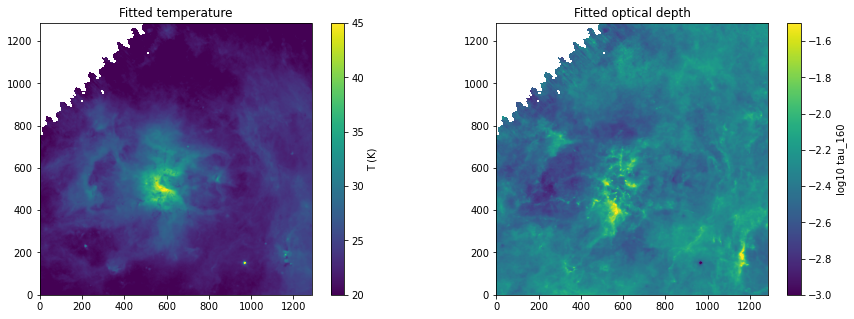

In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

# Load in the original fitted parameter maps
herschel_dir = "/home/ramsey/Documents/Research/Feedback/rcw49_data/herschel"
soln_fn = "RCW49large_2p_2BAND_160grid_beta2.0.fits"
soln_fn = os.path.join(herschel_dir, soln_fn)
assert os.path.exists(soln_fn)
with fits.open(soln_fn) as hdul:
    fit_T = hdul['solutionT'].data
    fit_tau = hdul['solutiontau'].data

# Plot them
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(fit_T, origin='lower', vmin=20, vmax=45)
plt.title("Fitted temperature")
plt.colorbar(label='T (K)')

plt.subplot(122)
plt.imshow(fit_tau, origin='lower', vmin=-3, vmax=-1.5)
plt.title("Fitted optical depth")
plt.colorbar(label='log10 tau_160');

### 1.1 Referee feedback on this method
The referee's comment on this is attached below:

>"I have only a main concern about the method for shell mass calculation using Herschel-PACS data only. On the one hand, the method involving only PACS has been already used in the literature: authors notice that Castellanos et al. 2014 adopted it on the same data, and I don't want to oppose this precedent too much. Furthermore, it is true that, if there is a stratification of temperatures in a given region, 70+160 micron surely trace a warmer component. Finally, advantage to consider only PACS bands is that the resolution of the obtained maps is that of PACS at 160 micron, and not that of SPIRE at - say - 500 micron, which is coarser. On the other hand, it is known that the dust is far from being completely optically thin at 70 micron. A greybody might not be the best way to model emission at that wavelength, and probably the effect of this should be better discussed/quantified. Furthermore, it is not proper to speak about "fit" procedure (as [Castellanos+2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...794...83C/abstract) do as well), intended as a chi-square minimization or similar, to derive temperature and mass from a simple pair of wavelengths, since an analytical solution is available in such a case. Indeed, the ratio ("color") of two analytic greybody fluxes (pixel intensities in this case), once the two frequencies are given, and $\beta$ fixed, is a function of temperature only. So the temperature can be derived directly, and univocally, from the ratio of observed intensities $I_{\lambda_1}$ and $I_{\lambda_2}$. The equation to solve (with respect to $T$) is:
$$I_{\lambda_1}/I_{\lambda_2} = \big(\lambda_2/\lambda_1\big)^{\beta+3} \times \frac{\text{exp}[\frac{hc}{\lambda_2 k T}]-1}{\text{exp}[\frac{hc}{\lambda_1 k T}]-1}$$
where the constants are those usually appearing in the greybody expression. I think it can be easily solved numerically. Strictly speaking, this is a direct determination - in practice it is a sort of "color temperature" calculation - and not a fit. Once the temperature is derived, the column density is simply part of the scaling factor appearing before the of the greybody equation depending on $T$ and $\beta$, so it can be simply derived from the ratio between the intensity at one of the two considered wavelengths and the corresponding greybody at that wavelength and with the temperature at the previous step (at this step the optically thin assumption gets critical). Since it is not particularly complicate to implement, I would encourage the authors to evaluate the results of such a method and to compare them with the ones previously obtained through the fit procedure. If the fit procedure worked well, I expect that its results are practically identical to those obtainable analytically; also in this case, however, I would encourage the authors to prefer the analytical, and more elegant, approach."

Based on their comment, I should numerically solve the above equation for $T$ given the ratio $I_{\lambda_1}/I_{\lambda_2}$.

To find $\tau$, the expression is
$$ I_{\lambda_i} = B_{\lambda_i}(T) \tau_i $$
If we are interested in the optical depth at 160 micron, then we can solve this equation for $\tau_{160}$ easily.

## 2 Color-temperature approach #1
The referee suggests solving the equation above for $T$.
I first want to examine the ratio $I_{\lambda_1}/I_{\lambda_2}$ as a function of $T$ (with $\beta$ fixed) to understand how best to solve.

In [3]:
import numpy as np

from astropy import units as u
from astropy.modeling import models

In [4]:
# PACS 70 and 160 micron; transform to wavelengths
pacs_freqs = ([70, 160] * u.micron).to(u.Hz, equivalencies=u.spectral())

# Create an array of temperatures
model_T_arr = np.arange(1, 200, 0.1)[:, np.newaxis] * u.K

# Create a model array of blackbodies
model_arr = models.BlackBody(temperature=model_T_arr)

# Evaluate the intensity at both PACS frequencies
model_I_arr = model_arr(pacs_freqs).to(u.MJy/u.sr)

# Calculate intensity ratio
model_br_ratio = model_I_arr[:, 0] / model_I_arr[:, 1]

# Frequency ratio with beta = 2 law
freq_ratio2 = (pacs_freqs[0] / pacs_freqs[1])**2
model_greybody_br_ratio = model_br_ratio * freq_ratio2

The variable `model_greybody_br_ratio` holds the ratio $I_{\lambda_1}/I_{\lambda_2}$ for $\beta = 2$ and a range of $T$ from 1 to 200 K.

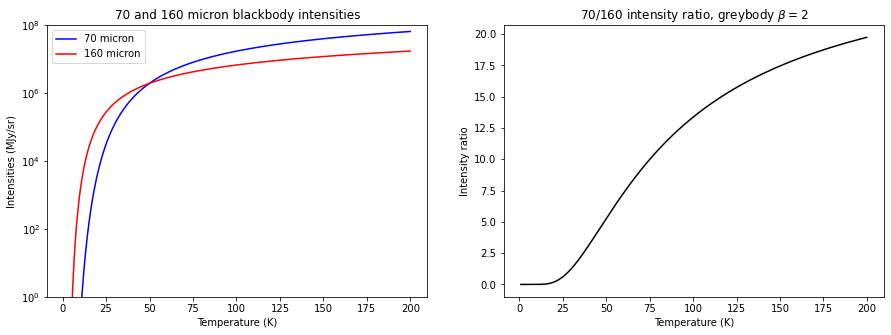

In [5]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(model_T_arr, model_I_arr[:, 0], color='b', label='70 micron')
plt.plot(model_T_arr, model_I_arr[:, 1], color='r', label='160 micron')
plt.ylabel("Intensities (MJy/sr)")
plt.xlabel("Temperature (K)")
plt.title("70 and 160 micron blackbody intensities")
plt.yscale('log'), plt.ylim(1, 1e8)
plt.legend()

plt.subplot(122)
plt.plot(model_T_arr, model_greybody_br_ratio, color='k')
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity ratio")
plt.title('70/160 intensity ratio, greybody $\\beta = 2$');

The function of $I_{\lambda_1}/I_{\lambda_2}$ as a function of $T$ is pretty smooth, even at low $T$ (see zoomed plot below). I can use this grid of $I_{\lambda_1}/I_{\lambda_2}$ vs $T$ to interpolate $T$ values given $I_{\lambda_1}/I_{\lambda_2}$ values from the data.

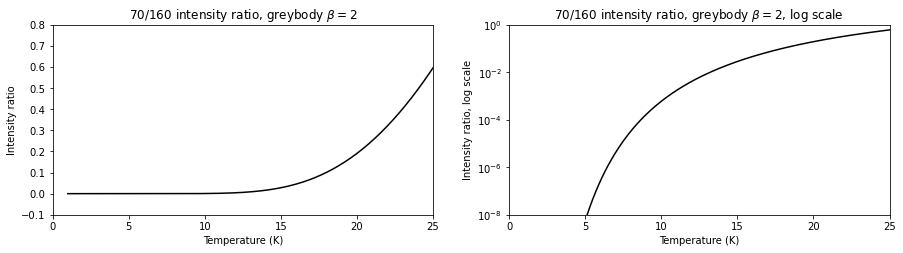

In [6]:
plt.figure(figsize=(15, 3.5))
plt.subplot(121)
plt.plot(model_T_arr, model_greybody_br_ratio, color='k')
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity ratio")
plt.xlim([0, 25]), plt.ylim([-0.1, 0.8])
plt.title('70/160 intensity ratio, greybody $\\beta = 2$')

plt.subplot(122)
plt.plot(model_T_arr, model_greybody_br_ratio, color='k')
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity ratio, log scale")
plt.xlim([0, 25]), plt.ylim([1e-8, 1]), plt.yscale('log')
plt.title('70/160 intensity ratio, greybody $\\beta = 2$, log scale');

Next: solve for $T$ values by interpolating from the grid created above

In [7]:
from scipy.interpolate import UnivariateSpline
from astropy.nddata.utils import Cutout2D

# Use the greybody frequency ratio as the independent variable in a spline fit
model_greybody_br_spline = UnivariateSpline(model_greybody_br_ratio, model_T_arr.to_value()[:, 0], s=0)

# Load in the RCW 49 Herschel images
pacs_dir = "/home/ramsey/Documents/Research/Feedback/rcw49_data/herschel/processed/1342255009_reproc160"
p70_fn = "PACS70um-image-remapped-conv-plus000080.fits"
p70_fn = os.path.join(pacs_dir, p70_fn)
assert os.path.exists(p70_fn)
p160_fn = "PACS160um-image-remapped-conv-plus000370.fits"
p160_fn = os.path.join(pacs_dir, p160_fn)
assert os.path.exists(p160_fn)

p70_img = fits.getdata(p70_fn)
p160_img = fits.getdata(p160_fn)

# Trim to just the cutout regions (since these are very large maps)
i0, j0 = 2314, 1035
width_i, width_j = 1286, 1286
p70_img = Cutout2D(p70_img, (j0, i0), (width_i, width_j)).data
p160_img = Cutout2D(p160_img, (j0, i0), (width_i, width_j)).data

# Get the ratio of the 70 and 160 micron images
br_img = p70_img / p160_img

# Feed this into the spline for temperature
T_img = model_greybody_br_spline(br_img)

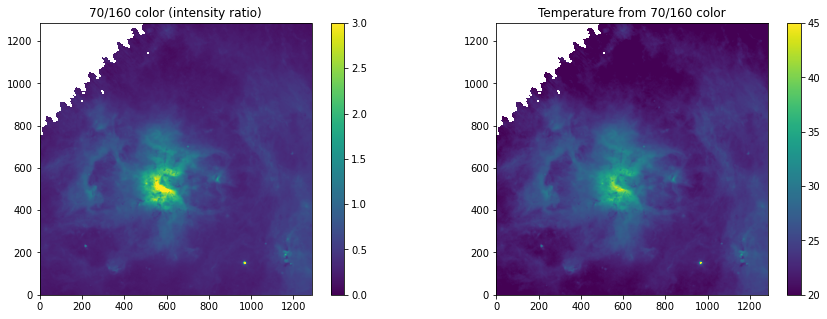

In [8]:
# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(br_img, origin='lower', vmin=0, vmax=3)
plt.title("70/160 color (intensity ratio)")
plt.colorbar()

plt.subplot(122)
plt.imshow(T_img, origin='lower', vmin=20, vmax=45)
plt.title("Temperature from 70/160 color")
plt.colorbar();

## 2.1 How does this compare to the least-squares optimization?
Like the referee said, it shouldn't change since the least-squares optimization should be finding the same global minimum.
I explore this in the following images.

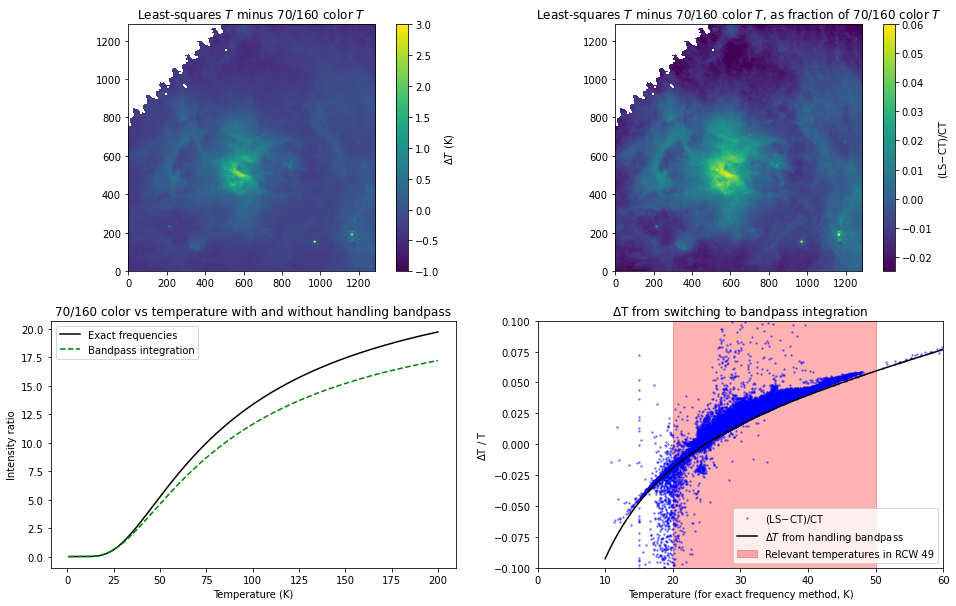

In [9]:
from mantipython.physics import greybody, dust, instrument

# Set up the PACS detectors for 70 and 160
p70_detector, p160_detector = instrument.get_instrument([70, 160])
# Set up output array
model_bandpass_br_ratio = np.zeros(model_T_arr.size)
# Loop through the temperature array. Need to do everything unitless this time for mantipython
# Since we can't put in tau = 0, put tau = very small (log10(tau) = -8, for example)
args = (-8., dust.TauOpacity(2.))
for i, t in enumerate(model_T_arr.to_value()):
    p70_I = p70_detector.detect(greybody.Greybody(t, *args))
    p160_I = p160_detector.detect(greybody.Greybody(t, *args))
    model_bandpass_br_ratio[i] = p70_I / p160_I

model_bandpass_br_spline = UnivariateSpline(model_bandpass_br_ratio, model_T_arr.to_value()[:, 0], s=0)


plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.imshow(fit_T - T_img, origin='lower', vmin=-1, vmax=3)
plt.title("Least-squares $T$ minus 70/160 color $T$")
plt.colorbar(label='$\Delta T$ (K)')

plt.subplot(222)
plt.imshow((fit_T - T_img)/T_img, origin='lower', vmin=-.025, vmax=.06)
plt.title("Least-squares $T$ minus 70/160 color $T$, as fraction of 70/160 color $T$")
plt.colorbar(label='(LS$-$CT)/CT')

plt.subplot(223)
plt.plot(model_T_arr, model_greybody_br_ratio, color='k', label='Exact frequencies')
plt.plot(model_T_arr, model_bandpass_br_ratio, '--', color='g', label='Bandpass integration')
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity ratio")
plt.legend()
plt.title("70/160 color vs temperature with and without handling bandpass")

# Make an evenly spaced ratio array that is covered by both of these models
flat_T_arr = model_T_arr.to_value()[:, 0]
tmp_dT = (flat_T_arr - model_greybody_br_spline(model_bandpass_br_ratio))/flat_T_arr
plt.subplot(224)
# Plot the pixel differences between the 70/160 color vs the least-squares solution
plt.plot(fit_T.flatten(), ((fit_T - T_img)/fit_T).flatten(), '.', markersize=3, color='b', alpha=0.4, label='(LS$-$CT)/CT')
# Plot the theoretical stuff
plt.plot(flat_T_arr[90:], tmp_dT[90:], color='k', label='$\Delta T$ from handling bandpass')
plt.xlim([0, 60]), plt.ylim([-.1, .1])
plt.axvspan(20, 50, alpha=0.3, color='red', label='Relevant temperatures in RCW 49')
plt.title("$\\Delta$T from switching to bandpass integration")
plt.xlabel("Temperature (for exact frequency method, K)")
plt.ylabel("$\\Delta$T / T")
plt.legend();

The first image above (top left, _"Least-squares $T$ minus 70/160 color $T$"_) shows the difference between the original least-squares temperature solution and the new 70/160 color solution.
It is clear that the difference is much smaller than the temperatures themselves; see the second image above (top right, "_Least-squares $T$ minus 70/160 color $T$, as fraction of 70/160 color $T$_"), which shows the same image as the left hand panel but as a fraction of the 70/160 temperature solution.
From this, we see that the difference is at the 5% level or less.

**The bulk of this difference is due to the lack of handling the PACS bandpass profiles.** In the third figure (bottom left) I show the color temperature as a function of temperature for both the simple, exact-frequency 70/160 color (solid black line) as well as for correct handling of the bandpasses (dotted green line). **It is clear that properly handling the bandpass profiles will raise the temperature solution by a few K and that this effect gets more severe as temperature increases.**

In the final plot (bottom right) I use the two lines from the third plot to calculate the expected temperature increase as a fraction of the exact-frequency solution. The expected fractional increase (above $\sim$20 K, or decrease below that) is shown as the solid black line. The relevant temperature range for the RCW 49 shell is highlighed in red. I overplotted the values of the pixels in the second image (top right) as blue points. As a reminder, these pixels were calculated as LS$-$CT/CT, where LS is the least-squares solution (which handles the bandpass correctly) and CT is the exact-frequency 70/160 color solution. As is evident from this final plot, the bandpass handling explains most of the difference between the least-squares solution and the exact-frequency color-temperature solution.

# 3 Color temperature approach #2, handling bandpass
Handling the bandpass correctly is simple, but strays slightly from the referee's solution. The analytic expression can't be reduced much:
$$ I_{\lambda_1}/I_{\lambda_2} = \frac{\text{BP}_1\big[ S_{\lambda_1} \big]}{\text{BP}_2\big[ S_{\lambda_2} \big]} $$
where
$$ S_{\lambda_i} = B_{\lambda_i}(1 - e^{-\tau_i}) $$
and $\text{BP}_i$ is a "bandpass" function involving a bandpass profile-weighted integral over the spectral axis and normalization with an equivalent width of the bandpass.
Instead, it is directly solved in the same way as the exact-frequency version: spline-fit a model grid of 70/160 color vs temperature and use that to map from color to temperature.

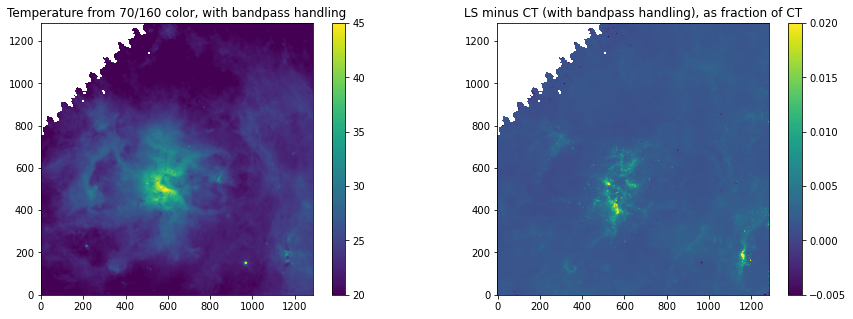

In [10]:
# Feed the observed 70/160 ratio image into the new spline
better_T_img = model_bandpass_br_spline(br_img)
# Plot results
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(better_T_img, origin='lower', vmin=20, vmax=45)
plt.title("Temperature from 70/160 color, with bandpass handling")
plt.colorbar()

plt.subplot(122)
plt.imshow((fit_T - better_T_img)/better_T_img, origin='lower', vmin=-0.005, vmax=.02)
plt.title("LS minus CT (with bandpass handling), as fraction of CT")
plt.colorbar();

The 70/160 color solution is now in much better agreement with the least-squares solution, at better than 2% as shown in the right-hand image above.
The least-squares solution is generally hotter.

Interestingly, the deviations now trace the optical depth map (see the least-squares optical depth solution in a plot towards the top of this document).
This must be indicating that any remaining differences are due to optical depth effects, but the agreement to better than 2% in temperature is good enough for our purposes.

## 3.1 Comparing optical depth solutions
I will now compare the least-squares optical depth solution to the 70/160 color optical depth solution.

The intensity for a given bandpass is
$$ I_{\lambda} = BP_{\lambda}\big[ S_{\lambda} \big] = BP_{\lambda}\big[ B_{\lambda}(T)(1 - e^{-\tau_{\lambda}}) \big] $$
where
$$ \tau_{\lambda} = \tau_{160} \Bigg( \frac{160~\text{micron}}{\lambda} \Bigg)^{\beta} $$
since I have been expressing optical depth as the optical depth at 160 micron.

Assuming the dust is optically thin ($\tau_{\lambda} \ll 1$) at these wavelengths, $(1 - e^{-\tau_{\lambda}}) \approx \tau_{\lambda}$ so
$$ I_{\lambda} = BP_{\lambda}\big[ B_{\lambda}(T) \, \tau_{\lambda} \big] = BP_{\lambda}\big[ B_{\lambda}(T) \, \tau_{160} (160~/~\lambda)^{\beta} \big] $$

Recall that $BP_{\lambda}$ is mostly an integral. $\tau_{160}$ can be pulled out front.

$$ I_{\lambda} = \tau_{160} \, BP_{\lambda}\big[ B_{\lambda}(T) \, (160~/~\lambda)^{\beta} \big] $$

We can solve for $\tau_{160}$ if we calculate $BP_{\lambda}\big[ B_{\lambda}(T) \, (160~/~\lambda)^{\beta} \big]$, which can be done numerically for either band.

We can calculate the full right-hand expression below for either bandpass (160 or 70 micron, we only need to use one).

$$ \tau_{160} =  \frac{I_{\lambda}}{BP_{\lambda}\big[ B_{\lambda}(T) \, (160~/~\lambda)^{\beta} \big]} $$

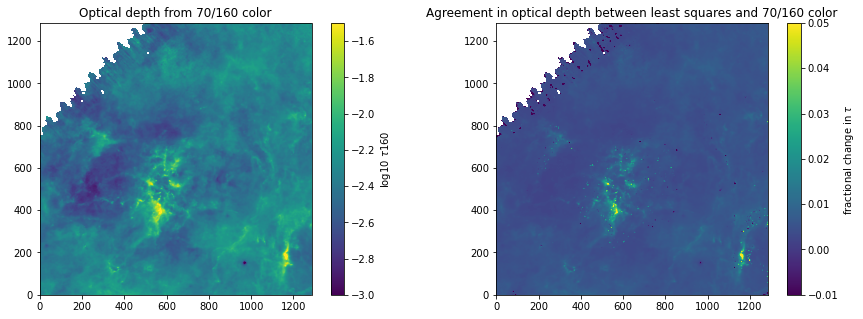

In [35]:
# Create optically thin "tau=1" 160 micron intensities as a function of temperature
# Tau=1 won't make the expression optically thick;
#   rather, it's mathematically equivalent to pulling tau160 out of the equation
zerotau_160intensity = np.zeros(model_T_arr.size)
args = (0, dust.TauOpacity(2.))
for i, t in enumerate(model_T_arr.to_value()):
    p160_I = p160_detector.detect(greybody.ThinGreybody(t, *args))
    zerotau_160intensity[i] = p160_I
# Spline fit that as a function of temperature
# then use that to convert the new temperature map to "zero optical depth intensities"
zerotau_I_spline = UnivariateSpline(model_T_arr.to_value()[:, 0], zerotau_160intensity, s=0)
# Get rid of huge negatives from the T image
better_T_img[better_T_img < 0] = np.nan
zerotau_I_img = zerotau_I_spline(better_T_img)
better_tau160_img = p160_img / zerotau_I_img

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(np.log10(better_tau160_img), origin='lower', vmin=-3, vmax=-1.5)
plt.title("Optical depth from 70/160 color")
plt.colorbar(label='log10 $\\tau$160')

plt.subplot(122)
plt.imshow((better_tau160_img - 10.**fit_tau)/better_tau160_img, origin='lower', vmin=-0.01, vmax=0.05)
plt.title("Agreement in optical depth between least squares and 70/160 color")
plt.colorbar(label='fractional change in $\\tau$');

The left-hand plot above shows the (log10) optical depth solution from the 70/160 color method.

The right-hand plot above shows fractional difference in optical depth between the least squares solution and the 70/160 color solution. In particular, the image shows the optical depth from color minus the optical depth from the LS fit as a fraction of the optical depth from color: (CT$-$LS)/CT. Optical depth from color is nearly always higher (least squares runs hotter, so this trade-off makes sense).

The fractional difference in optical depth shows that we are within 5% agreement between the least-squares fit and the bandpass-handling 70/160 color solution. The highest deviation traces high column density, so that means most of the shell will suffer from 2-3% disagreement. Since these methods should both be valid, this puts a 5% uncertainty on the shell mass.
Our existing uncertainty estimate on our shell mass is already greater than 5%, so this does not change our result much.

In [36]:
# Save the T/tau images
# First, the "better" one that I just created
hdul1 = fits.HDUList([fits.PrimaryHDU(), fits.ImageHDU(data=better_T_img), fits.ImageHDU(data=np.log10(better_tau160_img))])
hdul1[1].header['EXTNAME'] = 'T'
hdul1[2].header['EXTNAME'] = 'tau'
hdul1.writeto(os.path.join(herschel_dir, "colorsoln_better.fits"), overwrite=True)

T_img[T_img < 0] = np.nan
model_160_img = models.BlackBody(temperature=T_img[:, :, np.newaxis]*u.K)(pacs_freqs[1:][np.newaxis, np.newaxis, :])[:, :, 0].to(u.MJy/u.sr).to_value()
tau160_img = p160_img / model_160_img
hdul2 = fits.HDUList([fits.PrimaryHDU(), fits.ImageHDU(data=T_img), fits.ImageHDU(data=np.log10(tau160_img))])
hdul2[1].header['EXTNAME'] = 'T'
hdul2[2].header['EXTNAME'] = 'tau'
hdul2.writeto(os.path.join(herschel_dir, "colorsoln_standard.fits"), overwrite=True)

# 4 Remaining issue: Optically thin?

There are likely residual optical depth effects present.
The referee also points out that dust is not optically thin at 70 micron, but our use of 70 and 160 micron observations together is hinged on the assumption that they are both optically thin.

What can we say about optical depth effects?

Based on the estimate of $\tau_{70}$ below from the solution, the cloud is only marginally optically thin at 70 micron, but we can still probably argue that it is.

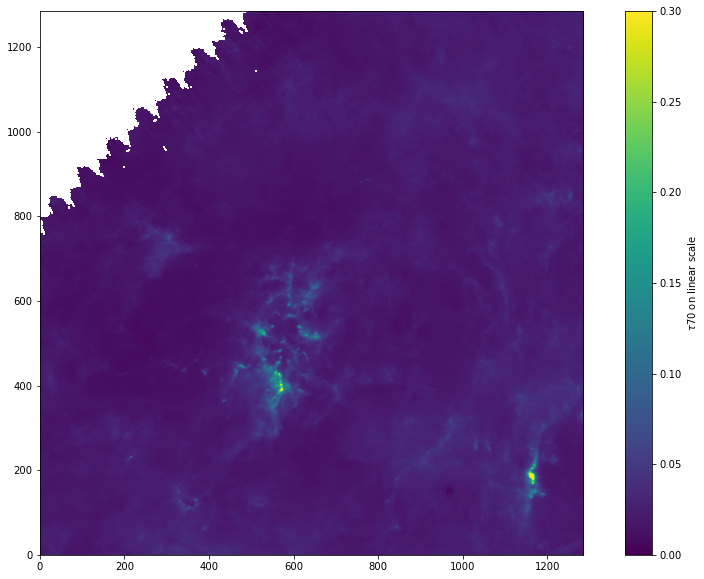

In [37]:
# What is tau_70 based on the calculated tau_160?
tau70_img = tau160_img * (160./70.)**2.

plt.figure(figsize=(15, 10))
plt.subplot(111)
plt.imshow(tau70_img, origin='lower', vmin=0, vmax=0.3)
plt.colorbar(label='$\\tau$70 on linear scale');